# Introduction

The same as `cM_IFN_3.ipynb`, but now trying to use the Bingo outputs.

## Imports and Setup

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy
from sklearn.metrics import jaccard_score
import requests
import pprint
import json

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import networkx as nx
from textwrap import wrap

In [2]:
sc_prefix = '/data/codec/production.run/'

In [3]:
prefix = '/data/codec/production.run/'
with open(prefix + 'cond.colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

## Load in DE Data

### mRNA

In [11]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Mem', 'B_Naive', 'T4_Mem', 'T4_Naive', 'T_Tox', 'T8_Naive', 'HSC', 'NK', 'pDC','M_cDC']

conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['cM', 'ncM', 'cDC']

In [12]:
de_mrna = dict() # differential expression dictionary
de_mrna_genes = dict()
for cond in conds_1:
    de_mrna[cond] = dict()
    
combos = list(it.product(conds_1, cts_1)) + list(it.product(conds_2, cts_2))
for combo in combos:
    de_mrna[combo[0]][combo[1]] = pd.read_csv(sc_prefix + 'mrna/deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

### ADTs

In [13]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Memory', 'B_Naive', 'CD4_T_Memory', 'CD4_T_Naive', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Naive', 'HSC', 'NK', 'pDC','Mono_cDC_All']

conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['Mono_C', 'Mono_NC', 'cDC']

In [14]:
de_adts = dict() # differential expression dictionary
for cond in conds_1:
    de_adts[cond] = dict()
    
combos = list(it.product(conds_1, cts_1)) + list(it.product(conds_2, cts_2))
for combo in combos:
    de_adts[combo[0]][combo[1]] = pd.read_csv(sc_prefix + 'adts/deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

## Prepare Data Dictionary

Going to code the conditions as a 0 or 1. Everything will be stored in nested dictionaries, and I will point variables to intermediary nested dicts to make it easier to read. Once fully developed, I should make a `class` to house all the data.

In [38]:
cond0, cond1 = ['B', 'G']
ct_mrna, ct_adts = 'B_Mem', 'B_Memory'

In [39]:
de = dict()
for feature_type, ct, de_original in zip(['mrna', 'adts'], [ct_mrna, ct_adts], [de_mrna, de_adts]):
    de[feature_type] = dict()
    df_cond0 = de_original[cond0][ct].copy()
    df_cond1 = de_original[cond1][ct].copy()
    
    df_cond0.columns = df_cond0.columns + '-0'
    df_cond1.columns = df_cond1.columns + '-1'
    
    de[feature_type]['compare'] = pd.concat([df_cond0, df_cond1], axis=1)
    de[feature_type]['compare'] =  de[feature_type]['compare'][[''.join(i) for i in it.product(['log2FoldChange-', 'padj-'], ['0', '1'])]].copy()
    l0s, l1s, p0s, p1s =  [''.join(i) for i in it.product(['l', 'p'], ['0', '1'])]
    de[feature_type]['compare'].columns = [l0s, l1s, p0s, p1s]
    de[feature_type]['compare'] =  de[feature_type]['compare'][[l0s, p0s, l1s, p1s]].copy()
    
    de[feature_type]['compare'][l0s] = de[feature_type]['compare'][l0s].fillna(0)
    de[feature_type]['compare'][p0s] = de[feature_type]['compare'][p0s].fillna(1)
    de[feature_type]['compare'][l1s] = de[feature_type]['compare'][l1s].fillna(0)
    de[feature_type]['compare'][p1s] = de[feature_type]['compare'][p1s].fillna(1)

In [40]:
def create_bool_dict(de_compare, combos, pthresh_keep, pthresh_ns, lthresh):
    bool_dict = dict()
    for combo in combos:
        if combo[1] == 'u':
            bool0 = (de_compare[l0s].values > lthresh) & (de_compare[p0s].values <= pthresh_keep)
        elif combo[1] == 'd':
            bool0 = (de_compare[l0s].values < -lthresh) & (de_compare[p0s].values <= pthresh_keep)
        elif combo[1] == 'n':
            bool0 = (de_compare[p0s].values > pthresh_ns)
        else:
            raise ValueError
        if combo[3] == 'u':
            bool1 = (de_compare[l1s].values > lthresh) & (de_compare[p1s].values <= pthresh_keep)
        elif combo[3] == 'd':
            bool1 = (de_compare[l1s].values < -lthresh) & (de_compare[p1s].values <= pthresh_keep)
        elif combo[3] == 'n':
            bool1 = (de_compare[p1s].values > pthresh_ns)
        else:
            raise ValueError
        bool_dict[combo] = bool0 & bool1
    return bool_dict

In [41]:
combos = [''.join(np.ravel(i)) for i in list(it.product(it.product(['0'], ['d', 'n', 'u']), it.product(['1'], ['d', 'n', 'u'])))]
combos.remove('0n1n')

In [42]:
for feature_type, pthresh_keep, pthresh_ns, lthresh in zip(['mrna', 'adts'], [0.05, 0.05], [0.05, 0.05], [0.5, 0]):
    de[feature_type]['bool_dict'] = create_bool_dict(de[feature_type]['compare'], combos=combos, pthresh_keep=pthresh_keep, pthresh_ns=pthresh_ns, lthresh=lthresh)

In [43]:
de['adts']['compare'][de['adts']['bool_dict']['0d1d']]

l0        p0        l1        p1
CD184|CXCR4    -0.436505  0.000004 -0.299441  0.009659
CD357|TNFRSF18 -0.203025  0.000029 -0.159042  0.009659

In [44]:
dem = de['mrna']
dea = de['adts']

In [45]:
def adjust_lightness(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [46]:
dem['bool_dict'].keys()

dict_keys(['0d1d', '0d1n', '0d1u', '0n1d', '0n1u', '0u1d', '0u1n', '0u1u'])

In [47]:
dx_color_dict = dict(zip(dem['bool_dict'].keys(),
                         [
                             'blue',
                             
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 1.2)),
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 0.7)),
                             
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 1.2)),
                             cond_colors['G'],
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 0.7)),
                             cond_colors['B'],
                             
                             'red'
                             
                         ]
                        )
                    )

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


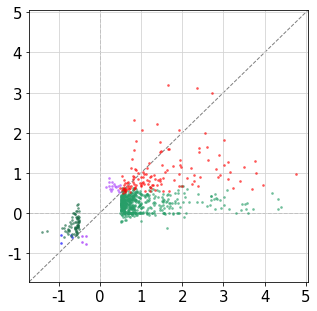

In [48]:
fig, ax = plt.subplots(figsize=(5,5))

# shared_up_bool = ((dem['bool_dict']['0u1u']) | (dem['bool_dict']['0d1d']))
# sp0_bool = (dem['bool_dict']['0u1n'] | dem['bool_dict']['0d1n'])
# sp1_bool = (dem['bool_dict']['0n1u'] | dem['bool_dict']['0n1d'])
# switched_bool =  ((dem['bool_dict']['0u1d']) | (dem['bool_dict']['0d1u']))

# shared = dem['compare'][shared_bool]
# sp0 = dem['compare'][sp0_bool]
# sp1 = dem['compare'][sp1_bool]
# switched = dem['compare'][switched_bool]

for dx in dem['bool_dict']:
    ax.scatter(*dem['compare'].loc[dem['bool_dict'][dx], ['l0', 'l1']].T.values, c=dx_color_dict[dx], 
               s=3, alpha=0.5,
#                ec='k', linewidth=0.5, 
              )

# ax.scatter(sp0['l0'].values, sp0['l1'].values, s=3, alpha=0.5, color=cond_colors['B'])
# ax.scatter(sp1['l0'].values, sp1['l1'].values, s=3, alpha=0.5, color=cond_colors['G'])
# ax.scatter(shared['l0'].values, shared['l1'].values, s=3, alpha=0.5, color='')
# ax.scatter(switched['l0'].values, switched['l1'].values, s=3, alpha=0.5, color='k')

lim = min(min(plt.xlim()), min(plt.ylim())), max(max(plt.xlim()), max(plt.ylim()))
ax.set_axisbelow(True)
ax.grid(color='lightgray')
ax.plot(lim, lim, color='gray', linewidth=1, linestyle='--', zorder=-1)
ax.plot([0, 0], lim, color='gray', linewidth=1, linestyle='--', zorder=-1)
ax.plot(lim, [0, 0], color='gray', linewidth=1, linestyle='--', zorder=-1)
ax.set_ylim(lim)
ax.set_xlim(lim)
ticks = ax.get_xticks().astype(int)
ax.set_xticklabels(labels=ticks, size=15)
ax.set_yticklabels(labels=ticks, size=15);
# ax.set_aspect('equal', adjustable='box')

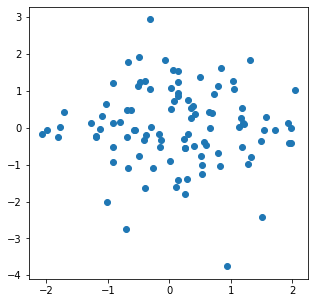

In [26]:
min_incr = 1
plt.figure(figsize=(5, 5))
plt.scatter(np.random.normal(size=100), np.random.normal(size=100))
xlim, ylim = plt.xlim(), plt.ylim()
lim = min(min(xlim), min(ylim)), max(max(xlim), max(ylim))

In [85]:
lim_round = np.floor(lim[0]), np.ceil(lim[1])
step = 2


array([-3., -1.,  1.,  3.])

In [86]:
def myround(x, base=5):
    return base * round(x/base)

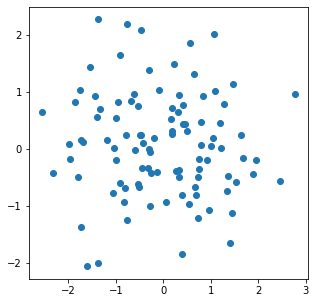

In [58]:
def get_xticks(xlim, ylim, step=1, contain=None):
    np.floor(min(min(xlim), min(ylim)), max(max(xlim), max(ylim))
    bot, top = np.floor(lim[0]), np.ceil(lim[1])
    if type(contain) != type(None):
        ticks = np.concatenate(0, np.abs(bot))
    ticks = np.arange(bot, top + step, step=step)

In [59]:
lim

(-5.563015104750264, 8.345495652559983)

array([], dtype=float64)

(0.0, 1.0)

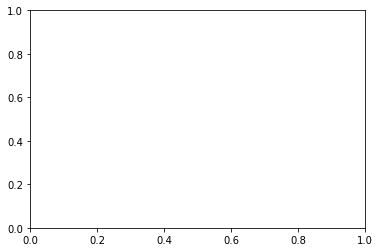

In [30]:
lim

(-5.563015104750264, 8.345495652559983)

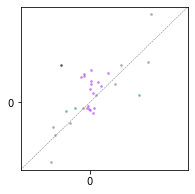

In [16]:
plt.figure(figsize=(3,3))

shared_bool = ((dea['bool_dict']['0u1u']) | (dea['bool_dict']['0d1d']))
sp0_bool = (dea['bool_dict']['0u1n'] | dea['bool_dict']['0d1n'])
sp1_bool = (dea['bool_dict']['0n1u'] | dea['bool_dict']['0n1d'])
switched_bool = ((dea['bool_dict']['0u1d']) | (dea['bool_dict']['0d1u']))

switched = dea['compare'][switched_bool]
shared = dea['compare'][shared_bool]
sp0 = dea['compare'][sp0_bool]
sp1 = dea['compare'][sp1_bool]

plt.scatter(sp0['l0'].values, sp0['l1'].values, s=3, alpha=0.5, color=cond_colors['B'])
plt.scatter(sp1['l0'].values, sp1['l1'].values, s=3, alpha=0.5, color=cond_colors['G'])
plt.scatter(shared['l0'].values, shared['l1'].values, s=3, alpha=0.5, color='gray')
plt.scatter(switched['l0'].values, switched['l1'].values, s=3, alpha=0.5, color='k')

lim = min(min(plt.xlim()), min(plt.ylim())), max(max(plt.xlim()), max(plt.ylim()))
plt.plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
plt.ylim(lim)
plt.xlim(lim)
plt.xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
plt.yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

## BubblePlots of Individual Genes and Proteins

### Define Gene Groups

In [17]:
chemokines = ['CCL1', 'CCL2', 'CCL3', 'CCL3L1', 'CCL3L3', 'CCL4', 'CCL4L1', 'CCL4L2', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 'CCL14', 'CCL15', 'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL27', 'CCL28', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL8', 'CXCL9', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL14', 'CXCL16', 'CXCL17', 'CX3CL1', 'XCL1', 'XCL2']
chemokine_receptors = ['XCR1', 'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'CX3CR1', 'ACKR1', 'ACKR2', 'ACKR3', 'ACKR4', 'CCRL2', 'PITPNM3', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCR10']
ILs = ['IL1A', 'IL1B', 'IL1F10', 'IL1RN', 'IL2', 'IL3', 'IL4', 'IL5', 'IL6', 'IL7', 'CXCL8', 'IL9', 'IL10', 'IL11', 'IL12A', 'IL12B', 'IL13', 'IL15', 'IL16', 'IL17A', 'IL17B', 'IL17C', 'IL17D', 'IL17F', 'IL18', 'IL19', 'IL20', 'IL21', 'IL22', 'IL23A', 'IL24', 'IL25', 'IL26', 'IL27', 'IL31', 'IL32', 'IL33', 'IL34', 'IL36A', 'IL36B', 'IL36G', 'IL36RN', 'IL37']
IL_receptors = ['CXCR1', 'CXCR2', 'IL1RAP', 'IL1RAPL1', 'IL1RAPL2', 'IL1RL1', 'IL1RL2', 'IL1R1', 'IL1R2', 'IL2RA', 'IL2RB', 'IL2RG', 'IL3RA', 'IL4R', 'IL5RA', 'IL6R', 'IL6ST', 'IL7R', 'IL9R', 'IL10RA', 'IL10RB', 'IL11RA', 'IL12RB1', 'IL12RB2', 'IL13RA1', 'IL13RA2', 'IL15RA', 'IL17RA', 'IL17RB', 'IL17RC', 'IL17RD', 'IL17RE', 'IL18RAP', 'IL18R1', 'IL20RA', 'IL20RB', 'IL21R', 'IL22RA1', 'IL22RA2', 'IL27RA', 'IL31RA']
MHC = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPA2', 'HLA-DPA3', 'HLA-DPB1', 'HLA-DPB2', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DQB3', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB2', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-DRB6', 'HLA-DRB7', 'HLA-DRB8', 'HLA-DRB9', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'HLA-J', 'HLA-K', 'HLA-L', 'HLA-N', 'HLA-P', 'HLA-S', 'HLA-T', 'HLA-U', 'HLA-V', 'HLA-W', 'HLA-X', 'HLA-Y', 'HLA-Z']
MiHC = ['AKAP13', 'APOBEC3B', 'ARHGDIB', 'BCAT2', 'BCL2A1', 'CD19', 'CENPM', 'CTSH', 'C19orf48', 'DDX3Y', 'DPH1', 'EBI3', 'ERAP1', 'ERBB2', 'GEMIN4', 'HEATR1', 'ARHGAP45', 'HMHB1', 'HMSD', 'KDM5D', 'PUM3', 'RESF1', 'LY75', 'MR1', 'MTHFD1', 'MYO1G', 'NUP133', 'PDCD11', 'PI4K2B', 'PKN3', 'PRCP', 'PTK2B', 'P2RX5', 'RPS4Y1', 'SLC1A5', 'SLC19A1', 'SON', 'SP110', 'SSR1', 'SWAP70', 'TMSB4Y', 'TOR3A', 'TRIM22', 'TRIM42', 'TRIP10', 'TYMP', 'UGT2B17', 'USP9Y', 'UTY', 'WNK1', 'ZNF419']

### Plot

In [18]:
m_plot = pd.concat([dem['compare'][dem['bool_dict'][dx]] for dx in dem['bool_dict'].keys()], keys=dem['bool_dict'].keys(), names=['dx', 'gene']).reset_index('dx')
a_plot = pd.concat([dea['compare'][dea['bool_dict'][dx]] for dx in dea['bool_dict'].keys()], keys=dea['bool_dict'].keys(), names=['dx', 'gene']).reset_index('dx')

In [19]:
def get_ordering(Z, index, return_idxs=False):
    # credit to user Has QUIT--Anony-Mousse from https://stackoverflow.com/questions/12572436/calculate-ordering-of-dendrogram-leaves
    n = len(Z) + 1
    cache = dict()
    for k in range(len(Z)):
        c1, c2 = int(Z[k][0]), int(Z[k][1])
        c1 = [c1] if c1 < n else cache.pop(c1)
        c2 = [c2] if c2 < n else cache.pop(c2)
        cache[n+k] = c1 + c2
    ordering = cache[2*len(Z)]
    if return_idxs == False:
        return index[ordering]
    elif return_idxs == True:
        return ordering
    else:
        raise ValueError
        
def adjust_lightness(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def make_bubble_arr(df_plot, features, focus_dx, normed=False, sig_params=None):
    plot_bool = df_plot.index.isin(features), 
    df_plot = df_plot.loc[plot_bool]
    df_plot = df_plot[~df_plot.duplicated()]
    df_plot = df_plot.sort_values(by='dx')
    gene_order = list()
    dx_colors = list()
    len_dict = dict()
    for dx in focus_dx:
        df_clust = df_plot[df_plot['dx'] == dx][['l0', 'l1']]
        if df_clust.shape[0] > 1:
            Z = scipy.cluster.hierarchy.linkage(df_clust, method='average', optimal_ordering=True)
            order = get_ordering(Z, df_clust.index)
            maxes = df_clust.loc[order].max(1)
            if maxes[0] < maxes[-1]:
                order = order[::-1]
            gene_order.append(order)
            len_dict[dx] = len(order)
            dx_colors.append([dx_color_dict[dx]]*order.shape[0])
        elif df_clust.shape[0] == 1:
            gene_order.append([df_clust.index[0]])
            len_dict[dx] = 1
            dx_colors.append([dx_color_dict[dx]])
        elif df_clust.shape[0] == 0:
            continue
        else:
            raise
    gene_order = [i for j in gene_order for i in j]
    df_plot_ordered = df_plot.loc[gene_order]
    if normed:
        sig_vals = norm_between(-np.log10(np.concatenate([df_plot_ordered['p0'].values, df_plot_ordered['p1'].values])), 1, 10)
    else:
        assert type(sig_params) != type(None)
        bins = sig_params['bins']
        min_size, max_size = sig_params['dot_size_range']
        sig_vals = np.digitize(np.concatenate([df_plot_ordered['p0'].values, 
                                               df_plot_ordered['p1'].values]), bins)*((max_size - min_size)/len(bins)) + min_size
    
    bubble_plot_arr = np.stack([
        [1]*df_plot_ordered.shape[0] + [0]*df_plot_ordered.shape[0], # 1 then 0 so condition0 is top row of bubble plot
        np.concatenate([np.arange(len(gene_order))]*2),
        np.concatenate([df_plot_ordered['l0'].values, df_plot_ordered['l1'].values]),
        sig_vals
    ], axis=1)
    return bubble_plot_arr, df_plot_ordered, len_dict, gene_order

def get_features(gene_list, protein=False):
    if protein:
        return dea['compare'].index[np.stack([dea['compare'].index.str.contains(i) for i in gene_list]).any(0)].values
    else:
        return np.intersect1d(gene_list, dem['compare'].index.values)
    
def get_normed_vlim(df_plot):
    vlim_val = np.max(np.abs((df_plot_ordered[['l0', 'l1']].min().min(), df_plot_ordered[['l0', 'l1']].max().max())))
    return (-vlim_val, vlim_val)

def bubble_plotter(bubble_plot_arr, len_dict, gene_order, protein=False, plot_params=None):
    if type(plot_params) == type(None):
        plot_params = {
            'height': 1.25,
            'ylim_buffer': 0.5,
            'height_ratios': [3, .5],
            'linewidth': 5
        }
    
    font_color = 'gray' if protein else 'black'

    fig, ax = plt.subplots(2, 1, figsize=(len(gene_order)/2, plot_params['height']), gridspec_kw={'height_ratios': plot_params['height_ratios'], 'hspace': 0})
    ax[0].scatter(bubble_plot_arr[:, 1], bubble_plot_arr[:, 0], 
                  s=bubble_plot_arr[:, 3]*20, c=bubble_plot_arr[:, 2],
                  cmap='bwr', vmin=vlim[0], vmax=vlim[1],
    #            edgecolor='k', linewidth=0.5
              )

    for axes in ax:
        axes.set_facecolor((1, 1, 1, 0))
        axes.set_xlim(-1, len(gene_order))
    ax[0].set_ylim(0 - plot_params['ylim_buffer'], 1 + plot_params['ylim_buffer'])
    ax[0].set_yticks([0, 1])
    ax[0].set_yticklabels(['IFN-ɣ', 'IFN-β'])

    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()
    ax[0].set_xticks(np.arange(len(gene_order)))
    # [i.set_visible(False) for i in ax[0].xax[0]is.get_ticklines()]
    if protein:
        ax[0].set_xticklabels([i.split('|')[1] for i in gene_order], rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});
    else:
        ax[0].set_xticklabels(gene_order, rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});

    for spine in ['right', 'bottom']:
        ax[0].spines[spine].set_visible(False)
    for spine in ['right', 'left', 'bottom', 'top']:
        ax[1].spines[spine].set_visible(False)

    ax[1].set_xticks(np.arange(len(gene_order)))
    ax[1].set_xlim(ax[0].get_xlim())
    # ax[1].set_ylim(0, 0.5)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    lastpos=0
    for dx in len_dict:
        ax[1].plot([
            lastpos - 0.5, lastpos + len_dict[dx] - 0.5], 
            [0.5, 0.5], 
            c=dx_color_dict[dx], linewidth=plot_params['linewidth'], solid_capstyle='butt'
        )
        lastpos += len_dict[dx]
    return

In [20]:
focus_dx = ['0u1u', '0u1n', '0u1d', '0n1u', '0d1u', '0d1n', '0n1d', '0d1d']

In [21]:
dx_color_dict = dict(zip(focus_dx,
                         [
                             'red',
                             cond_colors['B'],
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 0.7)),
                             cond_colors['G'],
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 0.7)),
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 1.2)),
                             mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 1.2)),
                             'blue'
                             
                         ]
                        )
                    )

In [22]:
protein = True
features = get_features(
    IL_receptors, 
    protein=protein
)

if not protein:
    df_plot = m_plot
    vlim = (-2, 2)
else:
    df_plot = a_plot
    vlim = (-0.5, 0.5)

In [23]:
features

array(['CD123|IL3RA', 'CD127|IL7R', 'CD126|IL6R', 'CD124|IL4R',
       'IL-21R|IL21R', 'CD25|IL2RA'], dtype=object)

In [24]:
sig_params = {
    'bins': [5e-2, 1e-2, 1e-5, 1e-10, 1e-30, 1e-50],
    'dot_size_range': (0.3, 15)
}
bubble_plot_arr, df_plot, len_dict, gene_order = make_bubble_arr(df_plot, features, focus_dx, sig_params=sig_params)

In [25]:
plot_params = {
    'height': 1.25,
    'ylim_buffer': 0.5,
    'height_ratios': [3, .5],
    'linewidth': 5
}

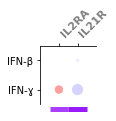

In [26]:
bubble_plotter(bubble_plot_arr, len_dict, gene_order, protein=protein, plot_params=plot_params)

In [27]:
# font_color = 'gray' if protein else 'black'

# fig, ax = plt.subplots(2, 1, figsize=(len(gene_order)/2, height), gridspec_kw={'height_ratios': height_ratios, 'hspace': 0})
# ax[0].scatter(bubble_plot_arr[:, 1], bubble_plot_arr[:, 0], 
#               s=bubble_plot_arr[:, 3]*20, c=bubble_plot_arr[:, 2],
#               cmap='bwr', vmin=vlim[0], vmax=vlim[1],
# #            edgecolor='k', linewidth=0.5
#           )

# for axes in ax:
#     axes.set_facecolor((1, 1, 1, 0))
#     axes.set_xlim(-1, len(gene_order))
# ax[0].set_ylim(0 - ylim_buffer, 1 + ylim_buffer)
# ax[0].set_yticks([0, 1])
# ax[0].set_yticklabels(['IFN-ɣ', 'IFN-β'])

# ax[0].xaxis.set_label_position('top') 
# ax[0].xaxis.tick_top()
# ax[0].set_xticks(np.arange(len(gene_order)))
# # [i.set_visible(False) for i in ax[0].xax[0]is.get_ticklines()]
# if protein:
#     ax[0].set_xticklabels([i.split('|')[1] for i in gene_order], rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});
# else:
#     ax[0].set_xticklabels(gene_order, rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});

# for spine in ['right', 'bottom']:
#     ax[0].spines[spine].set_visible(False)
# for spine in ['right', 'left', 'bottom', 'top']:
#     ax[1].spines[spine].set_visible(False)

# ax[1].set_xticks(np.arange(len(gene_order)))
# ax[1].set_xlim(ax[0].get_xlim())
# # ax[1].set_ylim(0, 0.5)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# lastpos=0
# for dx in len_dict:
#     ax[1].plot([lastpos - 0.5, lastpos + len_dict[dx] - 0.5], 
#             [0.5, 0.5], 
#             c=dx_color_dict[dx], linewidth=linewidth, solid_capstyle='butt')
#     lastpos += len_dict[dx]

## Bingo GO using Cytoscape

Printing out the gene lists and then pasting them into the Bingo window on Cytoscape. Then run using the parameters below. Then use the Prefuse Force Directed Layout, which I believe is the default layout that get applied. Then export the entire network.

In [28]:
[print(gn) for gn in m_plot[(m_plot['dx'].isin(['0u1u', '0u1n', '0u1d']))].index];

EPHB2
VAV3
AL390036.1
NPL
IL10
MXD1
PAX8
PLCL1
AZI2
PTX3
HPSE
CRHBP
HAVCR2
HIST1H2AC
DDAH2
CTTNBP2
CRLF2
ATP6V0D2
HACD4
LINC01504
LINC00900
CD163
EMP1
KITLG
ANG
ADAP2
CCL2
CCL7
JUP
CD300E
TNFRSF11A
AL118506.1
SAMSN1
OLIG2
ITSN1
PLEKHN1
AL645608.8
HES4
AGRN
SPSB1
NECAP2
ATP13A2
PNRC2
RCAN3
CLIC4
TMEM50A
LINC02574
IFI6
FAM76A
THEMIS2
PHACTR4
KIAA1522
KIAA0319L
CSF3R
AL139260.1
ZNF684
MOB3C
LINC01358
DNAJC6
MIER1
NEXN
DNAJB4
GNG5
ODF2L
SH3GLB1
PKN2-AS1
PKN2
RBMXL1
GCLM
SLC25A24
GNAI3
AL365361.1
KCNA3
DENND2D
AL603832.1
RHOC
FAM72B
AC244021.1
FP700111.1
FAM72D
TXNIP
AC242426.2
HIST2H4A
MTMR11
ADAMTSL4
MCL1
TUFT1
SLC27A3
TPM3
RUSC1
MNDA
SLAMF9
IGSF8
SLAMF1
CREG1
GPR161
XCL2
XCL1
BLZF1
TNFSF18
RABGAP1L
ABL2
RNASEL
RGL1
C1orf21
NEK7
ARL8A
CDK18
ELK4
IKBKE
SLC30A1
AC092803.2
FAM71A
SMYD2
MIA3
AL592148.3
CAPN2
AL591895.1
TMEM63A
DISC1
COA6
NID1
EDARADD
LGALS8
AL390728.6
TRIM58
NRIR
TAF1B
AC010969.2
KLF11
TRIB2
UBXN2A
FKBP1B
OTOF
RASGRP3
EIF2AK2
LINC01914
PRKCE
PNPT1
XPO1
B3GNT2
EHBP1
PELI1
CEP6

In [29]:
[print(gn) for gn in m_plot[(m_plot['dx'].isin(['0u1u', '0n1u', '0d1u']))].index];

SLAMF8
RHOQ
LIPT1
CDCP1
RGS12
CCSER1
SAP30
HINT1
FSCN1
STEAP4
CLCN5
PHPT1
PRCP
HYOU1
TCTN3
LINC00937
PLBD1
BHLHE41
LRRK2
KRT7
TBC1D2B
SEPHS2
TMEM208
CTSA
PTPN1
FCER2
CEBPA
SLC1A5
B3GALT6
TNFRSF14-AS1
MTHFR
C1QA
C1QC
HNRNPR
ZNF593
FGR
XKR8
TMEM54
PSMB2
HIVEP3
DPH2
TESK2
AKR1A1
MRPL37
AK4
ZNHIT6
LRRC8C-DT
LRRC8C
F3
SORT1
CD2
WARS2
FCGR1B
RNF115
FCGR1A
ANP32E
PRPF3
CTSS
PSMB4
S100A13
HAX1
FAM189B
MSTO1
GPATCH4
SH2D2A
ETV3L
POGK
SCYL3
FAM129A
RAB29
CD46
MIR29B2CHG
UTP25
LPGAT1
RRP15
TAF1A
DEGS1
SDE2
CDC42BPA
GUK1
FAM89A
MTR
ZNF672
ASAP2
PDIA6
DTNB
WDR43
CRIM1
SRSF7
DHX57
SLC8A1-AS1
VRK2
VPS54
PNO1
TRABD2A
VAMP8
RNF181
TMEM150A
POLR1A
STARD7
AC092683.1
INPP4A
MITD1
BCL2L11
NIFK
IMP4
FMNL2
LY75
METTL8
ITGA4
ANKRD44
FAM117B
ICOS
RPE
MREG
RHBDD1
HDAC4
MTMR14
TTLL3
IL17RC
RFTN1
UBE2E2
DYNC1LI1
CCDC12
NBEAL2
GMPPB
IFRD2
MANF
RRP9
NIT2
TOMM70
ALCAM
EEFSEC
HPS3
EIF2A
GPR171
SUCNR1
RPL39L
BCL6
CCDC50
SLC51A
PCYT1A
NOP14
STX18
RHOH
ATP10D
USP46-AS1
NAAA
SDAD1
MRPL1
ANTXR2
CYP2U1
TIFA
SYNPO2
NAA15
AN

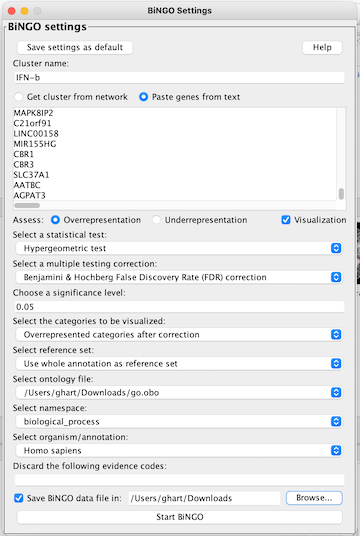

In [4]:
def make_adj(edgelist):
    G = nx.convert_matrix.from_pandas_edgelist(edgelist)
    G.edges(data=True)
    adj = nx.to_pandas_adjacency(G)

    # sets the diagonal to 1 (node can't be connected to itself)
    adj[:] = adj.values + np.eye(adj.shape[0])
    return adj
    

def adata_from_bingonx(nx_name, path_to_cyjs, path_to_bgo):
    with open(path_to_cyjs, 'r') as file:
        node_json = json.load(file)

    obs = pd.concat([pd.Series(i['data']) for i in node_json['elements']['nodes']], axis=1).T.set_index('name')
    obs.index = obs.index.astype(str)
    X_umap = pd.DataFrame([i['position'] for i in node_json['elements']['nodes']])
    X_umap['y'] = -X_umap['y']
    
    with open(path_to_bgo, 'r') as file:
        for linenum, line in enumerate(file.readlines()):
            if line.startswith('GO-ID'):
                break
    
    bgo = pd.read_csv(path_to_bgo, sep='\t', skiprows=linenum).set_index('GO-ID')
    bgo.index = bgo.index.astype(str)

    obs = obs.join(bgo)

    genes_list = [k.split('|') for k in bgo['Genes in test set']]
    genes_unique = np.unique([i for j in genes_list for i in j])

    bgo_genebool = pd.DataFrame(np.stack([[g in gl for g in genes_unique] for gl in genes_list]).T, index=genes_unique, columns=bgo.index).T
    bgo_genebool.index = bgo_genebool.index.astype(str)
    bgo_genebool = pd.concat([bgo_genebool, pd.DataFrame(False, index=np.setdiff1d(obs.index, bgo_genebool.index), columns=bgo_genebool.columns)])
    bgo_genebool = bgo_genebool.loc[obs.index].copy()


    var = bgo_genebool.columns.to_frame().drop(columns=[0])

    adata = sc.AnnData(X=bgo_genebool, var=var, obs=obs)
    adata.obsm['X_umap'] = X_umap.values # use the umap slot becuase it's easier, but maybe make a bingo slot later?
    
    adata.obs.columns = adata.obs.columns.str.replace('_%s$' % nx_name, '')
    
    for numerical_col in ['nodeSize', 'adjustedPValue', 'pValue']:
        adata.obs[numerical_col] = adata.obs[numerical_col].astype(np.float)
    
    edges = pd.concat([pd.Series(i['data']) for i in node_json['elements']['edges']], axis=1).T
    adata.uns['edges'] = edges
    adj = make_adj(edges[['source', 'target']])
    adata.obsp['connectivities'] = adj.loc[obs['id'].values, obs['id'].values]
    
    return adata

In [5]:
adata0 = adata_from_bingonx('IFN_b', sc_prefix + 'combined/bingo/IFN-b.cyjs', sc_prefix + 'combined/bingo/IFN-b.bgo')
adata1 = adata_from_bingonx('IFN_g', sc_prefix + 'combined/bingo/IFN-g.cyjs', sc_prefix + 'combined/bingo/IFN-g.bgo')

### Visualize

In [8]:
print(sc.__version__)
import anndata
print(anndata.__version__)
print(pd.__version__)

1.5.1
0.7.5
1.0.5


In [1]:
import IPython
IPython.__version__

'7.16.1'

... storing 'nodeType' as categorical
... storing 'nodeFontSize' as categorical
... storing 'nodeFillColor' as categorical
... storing 'nn' as categorical
... storing 'xx' as categorical
... storing 'selected' as categorical
... storing 'Description' as categorical
... storing 'Genes in test set' as categorical
... storing 'nodeType' as categorical
... storing 'nodeFillColor' as categorical
... storing 'nodeFontSize' as categorical
... storing 'xx' as categorical
... storing 'nn' as categorical
... storing 'selected' as categorical
... storing 'Description' as categorical
... storing 'Genes in test set' as categorical


<AxesSubplot:title={'center':'IFN-ɣ'}, xlabel='UMAP1', ylabel='UMAP2'>

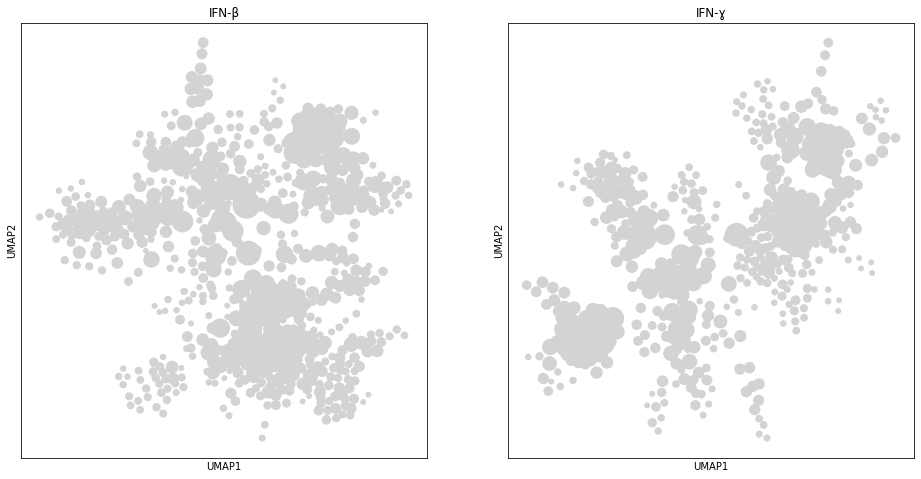

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sc.pl.umap(adata0, ax=ax[0], size=adata0.obs['nodeSize']*50, title='IFN-β', show=False, return_fig=False)
sc.pl.umap(adata1, ax=ax[1], size=adata1.obs['nodeSize']*50, title='IFN-ɣ', show=False, return_fig=False)

In [33]:
try:
    del(adata0.uns['leiden_colors'])
except:
    pass

try:
    del(adata1.uns['leiden_colors'])
except:
    pass

sc.tl.leiden(adata0, resolution=0.8, obsp='connectivities')
sc.tl.leiden(adata1, resolution=0.8, obsp='connectivities')

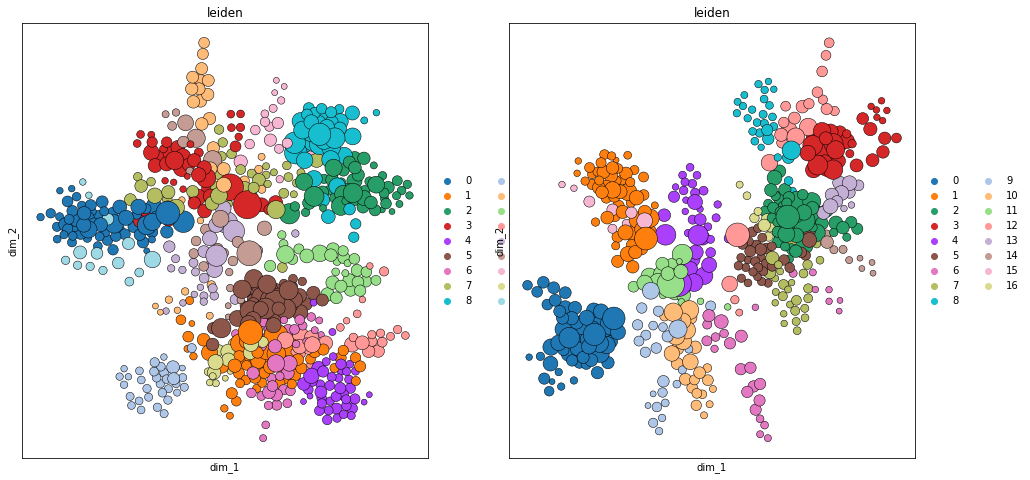

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0] = sc.pl.umap(adata0, ax=ax[0], size=adata0.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[1] = sc.pl.umap(adata1, ax=ax[1], size=adata1.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[0].set_xlabel('dim_1')
ax[0].set_ylabel('dim_2')
ax[1].set_xlabel('dim_1')
ax[1].set_ylabel('dim_2');

Make a copy now so that the Leiden clusters transfer over, because otherwise there are a bunch of totally unconnected nodes which get called as their own cluster.

In [35]:
adata0_sig = adata0[adata0.obs['adjustedPValue'] < 0.05].copy()
adata1_sig = adata1[adata1.obs['adjustedPValue'] < 0.05].copy()

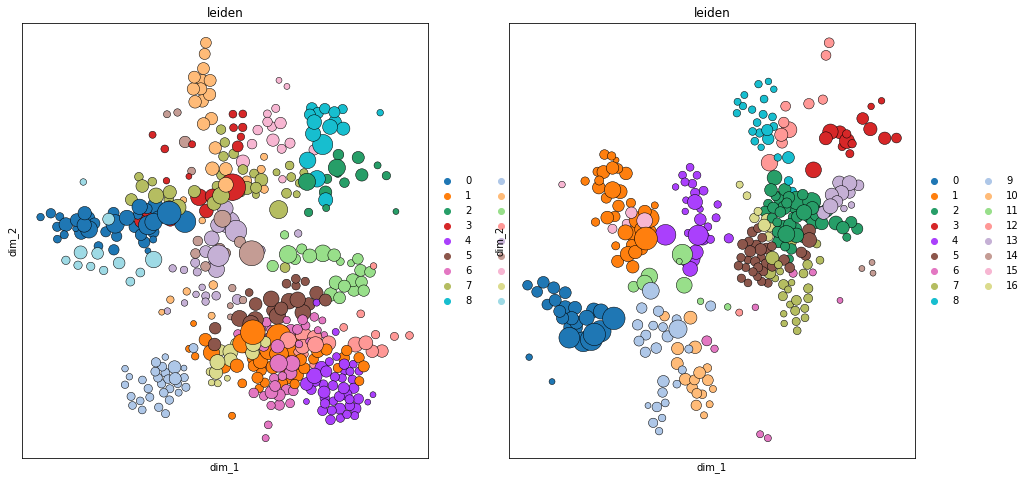

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0] = sc.pl.umap(adata0_sig, ax=ax[0], size=adata0_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[1] = sc.pl.umap(adata1_sig, ax=ax[1], size=adata1_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[0].set_xlabel('dim_1')
ax[0].set_ylabel('dim_2')
ax[1].set_xlabel('dim_1')
ax[1].set_ylabel('dim_2');

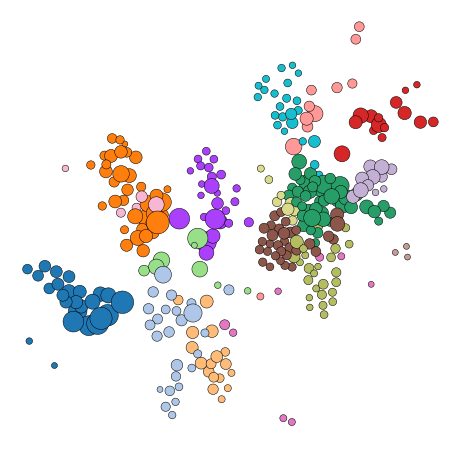

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax = sc.pl.umap(adata0_sig, ax=ax, size=adata0_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', title='', frameon=False, legend_loc=None, linewidth=0.5, show=False, return_fig=False)
ax = sc.pl.umap(adata1_sig, ax=ax, size=adata1_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', title='', frameon=False, legend_loc=None, linewidth=0.5, show=False, return_fig=False)

### Top Hits per Cluster

In [38]:
cond = 0

if cond == 0:
    top_hits = list()
    for clust in adata0_sig.obs['leiden'].cat.categories:
        top_hits.append(adata0_sig.obs[adata0_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').iloc[:3])
    top_hits_df = pd.concat(top_hits, axis=0, keys=adata0_sig.obs['leiden'].cat.categories)
    top_hits_df.to_excel(sc_prefix + 'combined/bingo/top_hits_IFNb.xlsx')
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(top_hits_df)
elif cond == 1:
    top_hits = list()
    for clust in adata1_sig.obs['leiden'].cat.categories:
        top_hits.append(adata1_sig.obs[adata1_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').iloc[:3])
    top_hits_df = pd.concat(top_hits, axis=0, keys=adata1_sig.obs['leiden'].cat.categories)
    top_hits_df.to_excel(sc_prefix + 'combined/bingo/top_hits_IFNg.xlsx')
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(top_hits_df)

description  \
   name                                                                                 
0  9607     response to biotic stimulus                                                 
   50896    response to stimulus                                                        
   43207    response to external biotic stimulus                                        
1  2682     regulation of immune system process                                         
   2684     positive regulation of immune system process                                
   51239    regulation of multicellular organismal process                              
2  2520     immune system development                                                   
   30097    hemopoiesis                                                                 
   48534    hematopoietic or lymphoid organ development                                 
3  44419    biological process involved in interspecies interaction between organisms   
   6458     'de novo' protein folding                                                   
   6935     chemotaxis                                                                  
4  51249    regulation of lymphocyte activation                                         
   70663    regulation of leukocyte proliferation                                       
   51251    positive regulation of lymphocyte activation                                
5  10628    positive regulation of gene expression                                      
   45428    regulation of nitric oxide biosynthetic process                             
   80164    regulation of nitric oxide metabolic process                                
6  48584    positive regulation of response to stimulus                                 
   50776    regulation of immune response                                               
   48583    regulation of response to stimulus                                          
7  2376     immune system process                                                       
   6955     immune response                                                             
   6952     defense response                                                            
8  46700    heterocycle catabolic process                                               
   44270    cellular nitrogen compound catabolic process                                
   19439    aromatic compound catabolic process                                         
9  1817     regulation of cytokine production                                           
   1819     positive regulation of cytokine production                                  
   32735    positive regulation of interleukin-12 production                            
10 72503    cellular divalent inorganic cation homeostasis                              
   6874     cellular calcium ion homeostasis                                            
   72507    divalent inorganic cation homeostasis                                       
11 65009    regulation of molecular function                                            
   51091    positive regulation of DNA-binding transcription factor activity            
   51092    positive regulation of NF-kappaB transcription factor activity              
12 43123    positive regulation of I-kappaB kinase/NF-kappaB signaling                  
   43122    regulation of I-kappaB kinase/NF-kappaB signaling                           
   1902533  positive regulation of intracellular signal transduction                    
13 7165     signal transduction                                                         
   7154     cell communication                                                          
   23052    signaling                                                                   
14 65007    biological regulation                                                       
   51900    regulation of mitochondrial depolarization               

### Jaccard Index of Enriched Terms

In [39]:
clusts0, clusts1 = adata0_sig.obs['leiden'].cat.categories, adata1_sig.obs['leiden'].cat.categories
jaccard_desc_df = pd.DataFrame(0, index=clusts0, columns=clusts1)
for clust0, clust1 in tqdm(it.product(clusts0, clusts1)):
    desc0 = adata0_sig.obs[adata0_sig.obs['leiden'] == clust0]['description'].values
    desc1 = adata1_sig.obs[adata1_sig.obs['leiden'] == clust1]['description'].values
    jaccard_desc_df.loc[clust0, clust1] = np.intersect1d(desc0, desc1).shape[0]/np.union1d(desc0, desc1).shape[0]

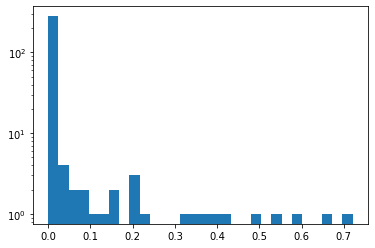

In [40]:
plt.hist(jaccard_desc_df.values.flatten(), bins=30);
plt.yscale('log');

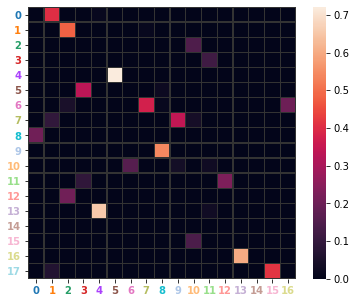

In [41]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(jaccard_desc_df, linewidth=0.25, linecolor='#333333')
yticklabels = ax.set_yticklabels(clusts0, rotation=0, fontdict={'weight':'bold'})
for yticklabel, c in zip(yticklabels, adata0.uns['leiden_colors']):
    yticklabel.set_color(c)
    
xticklabels = ax.set_xticklabels(clusts1, rotation=0, fontdict={'weight':'bold'})
for xticklabel, c in zip(xticklabels, adata1.uns['leiden_colors']):
    xticklabel.set_color(c)

### Explore Clusters

In [383]:
def compare_clusts(compare, names=None):
    if type(names) == type(None):
        names = 'cond0', 'cond1'
    # compare = (cond0_clust, cond1_clust)
    df0 = adata0_sig.obs[adata0_sig.obs['leiden'] == compare[0]][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
    df1 = adata1_sig.obs[adata1_sig.obs['leiden'] == compare[1]][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(pd.concat([df0, df1], axis=1, keys=names))
    return

def display_clust(cond, clust):
    if cond == 0:    
        df = adata0_sig.obs[adata0_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
        with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
            display(df)
    elif cond == 1:
        df = adata1_sig.obs[adata1_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
        with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
            display(df)
    return

def show_feature(adata, feature, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sc.pl.umap(adata, ax=ax, size=adata.obs['nodeSize']*50, color=feature, edgecolor='k', linewidth=0.5, show=False, return_fig=False)
    ax.set_xlabel('dim_1')
    ax.set_ylabel('dim_2')
    return ax

def get_genes(adata, clust):
    print(adata.var[adata[adata.obs['leiden'] == clust].X.any(0)].index.tolist())
    return

def GO_de_genes(cond, GO_id, p=False, disp=True):
    if cond == 0:
        print(adata0_sig.obs.loc[focus_GO, 'description'])
        genes = adata0_sig.obs.loc[focus_GO]['Genes in test set'].split('|')
        genes = np.intersect1d(dem['compare'].index.values, genes) # this is to fix the "orf" issue, BINGO returning genes all capitalized
        if p:
            dem_focusgo = dem['compare'].loc[genes].sort_values(by='p0')
        else:
            dem_focusgo = dem['compare'].loc[genes].sort_values(by='l0', ascending=False)
        if disp:
            display(dem_focusgo)
    elif cond == 1:
        print(adata1_sig.obs.loc[focus_GO, 'description'])
        genes = adata1_sig.obs.loc[focus_GO]['Genes in test set'].split('|')
        genes = np.intersect1d(dem['compare'].index.values, genes) # this is to fix the "orf" issue, BINGO returning genes all capitalized
        if p:
            dem_focusgo = dem['compare'].loc[genes].sort_values(by='p1')
        else:
            dem_focusgo = dem['compare'].loc[genes].sort_values(by='l1', ascending=False)
        if disp:
            display(dem_focusgo)
    return dem_focusgo

def check_string(cond, string):
    if cond == 0:
        print(adata0_sig.obs['description'].str.contains(string).sum())
        display(adata0_sig.obs[adata0_sig.obs['description'].str.contains(string)][['description', 'adjustedPValue']].sort_values(by='adjustedPValue'))
    elif cond == 1:
        print(adata1_sig.obs['description'].str.contains(string).sum())
        display(adata1_sig.obs[adata1_sig.obs['description'].str.contains(string)][['description', 'adjustedPValue']].sort_values(by='adjustedPValue'))
    return

In [43]:
adata0_sp = np.setdiff1d(adata0_sig.obs['description'], adata1_sig.obs['description'])
adata1_sp = np.setdiff1d(adata1_sig.obs['description'], adata0_sig.obs['description'])

In [44]:
compare = ('17', '15')
compare_clusts(compare, names=['beta', 'gamma'])

beta                                                                    \
       name                                                       description   
0   34097    response to cytokine                                               
1   7166     cell surface receptor signaling pathway                            
2   19221    cytokine-mediated signaling pathway                                
3   71345    cellular response to cytokine stimulus                             
4   7259     receptor signaling pathway via JAK-STAT                            
5   97696    receptor signaling pathway via STAT                                
6   7169     transmembrane receptor protein tyrosine kinase signaling pathway   
7   1990868  response to chemokine                                              
8   1990869  cellular response to chemokine                                     
9   70098    chemokine-mediated signaling pathway                               
10  60397    growth hormone receptor signaling pathway via JAK-STAT             
11  34612    response to tumor necrosis factor                                  

                   gamma  \
   adjustedPValue   name   
0   4.036300e-09   19221   
1   7.541900e-07   7259    
2   1.770600e-06   97696   
3   4.781200e-06   7166    
4   8.199300e-04   60397   
5   8.199300e-04   NaN     
6   2.452700e-03   NaN     
7   3.187700e-03   NaN     
8   3.187700e-03   NaN     
9   3.187700e-03   NaN     
10  1.601100e-02   NaN     
11  4.390200e-02   NaN     

                                                                           
                                               description adjustedPValue  
0   cytokine-mediated signaling pathway                     0.000014       
1   receptor signaling pathway via JAK-STAT                 0.000094       
2   receptor signaling pathway via STAT                     0.000094       
3   cell surface receptor signaling pathway                 0.000257       
4   growth hormone receptor signaling pathway via JAK-STAT  0.015270       
5   NaN                                                    NaN             
6   NaN                                                    NaN             
7   NaN                                                    NaN             
8   NaN                                                    NaN             
9   NaN                                                    NaN             
10  NaN                                                    NaN             
11  NaN                                                    NaN

In [45]:
cond = 0
clust = '11'
display_clust(cond, clust)

name                                                       description  \
0   65009  regulation of molecular function                                   
1   51091  positive regulation of DNA-binding transcription factor activity   
2   51092  positive regulation of NF-kappaB transcription factor activity     
3   44093  positive regulation of molecular function                          
4   51090  regulation of DNA-binding transcription factor activity            
5   50790  regulation of catalytic activity                                   
6   31399  regulation of protein modification process                         
7   45937  positive regulation of phosphate metabolic process                 
8   42327  positive regulation of phosphorylation                             
9   33674  positive regulation of kinase activity                             
10  19220  regulation of phosphate metabolic process                          
11  42325  regulation of phosphorylation                                      
12  10922  positive regulation of phosphatase activity                        
13  43549  regulation of kinase activity                                      
14  43085  positive regulation of catalytic activity                          
15  10921  regulation of phosphatase activity                                 
16  31401  positive regulation of protein modification process                
17  1932   regulation of protein phosphorylation                              
18  51347  positive regulation of transferase activity                        
19  1934   positive regulation of protein phosphorylation                     
20  43393  regulation of protein binding                                      

    adjustedPValue  
0   9.151700e-07    
1   1.244900e-06    
2   4.531500e-06    
3   4.800600e-05    
4   6.693600e-05    
5   1.494600e-04    
6   5.649100e-03    
7   6.341300e-03    
8   1.278000e-02    
9   1.345100e-02    
10  1.761300e-02    
11  2.173700e-02    
12  2.445200e-02    
13  2.754900e-02    
14  2.840100e-02    
15  3.244300e-02    
16  3.562000e-02    
17  3.673000e-02    
18  3.912300e-02    
19  4.116300e-02    
20  4.390200e-02

In [46]:
get_genes(adata0_sig, '4')

['ABI1', 'ADA', 'ADM', 'ADRB2', 'ANG', 'ARNT2', 'ASCL2', 'ATF3', 'BCL11B', 'BCL2', 'BMPR2', 'BRCA2', 'CALCRL', 'CARD11', 'CASP3', 'CBLB', 'CCL2', 'CCNA2', 'CD164', 'CD274', 'CD38', 'CD40', 'CD40LG', 'CD47', 'CD74', 'CD80', 'CD83', 'CD86', 'CDC25B', 'CDKN1C', 'CNP', 'CUL1', 'CXCL10', 'DISC1', 'EDN1', 'EIF2AK2', 'FANCA', 'GIMAP5', 'GRN', 'HLX', 'HMOX1', 'HSPA1A', 'HSPA1B', 'HSPD1', 'IDO1', 'IFITM1', 'IGF1', 'IL10', 'IL12RB1', 'IL15', 'IL27', 'IL7', 'IL7R', 'INPP5D', 'ITGA2', 'JAK2', 'KAT2B', 'KITLG', 'KLF11', 'LAG3', 'LIFR', 'LRP5', 'LYN', 'MALT1', 'MORC3', 'NBN', 'PDCD1LG2', 'PELI1', 'PLA2G4A', 'PML', 'PPP2R5C', 'PTGER2', 'PTK2B', 'RARRES3', 'RB1', 'RELA', 'RIPK2', 'SCIN', 'SLAMF1', 'SLAMF7', 'SMAD1', 'SP110', 'SPN', 'SSTR2', 'STAT1', 'STAT5A', 'TBX19', 'TCF4', 'TEP1', 'TICAM1', 'TIMP1', 'TINF2', 'TLR4', 'TNFRSF11A', 'TNFSF13B', 'TPD52L2', 'TXNIP', 'WARS']


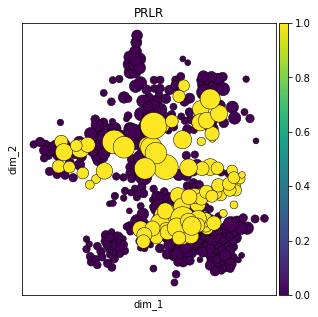

In [47]:
show_feature(adata0_sig, 'PRLR', figsize=(5, 5));

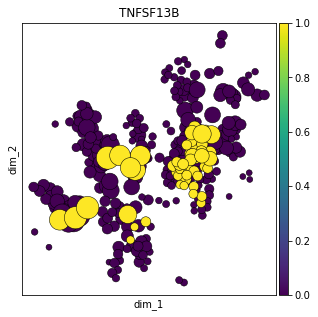

In [48]:
show_feature(adata1_sig, 'TNFSF13B', figsize=(5, 5));

In [49]:
cond = 0
clust = '15'
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    if cond == 0:
        df = adata0_sig.obs[adata0_sig.obs['description'].isin(np.intersect1d(adata0_sig.obs[adata0_sig.obs['leiden'] == clust]['description'], adata0_sp))][['description', 'adjustedPValue']].sort_values(by='adjustedPValue')
        display(df)
    elif cond == 1:
        df = adata1_sig.obs[adata1_sig.obs['description'].isin(np.intersect1d(adata1_sig.obs[adata1_sig.obs['leiden'] == clust]['description'], adata1_sp))][['description', 'adjustedPValue']].sort_values(by='adjustedPValue')
        display(df)

description  adjustedPValue
name                                                 
32943  mononuclear cell proliferation  0.000007      
70661  leukocyte proliferation         0.000010      
46651  lymphocyte proliferation        0.000022      
42100  B cell proliferation            0.001461      
8283   cell population proliferation   0.002237      
42098  T cell proliferation            0.007497      
42113  B cell activation               0.018023      
30217  T cell differentiation          0.032753      
45058  T cell selection                0.036184      
1866   NK T cell proliferation         0.045249      
51132  NK T cell activation            0.045249

In [50]:
cond = 0
focus_GO = '46651'
dem_focusgo = GO_de_genes(cond, focus_GO)

lymphocyte proliferation


l0            p0        l1            p1
IL15    2.104346  3.503419e-25  2.452570  5.534698e-36
P2RX7   1.439341  4.509384e-08  2.812273  5.927508e-31
CD40    1.396588  1.439536e-07  2.905860  1.806545e-30
RIPK2   1.386253  2.319676e-09  1.708715  7.286093e-15
FKBP1B  0.864003  1.179473e-06 -0.141718  6.522561e-01
IL7R    0.800231  4.857471e-03  0.467854  1.491628e-01
CD86    0.757589  9.401583e-03  1.119106  1.877666e-05
ELF4    0.709782  3.705666e-05  0.320877  9.085353e-02
MALT1   0.668699  1.085236e-03  0.319392  1.759531e-01
IL10    0.613477  1.255611e-02 -1.974266  1.048100e-19
HSPD1   0.584035  1.822157e-02  0.407510  1.426276e-01
BCL2    0.560431  3.589348e-03  0.204818  3.702663e-01
CD40LG  0.551029  1.117576e-02  0.367167  1.565231e-01

In [51]:
protein = False
features = dem_focusgo.index.values

if not protein:
    df_plot = m_plot
    vlim = (-2, 2)
else:
    df_plot = a_plot
    vlim = (-0.5, 0.5)

In [52]:
sig_params = {
    'bins': [5e-2, 1e-2, 1e-5, 1e-10, 1e-30, 1e-50],
    'dot_size_range': (0.3, 15)
}
bubble_plot_arr, df_plot, len_dict, gene_order = make_bubble_arr(df_plot, features, focus_dx, sig_params=sig_params)

In [53]:
plot_params = {
    'height': 1.25,
    'ylim_buffer': 0.5,
    'height_ratios': [3, .5],
    'linewidth': 5
}

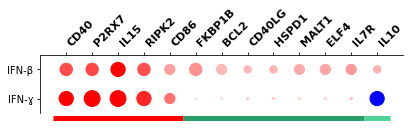

In [54]:
bubble_plotter(bubble_plot_arr, len_dict, gene_order, protein=protein, plot_params=plot_params)

In [55]:
cond = 1
string = 'NF'
check_string(cond, string)

4


description  adjustedPValue
name                                                                    
43122  regulation of I-kappaB kinase/NF-kappaB signaling        0.000002
43123  positive regulation of I-kappaB kinase/NF-kapp...        0.000003
51092  positive regulation of NF-kappaB transcription...        0.000047
7249                 I-kappaB kinase/NF-kappaB signaling        0.008859

In [56]:
shared = np.intersect1d(adata1_sig.obs['description'], adata0_sig.obs['description'])

In [111]:
df0 = adata0_sig.obs[adata0_sig.obs['description'].isin(shared)][['description', 'adjustedPValue', 'leiden']].set_index('description', drop=True)
df1 = adata1_sig.obs[adata1_sig.obs['description'].isin(shared)][['description', 'adjustedPValue', 'leiden']].set_index('description', drop=True)
df_joined = df0.join(df1, lsuffix='-0', rsuffix='-1')
pvalcols = ['adjustedPValue-0', 'adjustedPValue-1']
df_joined[pvalcols] = -np.log10(df_joined[pvalcols])

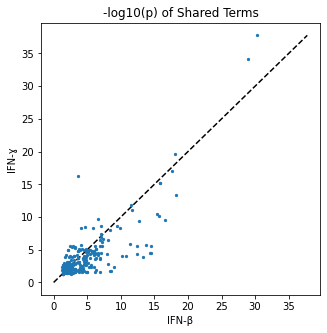

In [112]:
plt.figure(figsize=(5, 5))
plt.title('-log10(p) of Shared Terms')
x, y = df_joined[pvalcols].values.T
maxlim = max(x.max(), y.max())
plt.plot([0, maxlim], [0, maxlim], linestyle='--', color='k', zorder=0)
plt.scatter(x, y, s=5);
plt.xlabel('IFN-β')
plt.ylabel('IFN-ɣ');

In [113]:
df_joined.shape

(249, 4)

In [414]:
df_joined.sort_values(['leiden-0', 'adjustedPValue-0'], ascending=[True, False]).head(250).tail(20)

adjustedPValue-0 leiden-0  \
description                                                                     
T cell activation                                           6.338594       15   
lymphocyte differentiation                                  2.408824       15   
mononuclear cell differentiation                            2.351445       15   
regulation of apoptotic process                             7.344103       16   
regulation of cell death                                    7.103132       16   
regulation of programmed cell death                         7.057352       16   
negative regulation of apoptotic process                    4.903994       16   
negative regulation of cell death                           4.850504       16   
negative regulation of programmed cell death                4.756292       16   
positive regulation of cell death                           2.100623       16   
positive regulation of apoptotic process                    1.791586       16   
positive regulation of programmed cell death                1.639691       16   
response to cytokine                                        8.394017       17   
cell surface receptor signaling pathway                     6.122519       17   
cytokine-mediated signaling pathway                         5.751880       17   
cellular response to cytokine stimulus                      5.320463       17   
receptor signaling pathway via JAK-STAT                     3.086223       17   
receptor signaling pathway via STAT                         3.086223       17   
growth hormone receptor signaling pathway via J...          1.795582       17   
response to tumor necrosis factor                           1.357516       17   

                                                    adjustedPValue-1 leiden-1  
description                                                                    
T cell activation                                           3.795310       10  
lymphocyte differentiation                                  1.866078       10  
mononuclear cell differentiation                            3.118056       10  
regulation of apoptotic process                             6.576852       13  
regulation of cell death                                    7.440944       13  
regulation of programmed cell death                         6.972569       13  
negative regulation of apoptotic process                    4.231399       13  
negative regulation of cell death                           3.899147       13  
negative regulation of programmed cell death                4.086425       13  
positive regulation of cell death                           4.999696       13  
positive regulation of apoptotic process                    2.854741       13  
positive regulation of programmed cell death                3.899147       13  
response to cytokine                                        8.010239        1  
cell surface receptor signaling pathway                     3.590659       15  
cytokine-mediated signaling pathway                         4.868959       15  
cellular response to cytokine stimulus                      4.944622        1  
receptor signaling pathway via JAK-STAT                     4.027908       15  
receptor signaling pathway via STAT                         4.027908       15  
growth hormone receptor signaling pathway via J...          1.816161       15  
response to tumor necrosis factor                           1.492603        1

In [422]:
cond = 0
string = 'receptor signaling pathway via JAK-STAT'
check_string(cond, string)

3


description  adjustedPValue
name                                                                    
7259             receptor signaling pathway via JAK-STAT        0.000820
60397  growth hormone receptor signaling pathway via ...        0.016011
46425  regulation of receptor signaling pathway via J...        0.045249

In [424]:
cond = 0
focus_GO = '7259'
dem_focusgo = GO_de_genes(cond, focus_GO);

receptor signaling pathway via JAK-STAT


l0            p0        l1            p1
PRLR    3.235560  1.218342e-49  1.015174  5.830129e-07
JAK2    2.566552  1.319093e-31  2.644794  7.224051e-33
STAT2   2.359837  4.318613e-27  1.308865  1.153809e-09
CCL2    2.283633  6.954113e-11 -1.080741  8.084046e-03
SOCS1   2.250790  4.651811e-25  4.367945  1.651798e-91
NMI     2.103766  2.908661e-22  1.239287  3.614930e-09
STAT1   1.338375  2.096427e-06  1.608579  3.463692e-09
STAT3   0.793271  4.113866e-04  0.910724  3.841242e-05
STAT5A  0.742109  7.157905e-05  1.104740  5.581889e-10
STAT4   0.621351  4.544112e-04  0.730122  3.870197e-05

In [425]:
features = np.unique(GO_de_genes(0, focus_GO, disp=False).index.tolist() + GO_de_genes(1, focus_GO, disp=False).index.tolist())
print(len(features))

receptor signaling pathway via JAK-STAT
receptor signaling pathway via JAK-STAT
12


In [426]:
protein = False

if not protein:
    df_plot = m_plot
    vlim = (-2, 2)
else:
    df_plot = a_plot
    vlim = (-0.5, 0.5)

In [427]:
sig_params = {
    'bins': [5e-2, 1e-2, 1e-5, 1e-10, 1e-30, 1e-50],
    'dot_size_range': (0.3, 15)
}
bubble_plot_arr, df_plot, len_dict, gene_order = make_bubble_arr(df_plot, features, focus_dx, sig_params=sig_params)

In [428]:
plot_params = {
    'height': 1.25,
    'ylim_buffer': 0.5,
    'height_ratios': [3, .5],
    'linewidth': 5
}

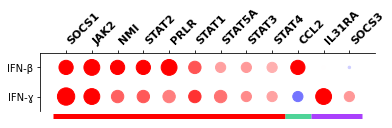

In [429]:
bubble_plotter(bubble_plot_arr, len_dict, gene_order, protein=protein, plot_params=plot_params)

In [246]:
gaf = pd.read_csv(sc_prefix + 'combined/bingo/goa_human.gaf', sep='\t', comment='!', 
                        header=None, low_memory=False)
goa_human.columns = ['db', 'db_object_id', 'db_object_symbol', 'qualifier', 'go_id', 'db:reference', 'evidence_code', 'with_from', 'aspect', 'db_object_name', 'db_object_synonym', 'db_object_type', 'taxon', 'date', 'assigned_by', 'annotation_extension', 'gene_product_form_id']

In [253]:
gpad = pd.read_csv(sc_prefix + 'combined/bingo/goa_human.gpad', sep='\t', comment='!', 
                        header=None, low_memory=False)

In [255]:
gpad[3]

0         GO:0003723
1         GO:0046872
2         GO:0052840
3         GO:0052842
4         GO:0005829
             ...    
624129    GO:0042127
624130    GO:0007165
624131    GO:0005730
624132    GO:1904153
624133    GO:0000981
Name: 3, Length: 624134, dtype: object

In [246]:
goa_human.columns = ['db', 'db_object_id', 'db_object_symbol', 'qualifier', 'go_id', 'db:reference', 'evidence_code', 'with_from', 'aspect', 'db_object_name', 'db_object_synonym', 'db_object_type', 'taxon', 'date', 'assigned_by', 'annotation_extension', 'gene_product_form_id']

In [247]:
goa_human[((goa_human['go_id'] == 'GO:' + focus_GO.zfill(7)))]

In [257]:
focus_GO.zfill(7)

'0002250'

In [252]:
def get_child_terms(focus_GO):
    ids = list()    
    for i in genes:
        try:
            ids.append(symbol2geneid[i])
        except KeyError:
            continue
            
    percent_genes_in_annot = len(ids)/len(genes)
    
    topfun_data = '{"Genes":[' + ','.join([str(i) for i in ids]) + '], ' + category_text + '}'
    response = requests.post(topfun_url, 
                             headers=topfun_headers, 
                             data=topfun_data)
    results = pd.DataFrame(response.json()['Annotations'])
    results['-log10FDR'] = -np.log10(results['QValueFDRBH'])
    results['Genes'] = [",".join([j['Symbol'].strip("'") for j in i]) for i in results['Genes']]
    return percent_genes_in_annot, results

In [278]:
def get_children()
quickgo_url = 'https://www.ebi.ac.uk/QuickGO/services/'
children_sub = 'ontology/go/terms/GO%s/children' % ('%3A' + focus_GO.zfill(7))
children = requests.get(quickgo_url + children_sub, headers={ "Accept" : "application/json"}).text

In [279]:
children

'{"numberOfHits":1,"results":[{"id":"GO:0002250","name":"adaptive immune response","children":[{"id":"GO:0039504","name":"suppression by virus of host adaptive immune response","relation":"negatively_regulates","hasChildren":true},{"id":"GO:0090718","name":"adaptive immune effector response","relation":"is_a","hasChildren":true},{"id":"GO:0090716","name":"adaptive immune memory response","relation":"is_a","hasChildren":true},{"id":"GO:0090720","name":"primary adaptive immune response","relation":"is_a","hasChildren":true},{"id":"GO:0002460","name":"adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains","relation":"is_a","hasChildren":true},{"id":"GO:0002459","name":"adaptive immune response based on somatic recombination of immune receptors built from leucine-rich repeat domains","relation":"is_a","hasChildren":false},{"id":"GO:0002819","name":"regulation of adaptive immune response","relation":"regulates","hasChildren

In [274]:
responseBody = r.text
print(responseBody)

In [275]:
responseBody

'{"numberOfHits":1,"results":[{"id":"GO:0002250","name":"adaptive immune response","children":[{"id":"GO:0039504","name":"suppression by virus of host adaptive immune response","relation":"negatively_regulates","hasChildren":true},{"id":"GO:0090718","name":"adaptive immune effector response","relation":"is_a","hasChildren":true},{"id":"GO:0090716","name":"adaptive immune memory response","relation":"is_a","hasChildren":true},{"id":"GO:0090720","name":"primary adaptive immune response","relation":"is_a","hasChildren":true},{"id":"GO:0002460","name":"adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains","relation":"is_a","hasChildren":true},{"id":"GO:0002459","name":"adaptive immune response based on somatic recombination of immune receptors built from leucine-rich repeat domains","relation":"is_a","hasChildren":false},{"id":"GO:0002819","name":"regulation of adaptive immune response","relation":"regulates","hasChildren

In [252]:
goa_human[goa_human['db_object_symbol'] == 'INPP5D']

db db_object_id db_object_symbol    qualifier       go_id  \
415353  UniProtKB       Q92835           INPP5D      enables  GO:0004439   
415354  UniProtKB       Q92835           INPP5D      enables  GO:0004439   
415355  UniProtKB       Q92835           INPP5D      enables  GO:0004445   
415356  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415357  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415358  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415359  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415360  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415361  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415362  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415363  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415364  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415365  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415366  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415367  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415368  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415369  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415370  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415371  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415372  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415373  UniProtKB       Q92835           INPP5D      enables  GO:0005515   
415374  UniProtKB       Q92835           INPP5D      enables  GO:0016314   
415375  UniProtKB       Q92835           INPP5D      enables  GO:0017124   
415376  UniProtKB       Q92835           INPP5D      enables  GO:0034485   
415377  UniProtKB       Q92835           INPP5D      enables  GO:0052658   
415378  UniProtKB       Q92835           INPP5D      enables  GO:0052659   
415379  UniProtKB       Q92835           INPP5D      enables  GO:0052659   
415380  UniProtKB       Q92835           INPP5D  involved_in  GO:0006661   
415381  UniProtKB       Q92835           INPP5D  involved_in  GO:0006796   
415382  UniProtKB       Q92835           INPP5D  involved_in  GO:0006915   
415383  UniProtKB       Q92835           INPP5D  involved_in  GO:0007165   
415384  UniProtKB       Q92835           INPP5D  involved_in  GO:0008340   
415385  UniProtKB       Q92835           INPP5D  involved_in  GO:0009968   
415386  UniProtKB       Q92835           INPP5D  involved_in  GO:0016064   
415387  UniProtKB       Q92835           INPP5D  involved_in  GO:0030889   
415388  UniProtKB       Q92835           INPP5D  involved_in  GO:0032715   
415389  UniProtKB       Q92835           INPP5D  involved_in  GO:0035556   
415390  UniProtKB       Q92835           INPP5D  involved_in  GO:0043065   
415391  UniProtKB       Q92835           INPP5D  involved_in  GO:0045579   
415392  UniProtKB       Q92835           INPP5D  involved_in  GO:0045648   
415393  UniProtKB       Q92835           INPP5D  involved_in  GO:0045656   
415394  UniProtKB       Q92835           INPP5D  involved_in  GO:0045659   
415395  UniProtKB       Q92835           INPP5D  involved_in  GO:0045671   
415396  UniProtKB       Q92835           INPP5D  involved_in  GO:0045779   
415397  UniProtKB       Q92835           INPP5D  involved_in  GO:0046856   
415398  UniProtKB       Q92835           INPP5D  involved_in  GO:0050777   
415399  UniProtKB       Q92835           INPP5D  involved_in  GO:0050852   
415400  UniProtKB       Q92835           INPP5D   located_in  GO:0005829   
415401  UniProtKB       Q92835           INPP5D   located_in  GO:0005829   
415402  UniProtKB       Q92835           INPP5D   located_in  GO:0005829   
415403  UniProtKB       Q92835           INPP5D   located_in  GO:0005829   
415404  UniProtKB       Q92835           INPP5D   located_in  G

In [248]:
goa_human[((goa_human['go_id'] == 'GO:' + focus_GO.zfill(7)))]['db_object_symbol'].unique()

array(['IGKV3-7', 'IGKV1D-42', 'IGLV4-69', 'IGLV8-61', 'IGLV4-60',
       'IGLV11-55', 'IGLV10-54', 'IGLV1-50', 'IGLV5-48', 'IGLV7-46',
       'IGLV5-37', 'IGLV2-33', 'IGLV3-22', 'IGLV2-18', 'IGLV3-16',
       'IGLV3-12', 'IGLV3-10', 'IGLV3-9', 'IGLV4-3', 'TRGV11', 'TRBV7-3',
       'TRBV19', 'TRBV20-1', 'TRBV24-1', 'TRBV25-1', 'IGKV2-28', 'TRGV2',
       'IGKV2D-24', 'TRGJ1', 'IGKV2D-29', 'IGKV1D-17', 'IGKV1-27',
       'IGKV2D-30', 'IGKV1-37', 'TRAV12-2', 'TRAV6', 'TRAV9-1', 'TRAV7',
       'TRAV36DV7', 'TRAV23DV6', 'TRAV18', 'TRAJ3', 'TRAJ42', 'TRAJ31',
       'TRDJ1', 'IGLV5-45', 'IGKV3D-15', 'IGKV1D-8', 'TRAV30', 'TRAV27',
       'TRAV9-2', 'TRAV26-1', 'TRBV16', 'IGKV2-40', 'TRBV17', 'TRBV18',
       'IGKV2D-26', 'IGKV3D-11', 'IGLV5-52', 'IGLV3-32', 'TRGV10',
       'TRGV1', 'TRBV5-3', 'TRBV6-7', 'TRBV5-7', 'TRBV23-1', 'IGKV6D-21',
       'TRBJ2-6', 'IGLJ1', 'TRBJ2-7', 'TRBJ2-4', 'IGKJ1', 'TRBJ2-2',
       'TRBJ2-5', 'TRBJ2-1', 'TRAV14DV4', 'TRBV13', 'TRBV6-6', 'TRBV6-8',
       '

In [225]:
request

'0002250'

In [788]:
nodes = pd.read_csv(sc_prefix + 'combined/bingo_gomcl/IFN-b_nodes.csv')

In [789]:
edges = pd.read_csv(sc_prefix + 'combined/bingo_gomcl/IFN-b_edges.csv')

In [917]:
edges

edgeType_IFN-b interaction               name  selected  \
0             black          pp   10562 (pp) 45937     False   
1             black          pp   65008 (pp) 42592     False   
2             black          pp  9966 (pp) 1904892     False   
3             black          pp   65007 (pp) 50789     False   
4             black          pp   19221 (pp) 70098     False   
...             ...         ...                ...       ...   
1017          black          pp     6875 (pp) 6874     False   
1018          black          pp     3013 (pp) 3018     False   
1019          black          pp   44237 (pp) 44248     False   
1020          black          pp     2366 (pp) 2275     False   
1021          black          pp     9987 (pp) 7154     False   

     shared interaction        shared name  Similarity (OC)  
0                    pp   10562 (pp) 45937              NaN  
1                    pp   65008 (pp) 42592              NaN  
2                    pp  9966 (pp) 1904892              NaN  
3                    pp   65007 (pp) 50789              NaN  
4                    pp   19221 (pp) 70098              NaN  
...                 ...                ...              ...  
1017                 pp     6875 (pp) 6874              NaN  
1018                 pp     3013 (pp) 3018              NaN  
1019                 pp   44237 (pp) 44248              NaN  
1020                 pp     2366 (pp) 2275              NaN  
1021                 pp     9987 (pp) 7154              NaN  

[1022 rows x 7 columns]

In [956]:
import json

In [1011]:

node_positions.index = node_positions.index.astype(np.int)

In [1013]:
bingo_b_adata = sc.AnnData(np.zeros((len(nodes), 1)), obs=nodes.set_index('name').join(node_positions), var=pd.DataFrame(index=['None']))

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [1014]:
bingo_b_adata.obs

adjustedPValue_IFN-b  \
name                          
10562              0.008452   
45937              0.008452   
65008              0.003533   
42592              0.000126   
9966               0.000011   
...                     ...   
2275               0.238030   
45471              0.033889   
42113              0.027860   
48284              0.044945   
6986               0.000002   

                                       description_IFN-b  N_IFN-b  nn_IFN-b  \
name                                                                          
10562  positive regulation of phosphorus metabolic pr...    14399       269   
45937  positive regulation of phosphate metabolic pro...    14399       269   
65008                   regulation of biological quality    14399      1472   
42592                                homeostatic process    14399       684   
9966                   regulation of signal transduction    14399       915   
...                                                  ...      ...       ...   
2275   myeloid cell activation involved in immune res...    14399        20   
45471                                response to ethanol    14399        76   
42113                                  B cell activation    14399        74   
48284                                   organelle fusion    14399        16   
6986                        response to unfolded protein    14399        67   

       nodeFillColor_IFN-b  nodeFontSize_IFN-b  nodeSize_IFN-b nodeType_IFN-b  \
name                                                                            
10562             2.073033                  14       11.832160        ellipse   
45937             2.073033                  14       11.832160        ellipse   
65008             2.451838                  14       23.832751        ellipse   
42592             3.898584                  14       18.110770        ellipse   
9966              4.958361                  14       20.784610        ellipse   
...                    ...                 ...             ...            ...   
2275              0.623366                  14        4.000000        ellipse   
45471             1.469947                  14        7.211103        ellipse   
42113             1.555017                  14        7.211103        ellipse   
48284             1.347314                  14        4.472136        ellipse   
6986              5.752839                  14        8.944272        ellipse   

       pValue_IFN-b  selected  shared name  X_IFN-b  xx_IFN-b            x  \
name                                                                         
10562  5.337400e-04     False        10562     1044        35  -454.973968   
45937  5.337400e-04     False        45937     1044        35  -278.117019   
65008  1.881000e-04     False        65008     1044       142   -26.006118   
42592  3.755100e-06     False        42592     1044        82   136.594026   
9966   2.181500e-07     False         9966     1044       108  -889.814605   
...             ...       ...          ...      ...       ...          ...   
2275   5.239000e-02     False         2275     1044         4  1114.219392   
45471  2.999100e-03     False        45471     1044        13   890.390656   
42113  2.350000e-03     False        42113     1044        13   744.776216   
48284  4.412700e-03     False        48284     1044         5   202.300996   
6986   2.931600e-08     False         6986     1044        20  1139.098176   

                 y  
name                
10562  -569.692072  
45937  -654.296503  
65008   212.480116  
42592    12.273306  
9966     -9.775934  
...            ...  
2275    670.544989  
45471  -279.652002  
42113  1013.840948  
48284   907.896918  
6986    119.534489  

[604 rows x 15 columns]

In [1016]:
bingo_b_adata.obsm['X_umap'] = bingo_b_adata.obs[['x', 'y']].values

In [1017]:
bingo_b_adata

AnnData object with n_obs × n_vars = 604 × 1
    obs: 'adjustedPValue_IFN-b', 'description_IFN-b', 'N_IFN-b', 'nn_IFN-b', 'nodeFillColor_IFN-b', 'nodeFontSize_IFN-b', 'nodeSize_IFN-b', 'nodeType_IFN-b', 'pValue_IFN-b', 'selected', 'shared name', 'X_IFN-b', 'xx_IFN-b', 'x', 'y'
    obsm: 'X_umap'
    obsp: 'connectivities'

In [1019]:
bingo_b_adata_sig = bingo_b_adata[bingo_b_adata.obs['adjustedPValue_IFN-b'] < 0.05].copy()

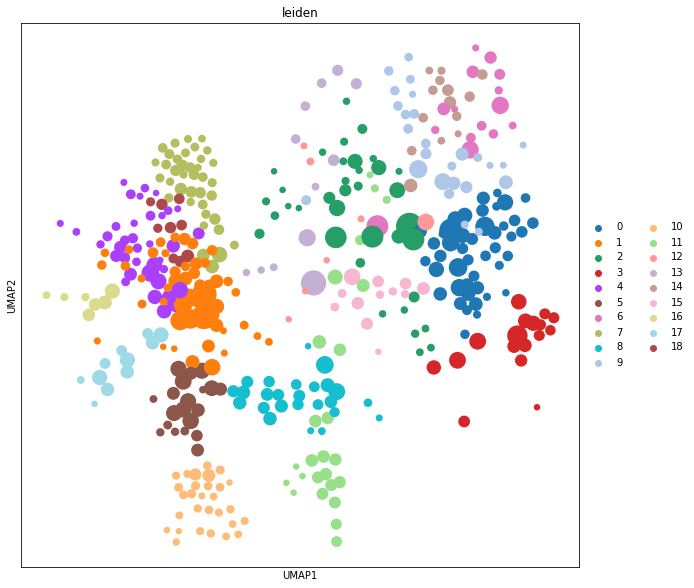

In [1035]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(bingo_b_adata_sig, ax=ax, size=bingo_b_adata_sig.obs['nodeSize_IFN-b']*50, color='leiden')

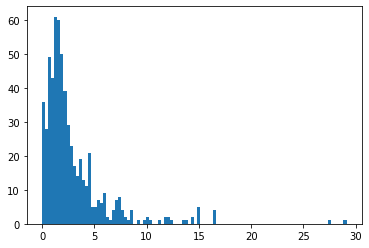

In [1033]:
plt.hist(-np.log10(bingo_b_adata.obs['adjustedPValue_IFN-b']), bins=100);

In [1037]:
bingo_b_adata.obs[bingo_b_adata.obs['leiden'] == '16'].sort_values(by='adjustedPValue_IFN-b')

adjustedPValue_IFN-b  \
name                            
43123            3.346500e-15   
43122            2.214300e-14   
1902533          3.931100e-13   
1902531          8.767300e-11   
70304            7.729500e-03   
32874            2.414800e-02   
46330            3.390100e-02   
46328            7.096800e-02   
70302            7.580400e-02   
43410            1.072800e-01   
32872            1.437300e-01   
80135            2.010900e-01   
43408            2.773800e-01   

                                         description_IFN-b  N_IFN-b  nn_IFN-b  \
name                                                                            
43123    positive regulation of I-kappaB kinase/NF-kapp...    14399       115   
43122    regulation of I-kappaB kinase/NF-kappaB signaling    14399       127   
1902533  positive regulation of intracellular signal tr...    14399       282   
1902531    regulation of intracellular signal transduction    14399       516   
70304    positive regulation of stress-activated protei...    14399        27   
32874    positive regulation of stress-activated MAPK c...    14399        26   
46330                   positive regulation of JNK cascade    14399        21   
46328                            regulation of JNK cascade    14399        41   
70302    regulation of stress-activated protein kinase ...    14399        50   
43410                  positive regulation of MAPK cascade    14399       112   
32872          regulation of stress-activated MAPK cascade    14399        49   
80135            regulation of cellular response to stress    14399        94   
43408                           regulation of MAPK cascade    14399       165   

         nodeFillColor_IFN-b  nodeFontSize_IFN-b  nodeSize_IFN-b  \
name                                                               
43123              14.475411                  14       12.649111   
43122              13.654768                  14       12.806248   
1902533            12.405486                  14       15.748016   
1902531            10.057134                  14       18.439089   
70304               2.111849                  14        5.656854   
32874               1.617116                  14        5.291503   
46330               1.469783                  14        4.898979   
46328               1.148936                  14        5.656854   
70302               1.120310                  14        6.000000   
43410               0.969481                  14        7.745967   
32872               0.842465                  14        5.656854   
80135               0.696605                  14        6.928203   
43408               0.556932                  14        8.246211   

        nodeType_IFN-b  pValue_IFN-b  selected  shared name  X_IFN-b  \
name                                                                   
43123          ellipse  9.255100e-18     False        43123     1044   
43122          ellipse  7.654800e-17     False        43122     1044   
1902533        ellipse  1.449600e-15     False      1902533     1044   
1902531        ellipse  4.647300e-13     False      1902531     1044   
70304          ellipse  4.754600e-04     False        70304     1044   
32874          ellipse  1.998000e-03     False        32874     1044   
46330          ellipse  3.015900e-03     False        46330     1044   
46328          ellipse  8.292400e-03     False        46328     1044   
70302          ellipse  9.014700e-03     False        70302     1044   
43410          ellipse  1.515600e-02     False        43410     1044   
32872          ellipse  2.351800e-02     False        32872     1044   
80135          ellipse  3.869800e-02     False        80135     1044   
43408          ellipse  8.994400e-02     False        43408     1044   

         xx_IFN-b            x           y leiden  
name                                               
43123          40 -1294.786101 -180.950769     16  
43122          41 -1257.773772 -127.532

In [778]:
[print(i) for i in de['mrna']['compare'][((de['mrna']['compare']['p0'] < 0.05) & (de['mrna']['compare']['l0'] > 0.5))].sort_values(by='l0', ascending=False).index];

CCL8
IFI27
TNFSF10
CXCL11
CXCL10
IFIT2
RSAD2
APOBEC3A
IFIT1
HESX1
IFITM3
ISG15
IFITM1
HES4
IFIT3
CD38
GMPR
USP18
IFI44L
CMPK2
OASL
MSR1
NEURL3
LY6E
APOBEC3B
MX1
ISG20
SIGLEC1
IL27
DEFB1
MX2
IFITM2
DDX58
IL1RN
SAMD4A
HSH2D
OAS1
TNFSF13B
IFI6
SERPING1
AXL
TGM1
DHX58
FGD2
OTOF
ACOD1
NT5C3A
HERC5
OAS3
ETV7
IFI44
ZBP1
HERC6
IDO1
GCH1
SAMD9
CCL7
IFIH1
OAS2
CALHM6
RABGAP1L
XAF1
SAMD9L
PNPT1
PDGFRL
SP110
IFI35
SPATS2L
ADAM19
MDK
TRIM22
RTP4
PML
PRLR
EXOC3L1
EIF2AK2
ATF3
BATF2
GBP4
CACNA1A
TTC9
IRF7
MNDA
LMNB1
PPM1K
TNFSF18
HELZ2
EPSTI1
NCOA7
RTCB
SDS
TRIM14
OSBPL1A
PLSCR1
RIN2
TOR1B
BST2
APOBEC3F
KIAA0040
SRGAP2
PARP12
APOBEC3G
CBR1
STOM
GBP5
IFIT5
SLC38A5
TRIM5
AIM2
CCNA1
FFAR2
TMEM140
VAMP5
TRANK1
FAM8A1
JUP
TENT5A
MEFV
JAK2
ANKRD22
CBWD2
SECTM1
FBXO6
GBP1
SP140
KITLG
NEXN
PARP10
LGALS2
SSTR2
AC004988.1
KCTD14
HSPB1
BRIP1
ADA2
CNP
IL15RA
PARP14
CKB
RBMS2
FAM72A
PGAP1
DSP
MOV10
CD274
UBE2L6
PARP9
DYNLT1
NTNG2
LILRA5
IGFBP4
ST3GAL5
CXCL9
ATP10A
HSPA1A
UNC93B1
STAT2
MVB12B
SCIN
TMEM268
IFI16
TR

## Dimension Reduction on the Gene Modules

### Run Using Stringent Thresholds

In [78]:
pthresh_keep = 0.05
pthresh_ns = 0.05
lthresh = 0.5
dem['bool_dict'] = create_bool_dict(dem['compare'], combos=combos, pthresh_keep=pthresh_keep, pthresh_ns=pthresh_ns, lthresh=lthresh)

enrich[0]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0u1n'] | dem['bool_dict']['0u1d']].values
enrich[1]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0n1u'] | dem['bool_dict']['0d1u']].values
enrich[0]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0d1n'] | dem['bool_dict']['0d1u']].values
enrich[1]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0n1d'] | dem['bool_dict']['0u1d']].values

In [79]:
for i in [0, 1]:
    for j in ['+', '-']:
        print((str(i) + j, enrich[i][j]['genes'].shape))

('0+', (1409,))
('0-', (1595,))
('1+', (1244,))
('1-', (932,))


In [80]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['%annot'], enrich[i][j]['results'] = get_enrichment(enrich[i][j]['genes'])
        enrich[i][j]['results']['Category'] = enrich[i][j]['results'].replace({
            'GeneOntologyBiologicalProcess': 'BP',
            'GeneOntologyMolecularFunction': 'MF',
            'GeneOntologyCellularComponent': 'CC'
        })
        enrich[i][j]['results'] = enrich[i][j]['results'][['Category', 'Name', 'QValueFDRBH', 'Genes', 'GenesInTermInQuery', '-log10FDR']].copy()

In [81]:
# with open(sc_prefix + 'combined/pkls/enrich2.pkl', 'wb') as file:
#     pkl.dump(enrich, file, protocol=4)
    
with open(sc_prefix + 'combined/pkls/enrich2.pkl', 'rb') as file:
    enrich = pkl.load(file)

In [82]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['results_sig'] = enrich[i][j]['results'][enrich[i][j]['results']['QValueFDRBH'] < 0.05].sort_values(by='-log10FDR', ascending=False).set_index('Name').copy()

In [83]:
results_sig = dict()

In [84]:
adata = dict()

### Create `adata`

#### IFN Beta

In [85]:
adata[0] = dict()

In [86]:
results_sig[0] = enrich[0]['+']['results_sig'][enrich[0]['+']['results_sig']['Category'] == 'BP']

In [87]:
genes_split = [i.split(',') for i in results_sig[0]['Genes']]
genes_split_flat = [i for j in genes_split for i in j]
adata[0]['genes_unique'] = np.unique(genes_split_flat)

In [88]:
adata[0]['df_bool'] = pd.DataFrame(np.stack([[g in gl for g in adata[0]['genes_unique']] for gl in genes_split]).T, index=adata[0]['genes_unique'], columns=results_sig[0].index).T

In [89]:
# adata[0]['var'] = results_sig[0].reset_index()
adata[0]['var'] = results_sig[0]

adata[0]['var'].index = adata[0]['var'].index.astype(str)

In [90]:
adata[0]['ks'] = ['0u1u', '0u1n', '0u1d']
adata[0]['obs'] = pd.concat([de['mrna']['compare'][de['mrna']['bool_dict'][dx]] for dx in adata[0]['ks']], keys=adata[0]['ks'], names=['dx', 'gene']).reset_index('dx')
adata[0]['isec'] = np.intersect1d(adata[0]['obs'].index.values, adata[0]['genes_unique'])

In [91]:
adata[0]['obs'] = adata[0]['obs'].loc[adata[0]['isec']]
adata[0]['df_bool'] = adata[0]['df_bool'].T.loc[adata[0]['isec']]

In [92]:
adata[0]['obs']['mean_sig'] = adata[0]['df_bool'].apply(lambda x: results_sig[0].iloc[np.argwhere(x.values).flatten()]['-log10FDR'].mean(), axis=1)
adata[0]['obs']['max_sig'] = adata[0]['df_bool'].apply(lambda x: results_sig[0].iloc[np.argwhere(x.values).flatten()]['-log10FDR'].max(), axis=1)

#### IFN Gamma

In [93]:
adata[1] = dict()

In [94]:
results_sig[1] = enrich[1]['+']['results_sig'][enrich[1]['+']['results_sig']['Category'] == 'BP'].copy()

In [95]:
genes_split = [i.split(',') for i in results_sig[1]['Genes']]
genes_split_flat = [i for j in genes_split for i in j]
adata[1]['genes_unique'] = np.unique(genes_split_flat)

In [96]:
adata[1]['df_bool'] = pd.DataFrame(np.stack([[g in gl for g in adata[1]['genes_unique']] for gl in genes_split]).T, index=adata[1]['genes_unique'], columns=results_sig[1].index).T

In [97]:
# adata[1]['var'] = results_sig[1].reset_index()
adata[1]['var'] = results_sig[1]

adata[1]['var'].index = adata[1]['var'].index.astype(str)

In [98]:
ks = ['0u1u', '0n1u', '0d1u']
adata[1]['obs'] = pd.concat([de['mrna']['compare'][de['mrna']['bool_dict'][dx]] for dx in ks], keys=ks, names=['dx', 'gene']).reset_index('dx')
adata[1]['isec'] = np.intersect1d(adata[1]['obs'].index.values, adata[1]['genes_unique'])

In [99]:
adata[1]['obs'] = adata[1]['obs'].loc[adata[1]['isec']]
adata[1]['df_bool'] = adata[1]['df_bool'].T.loc[adata[1]['isec']]

In [100]:
adata[1]['obs']['mean_sig'] = adata[1]['df_bool'].apply(lambda x: results_sig[1].iloc[np.argwhere(x.values).flatten()]['-log10FDR'].mean(), axis=1)
adata[1]['obs']['max_sig'] = adata[1]['df_bool'].apply(lambda x: results_sig[1].iloc[np.argwhere(x.values).flatten()]['-log10FDR'].max(), axis=1)

#### Combine

In [101]:
df_append = dict()
terms = dict()

terms[0] = np.setdiff1d(adata[0]['var'].index, adata[1]['var'].index)
df_append[1] = adata[0]['var'].loc[terms[0]].copy()
df_append[1]['Genes'] = ''
df_append[1]['QValueFDRBH'] = 1
df_append[1]['-log10FDR'] = 0
df_append[1]['GenesInTermInQuery'] = 0

terms[1] = np.setdiff1d(adata[1]['var'].index, adata[0]['var'].index)
df_append[0] = adata[1]['var'].loc[terms[1]].copy()
df_append[0]['Genes'] = ''
df_append[0]['QValueFDRBH'] = 1
df_append[0]['-log10FDR'] = 0
df_append[0]['GenesInTermInQuery'] = 0

In [102]:
adata[0]['var'] = adata[0]['var'].append(df_append[0])
adata[1]['var'] = adata[1]['var'].append(df_append[1])

In [103]:
adata[0]['df_bool'] = adata[0]['df_bool'].join(pd.DataFrame(False, index=adata[0]['df_bool'].index, columns=terms[1]))
adata[1]['df_bool'] = adata[1]['df_bool'].join(pd.DataFrame(False, index=adata[1]['df_bool'].index, columns=terms[0]))

In [104]:
adata_0 = sc.AnnData(X=adata[0]['df_bool'].values, obs=adata[0]['obs'], var=adata[0]['var']) 
adata_1 = sc.AnnData(X=adata[1]['df_bool'].values, obs=adata[1]['obs'], var=adata[1]['var']) 

In [105]:
adata = adata_0.concatenate(adata_1)
adata.var = adata.var.reset_index()
adata.var.index = adata.var.index.astype(str)
adata.raw = adata.copy()

### Preprocessing and Dim Reduction

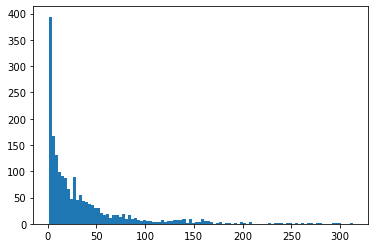

In [106]:
plt.hist(adata.X.sum(1), bins=100);

In [107]:
sc.pp.normalize_total(adata, target_sum=2e2)

In [108]:
sc.pp.scale(adata, max_value=10)

In [109]:
sc.tl.pca(adata, n_comps=100, svd_solver='arpack')

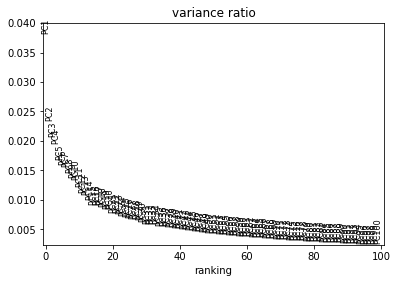

In [110]:
sc.pl.pca_variance_ratio(adata, n_pcs=100, log=False)

In [111]:
sc.pp.neighbors(adata, n_neighbors=15, metric='minkowski', n_pcs=20)

In [112]:
sc.tl.umap(adata, random_state=1, min_dist=0.25)

### Visualize and Cluster

... storing 'dx' as categorical
... storing 'Category' as categorical
... storing 'Genes-0' as categorical
... storing 'Genes-1' as categorical


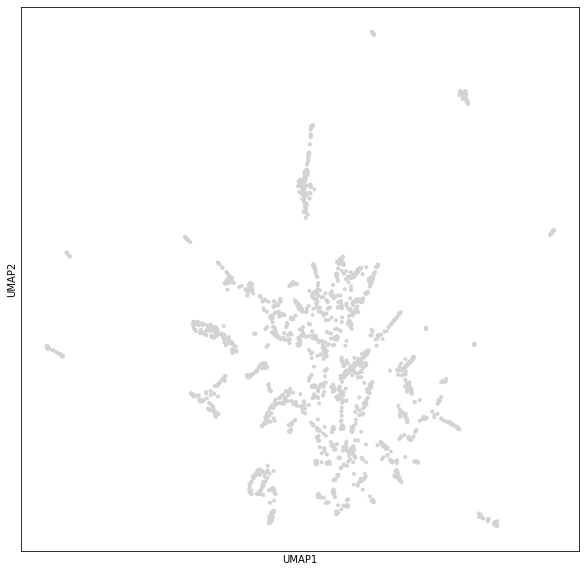

In [113]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(adata, ax=ax)

In [496]:
try:
    del(adata.uns['leiden_colors'])
except:
    pass
try:
    del(adata.uns['leiden_lowres_colors'])
except:
    pass
sc.tl.leiden(adata, resolution=3, random_state=0)
sc.tl.leiden(adata, resolution=0.3, key_added='leiden_lowres', random_state=0)

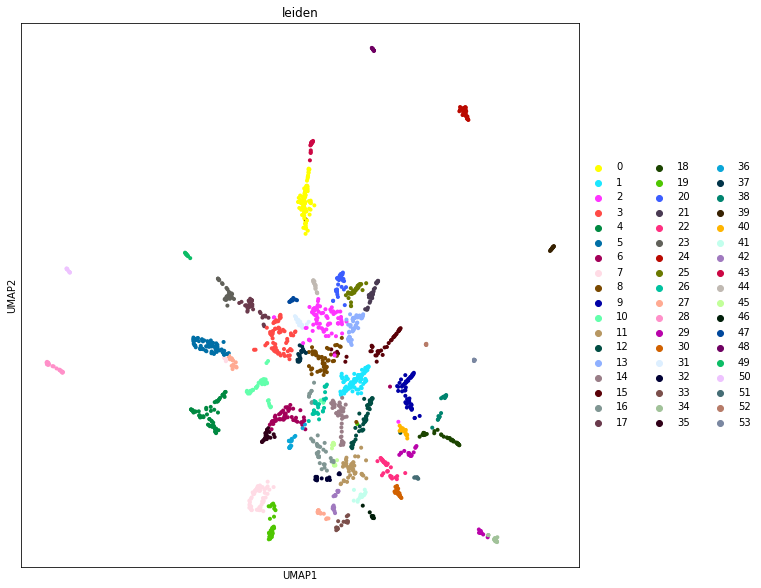

In [497]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(adata, ax=ax, color='leiden')
# sc.pl.umap(adata, ax=ax, color='leiden_lowres')

In [498]:
adata.obs['dx'] = adata.obs['dx'].astype('category')
print(adata.obs['dx'].cat.categories)

Index(['0u1u', '0n1u', '0u1n', '0d1u', '0u1d'], dtype='object')


In [499]:
adata.obs['dx'] = adata.obs['dx'].cat.reorder_categories(['0u1u', '0n1u', '0u1n', '0d1u', '0u1d'])
print(adata.obs['dx'].cat.categories)

Index(['0u1u', '0n1u', '0u1n', '0d1u', '0u1d'], dtype='object')


In [500]:
def adjust_lightness(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [501]:
# adata.uns['dx_colors'] = ['gray', cond_colors['G'], cond_colors['B'], 'k', 'k']
adata.uns['dx_colors'] = ['gray', 
                          mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 0.7)), 
                          mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 0.7)),
                          mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 1.2)), 
                          mpl.colors.rgb2hex(adjust_lightness(cond_colors['B'], 1.2))]

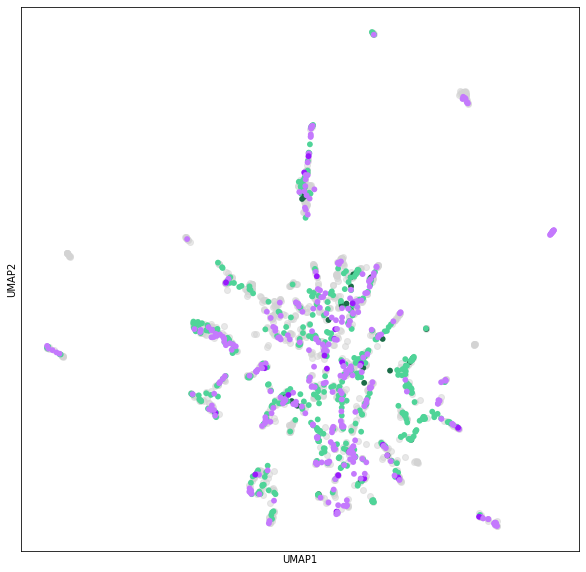

In [502]:
fig, ax = plt.subplots(figsize=(10, 10))
show_bool = ~adata.obs['dx'].isin(['0u1u'])
ax.scatter(*adata[~show_bool].obsm['X_umap'].T, color='lightgray', alpha=0.5)
sc.pl.umap(adata[show_bool], color='dx', ax=ax, sort_order=False, frameon=True, title='', legend_loc=None)

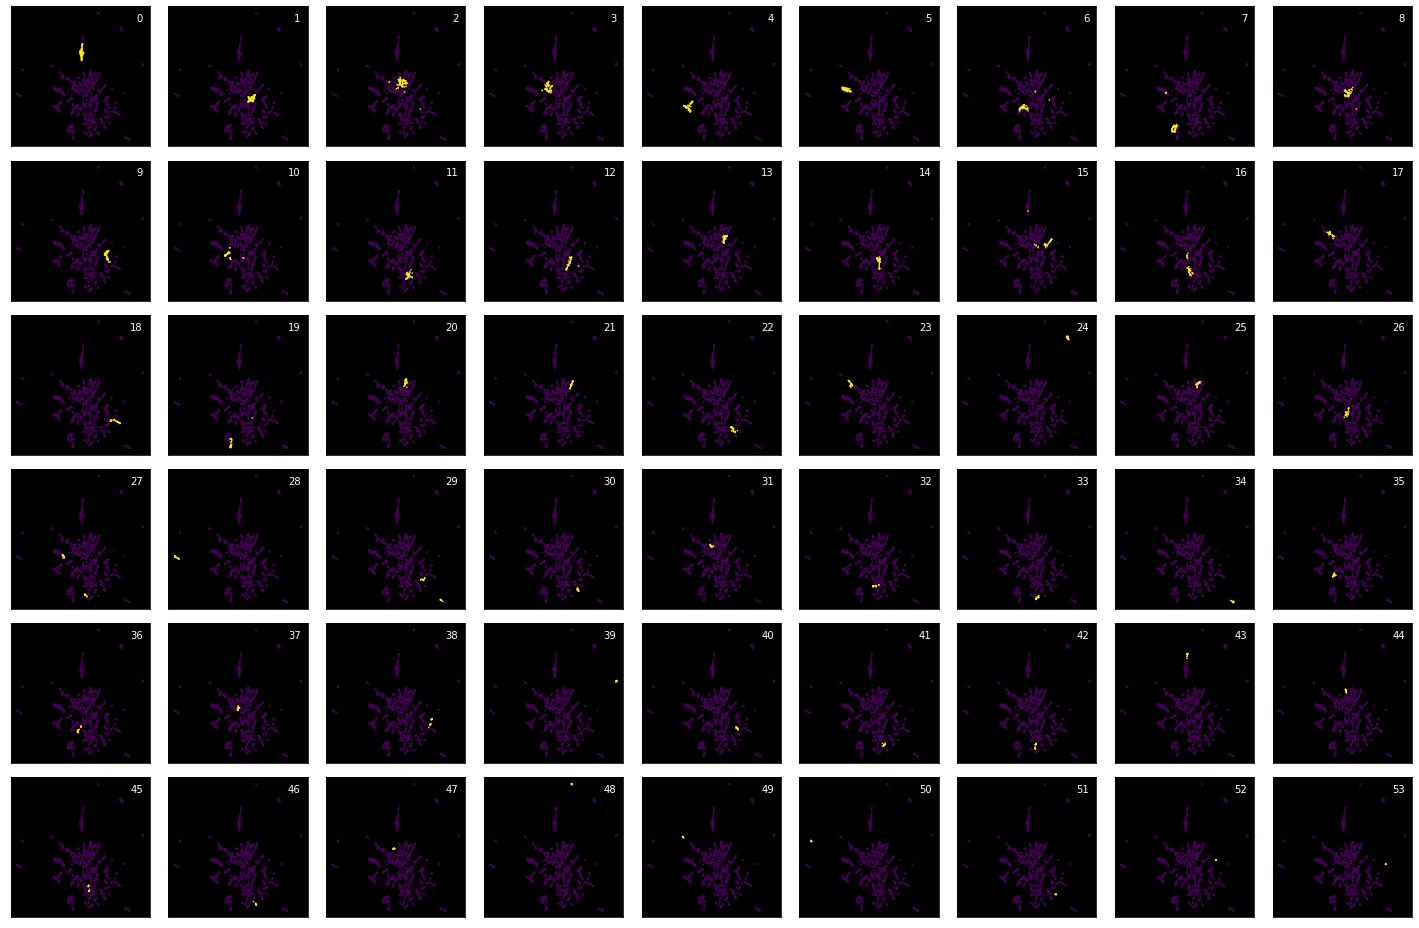

In [503]:
fig, ax = plt.subplots(6,9,figsize=(20, 13))
for val, ax in tqdm(zip(adata.obs['leiden'].dtype.categories, np.ravel(ax))):
    adata.obs['val'] = adata.obs['leiden'] == val
    ax.set_facecolor('black')
    ax = sc.pl.umap(adata, color='val', size=10, ax=ax, show=False, return_fig=False, title=str(val))
    ax.set_title(None)
    ax.text(0.95, 0.95, val, color='white', transform=ax.transAxes, ha='right', va='top')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    adata.obs.drop(columns='val', inplace=True)
for ax in fig.get_axes():
    if ax.get_label() == '<colorbar>':
        ax.remove()
plt.tight_layout()

In [504]:
sc.tl.leiden(adata, restrict_to=('leiden', ['16']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['0,0']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['1']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['8']), resolution=0.3)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['10']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['11']), resolution=0.1)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['10,0']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['13']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['14']), resolution=0.2)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['15']), resolution=0.3)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['18']), resolution=0.3)
# sc.tl.leiden(adata, restrict_to=('leiden_R', ['20']), resolution=0.1)
sc.tl.leiden(adata, restrict_to=('leiden_R', ['27']), resolution=0.2)
sc.tl.leiden(adata, restrict_to=('leiden_R', ['29']), resolution=0.2)

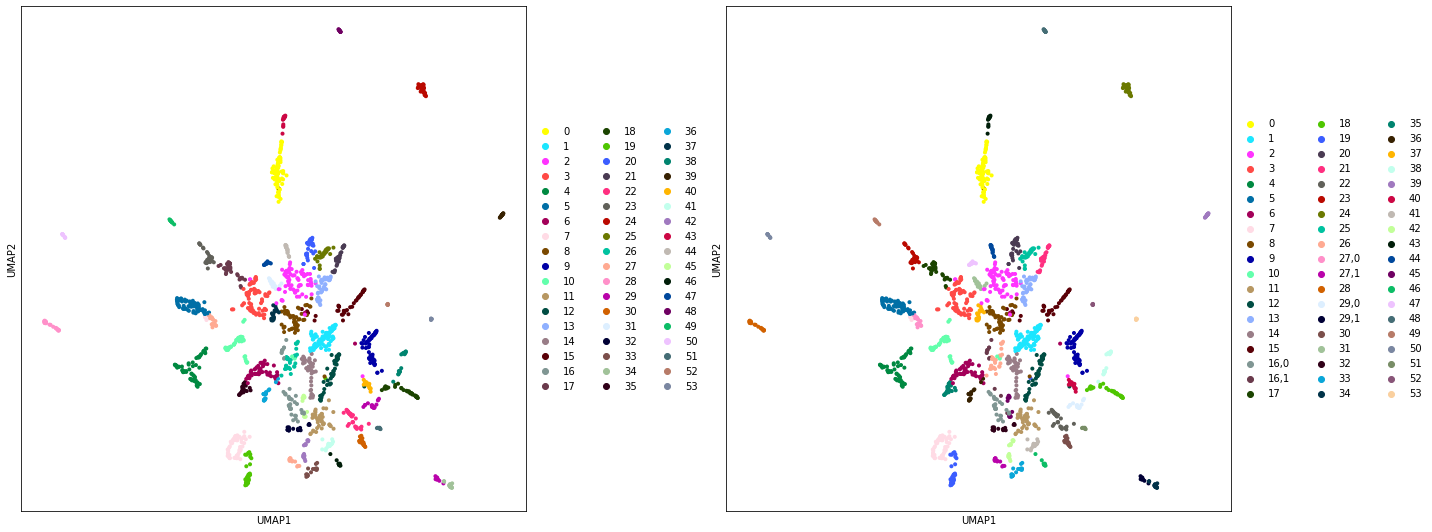

In [505]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
# ax[0].set_facecolor('gray')
# ax[1].set_facecolor('gray')
sc.pl.umap(adata, color=['leiden'], frameon=True, title='', ax=ax[0], return_fig=False, show=False)
sc.pl.umap(adata, color=['leiden_R'], frameon=True, title='', ax=ax[1], return_fig=False, show=False)
plt.tight_layout()

In [506]:
subclusters = adata.obs['leiden_R'].cat.categories
num_subclusts = len(subclusters)
subcluster_dict = dict(zip(subclusters, map(str, range(num_subclusts))))
adata.obs['leiden_R'] = adata.obs['leiden_R'].map(subcluster_dict).astype('category')

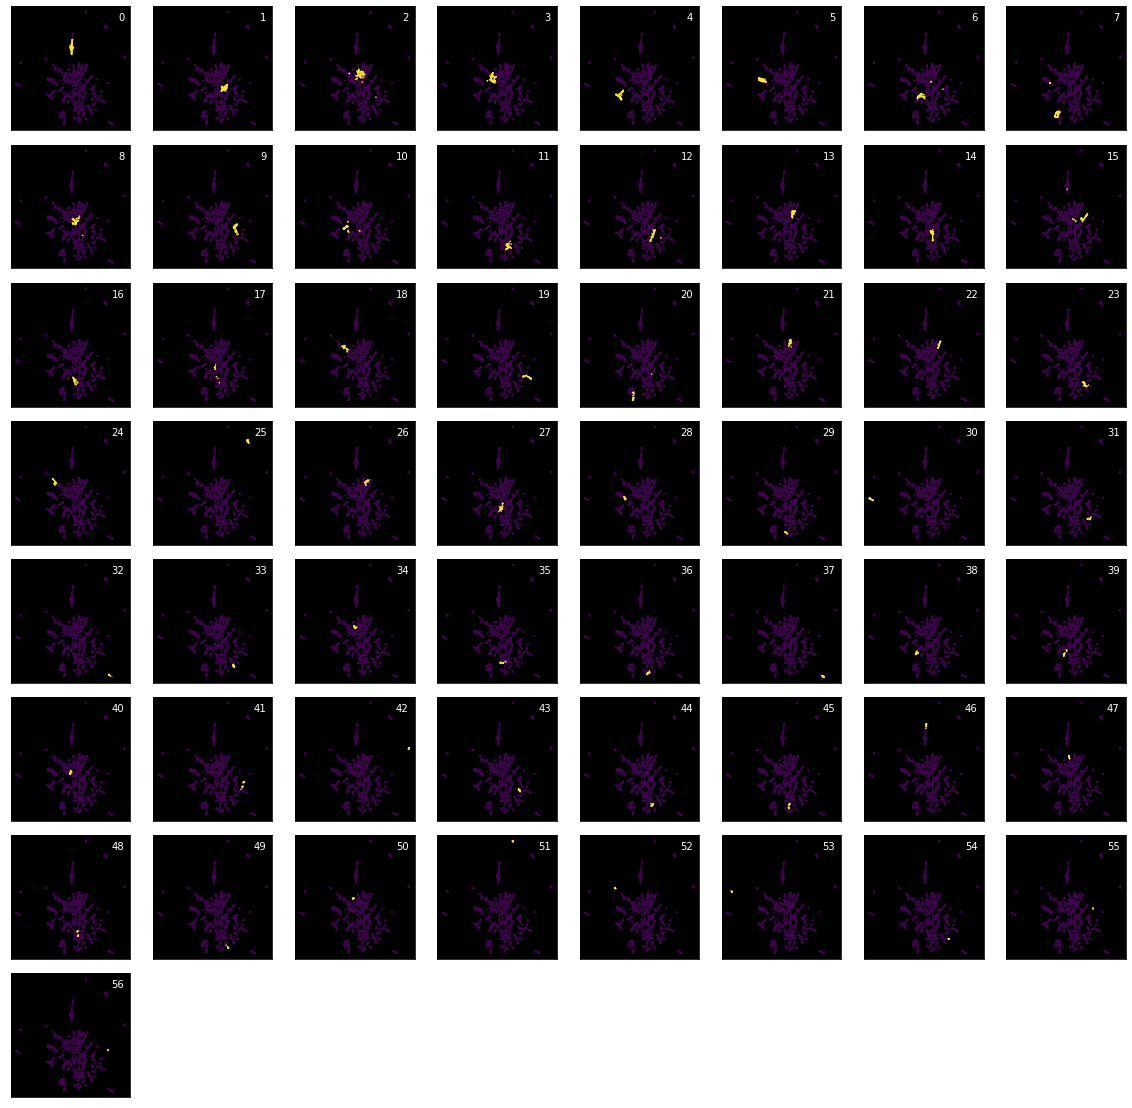

In [507]:
nrows, ncols = 8, 8
assert nrows*ncols >= num_subclusts
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows - 0.5))
for val, ax in tqdm(zip(adata.obs['leiden_R'].dtype.categories, np.ravel(axes))):
    adata.obs['val'] = adata.obs['leiden_R'] == val
    ax.set_facecolor('black')
    ax = sc.pl.umap(adata, color='val', size=10, ax=ax, show=False, return_fig=False, title=str(val))
    ax.set_title(None)
    ax.text(0.95, 0.95, val, color='white', transform=ax.transAxes, ha='right', va='top')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    adata.obs.drop(columns='val', inplace=True)
for ax in fig.get_axes():
    if ax.get_label() == '<colorbar>':
        ax.remove()
for ax in np.ravel(axes)[-(nrows*ncols-num_subclusts):]:
    ax.set_visible(False)
plt.tight_layout()

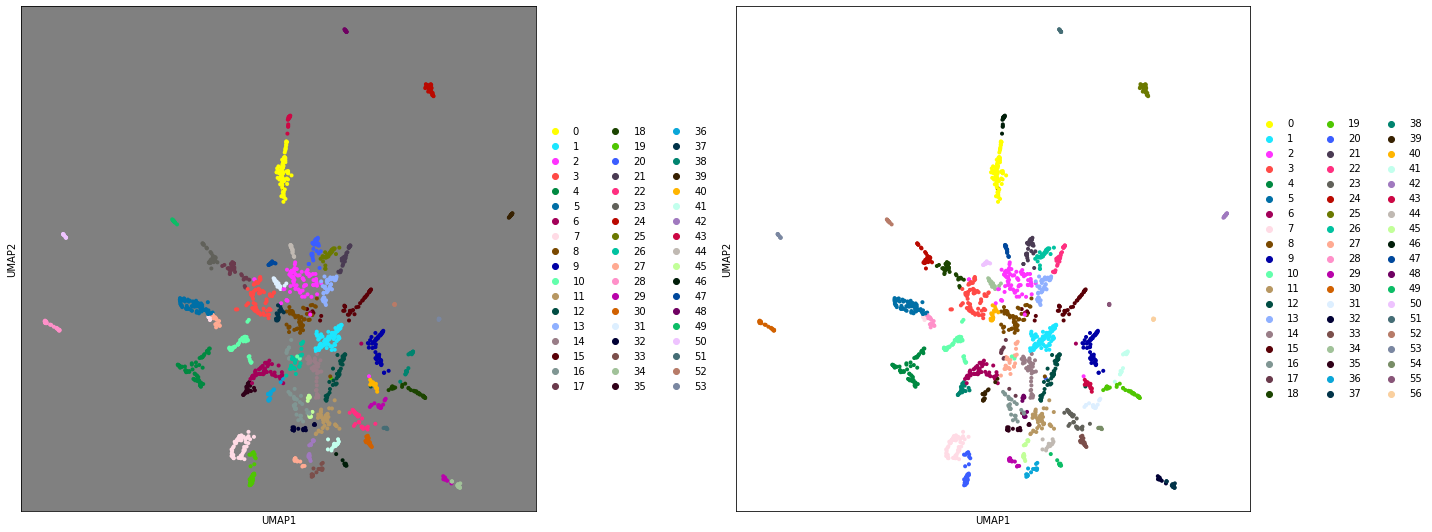

In [508]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
ax[0].set_facecolor('gray')
# ax[1].set_facecolor('gray')
sc.pl.umap(adata, color=['leiden'], frameon=True, title='', ax=ax[0], return_fig=False, show=False)
sc.pl.umap(adata, color=['leiden_R'], frameon=True, title='', ax=ax[1], return_fig=False, show=False)
plt.tight_layout()

In [509]:
def norm_between(arr, start, spread):
    return (arr - arr.min())/arr.ptp() * spread + start

In [510]:
# node_sizes_norm = norm_between(adata.obs['mean_sig'].values, 50, 200)
node_sizes_norm = norm_between(adata.obs['max_sig'].values, 50, 200)

In [511]:
node_sizes_norm.min(), node_sizes_norm.max()

(50.0, 250.0)

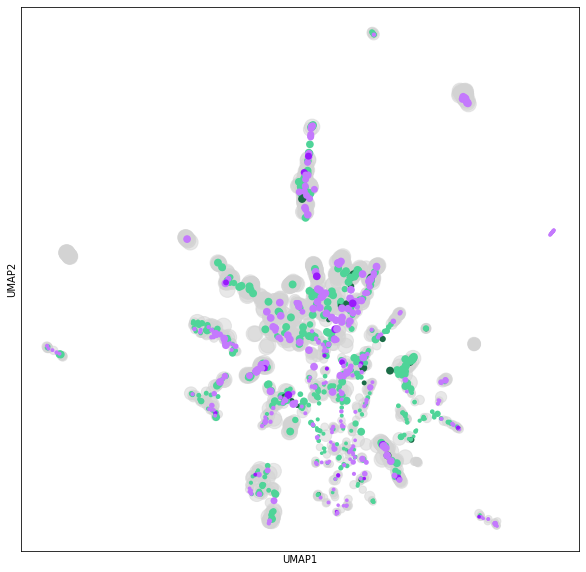

In [512]:
fig, ax = plt.subplots(figsize=(10, 10))
show_bool = ~adata.obs['dx'].isin(['0u1u'])

# s = start
# s = np.mean([start, start + spread])
s = node_sizes_norm[~show_bool]

ax.scatter(*adata[~show_bool].obsm['X_umap'].T, s=s, color='lightgray', alpha=0.5)
sc.pl.umap(adata[show_bool], color='dx', size=node_sizes_norm[show_bool], ax=ax, sort_order=False, frameon=True, title='', legend_loc=None)

In [513]:
get_id = lambda x: adata.var['Name'][adata.var['Name'] == x].index[0]

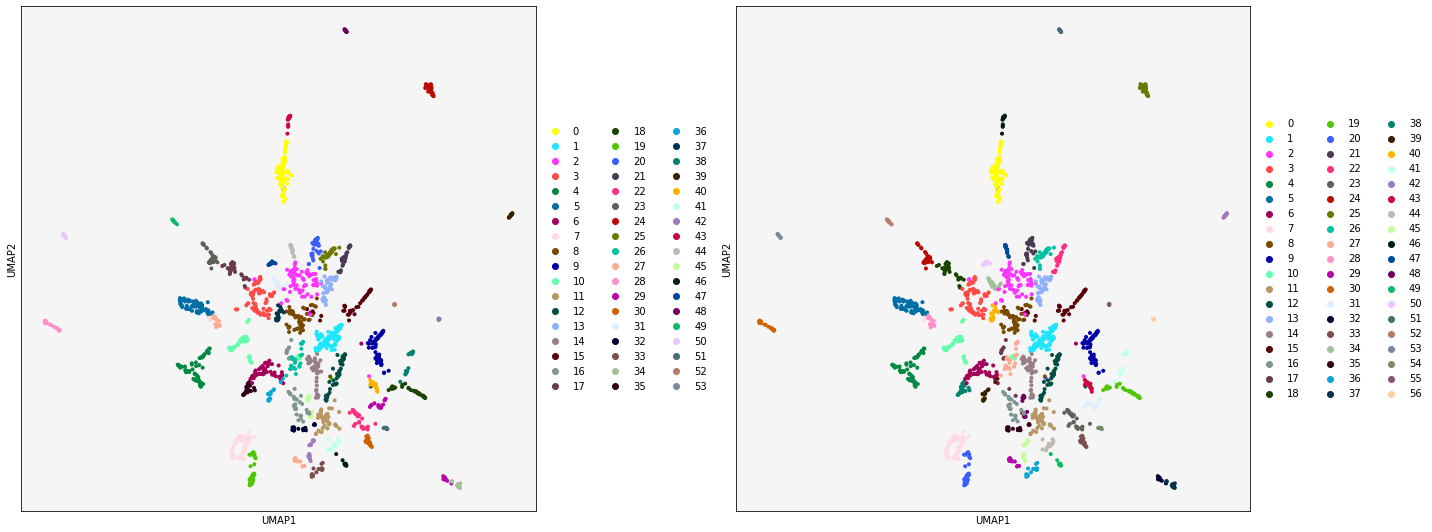

In [514]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
ax[0].set_facecolor('whitesmoke')
ax[1].set_facecolor('whitesmoke')
sc.pl.umap(adata, color=['leiden'], frameon=True, title='', ax=ax[0], return_fig=False, show=False)
sc.pl.umap(adata, color=['leiden_R'], frameon=True, title='', ax=ax[1], return_fig=False, show=False)
plt.tight_layout()

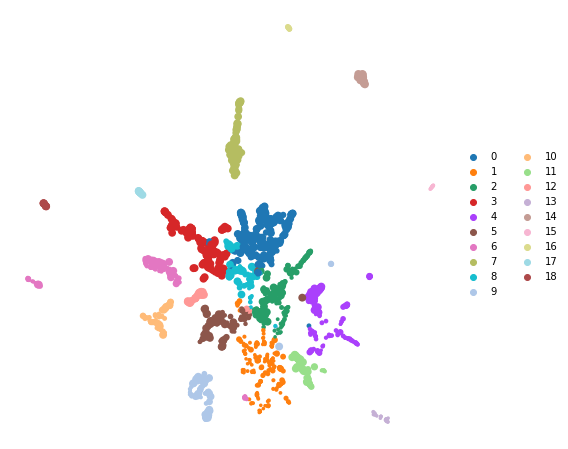

In [519]:
# fig, ax = plt.subplots(figsize=(10, 10))
# sc.pl.umap(adata, color='leiden_R', size=node_sizes_norm, ax=ax, sort_order=False, frameon=False, title='')#, legend_loc=None)
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(adata, ax=ax, size=node_sizes_norm, color='leiden_lowres', 
#            legend_loc=None, 
           frameon=False, title='')

#### Visualize Pathway or Gene

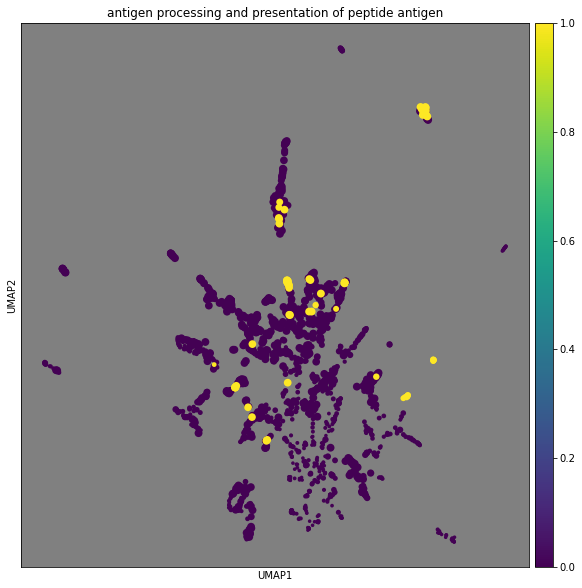

In [619]:
pathway = 'antigen processing and presentation of peptide antigen'
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('gray')
sc.pl.umap(adata, color=[get_id(pathway)], 
           use_raw=True, 
           ax=ax, size=node_sizes_norm, title=pathway, legend_loc=None)

In [156]:
'''
stimulatory C-type lectin receptor signaling pathway
innate immune response-activating signal transduction
innate immune response activating cell surface receptor signaling pathway
''';

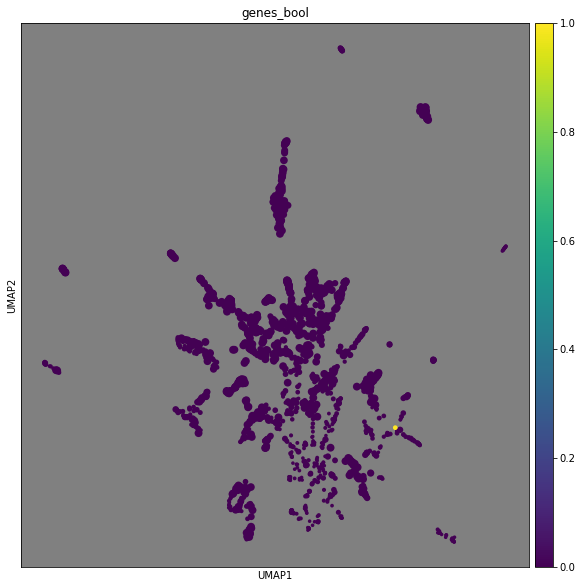

In [587]:
genes = ['DNAJB4']
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('gray')
col_name = 'genes_bool'
adata.obs[col_name] = np.stack([adata.obs_names.str.contains(g) for g in genes]).any(axis=0)
sc.pl.umap(adata, color=[col_name], 
           use_raw=True, 
           ax=ax, size=node_sizes_norm, title=col_name, legend_loc=None)
adata.obs.drop(col_name, axis=1, inplace=True)

In [518]:
# adata.write_h5ad(sc_prefix + 'combined/h5ads/gene_adata.h5ad')
adata = sc.read_h5ad(sc_prefix + 'combined/h5ads/gene_adata.h5ad')

### Rank Features

#### `leiden_lowres`

In [520]:
cov = 'leiden_lowres'
sc.tl.rank_genes_groups(adata, groupby=cov, method='wilcoxon', n_genes=100)

In [521]:
np.array(adata.uns['rank_genes_groups']['scores'].tolist()).shape

(100, 19)

In [522]:
def better_rank_genes_plot(adata, n_genes=100, ncols=5):
    cats = adata.obs[adata.uns['rank_genes_groups']['params']['groupby']].cat.categories
    nrows = int(np.ceil(cats.shape[0]/ncols))
    scores = np.array(adata.uns['rank_genes_groups']['scores'].tolist()).T
    fig, axes = plt.subplots(nrows, ncols, figsize=(2.5*ncols, 2.5*nrows - 0.5), sharey=False)
    for i, ax in zip(range(len(cats)), np.ravel(axes)):
        y = np.arange(n_genes)[::-1]
        x = scores[i, :n_genes]
#         genes = np.array([i[0] for i in adata.uns['rank_genes_groups']['names'].tolist()])
#         txts = genes[:n_genes]

        ax.scatter(x, y, s=3)
        ax.plot(x, y)
        ax.set_yticks(np.arange(0, 105, 5), minor=True)
        ax.set_yticks(np.arange(0, 105, 10), minor=False)
        ax.set_yticklabels(np.arange(0, 105, 10)[::-1], size=8, minor=False)
        ax.grid(which='both', color='lightgray')
        ax.set_axisbelow(True)
        ax.text(0.95, 0.05, str(i), color='k', transform=ax.transAxes, ha='right', va='bottom')
    for ax in np.ravel(axes)[-(nrows*ncols-len(cats)):]:
        ax.set_visible(False)

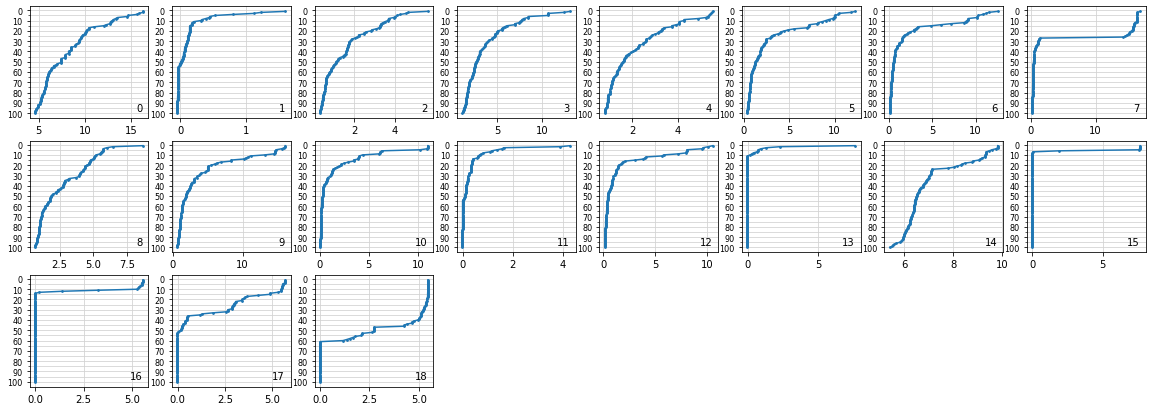

In [523]:
better_rank_genes_plot(adata, ncols=8)

In [524]:
# num_features = [
#     50, 50, 35, 30, 25, 30, 40, 25, 55, 50,
#     25, 25, 25, 35, 25, 15, 15, 35, 20, 20,
#     25, 60, 10, 
# ]
num_features = [5]*len(adata.obs[cov].cat.categories)

In [525]:
for clust, num in zip(adata.obs[cov].cat.categories, num_features):
    print(clust)
    print('\n'.join([adata.var.loc[i, 'Name'] for i in list(adata.uns['rank_genes_groups']['names'][clust])[:num]]))
    print('')

0
leukocyte activation
cell activation
immune system development
lymphocyte activation
hemopoiesis

1
organophosphate metabolic process
carboxylic acid metabolic process
DNA biosynthetic process
cellular ketone metabolic process
peptidyl-amino acid modification

2
cellular response to oxygen-containing compound
response to nitrogen compound
response to organonitrogen compound
regulation of ion transport
regulation of anion transport

3
defense response to other organism
innate immune response
response to virus
defense response to virus
defense response to symbiont

4
regulation of cell motility
regulation of locomotion
regulation of cellular component movement
regulation of cell migration
regulation of GTPase activity

5
regulation of phosphorylation
regulation of protein phosphorylation
regulation of transferase activity
regulation of kinase activity
positive regulation of phosphate metabolic process

6
organonitrogen compound catabolic process
protein catabolic process
macromolecule 

#### `leiden_R`

In [549]:
cov = 'leiden_R'
sc.tl.rank_genes_groups(adata, groupby=cov, method='wilcoxon', n_genes=100)

In [550]:
np.array(adata.uns['rank_genes_groups']['scores'].tolist()).shape

(100, 57)

In [551]:
def better_rank_genes_plot(adata, n_genes=100, ncols=5):
    cats = adata.obs[adata.uns['rank_genes_groups']['params']['groupby']].cat.categories
    nrows = int(np.ceil(cats.shape[0]/ncols))
    scores = np.array(adata.uns['rank_genes_groups']['scores'].tolist()).T
    fig, axes = plt.subplots(nrows, ncols, figsize=(2.5*ncols, 2.5*nrows - 0.5), sharey=False)
    for i, ax in zip(range(len(cats)), np.ravel(axes)):
        y = np.arange(n_genes)[::-1]
        x = scores[i, :n_genes]
#         genes = np.array([i[0] for i in adata.uns['rank_genes_groups']['names'].tolist()])
#         txts = genes[:n_genes]

        ax.scatter(x, y, s=3)
        ax.plot(x, y)
        ax.set_yticks(np.arange(0, 105, 5), minor=True)
        ax.set_yticks(np.arange(0, 105, 10), minor=False)
        ax.set_yticklabels(np.arange(0, 105, 10)[::-1], size=8, minor=False)
        ax.grid(which='both', color='lightgray')
        ax.set_axisbelow(True)
        ax.text(0.95, 0.05, str(i), color='k', transform=ax.transAxes, ha='right', va='bottom')
    for ax in np.ravel(axes)[-(nrows*ncols-len(cats)):]:
        ax.set_visible(False)

In [ ]:
better_rank_genes_plot(adata, ncols=8)

In [553]:
# num_features = [
#     50, 50, 35, 30, 25, 30, 40, 25, 55, 50,
#     25, 25, 25, 35, 25, 15, 15, 35, 20, 20,
#     25, 60, 10, 
# ]
num_features = [5]*len(adata.obs[cov].cat.categories)

In [554]:
for clust, num in zip(adata.obs[cov].cat.categories, num_features):
    print(clust)
    print('\n'.join([adata.var.loc[i, 'Name'] for i in list(adata.uns['rank_genes_groups']['names'][clust])[:num]]))
    print('')

0
myeloid cell activation involved in immune response
myeloid leukocyte activation
leukocyte activation involved in immune response
leukocyte degranulation
cell activation involved in immune response

1
response to nitrogen compound
response to organonitrogen compound
cellular response to oxygen-containing compound
cellular response to nitrogen compound
response to peptide

2
cytokine production
regulation of cytokine production
positive regulation of multicellular organismal process
positive regulation of gene expression
cell activation

3
regulation of response to external stimulus
regulation of defense response
regulation of response to stress
regulation of response to biotic stimulus
defense response to other organism

4
cellular nitrogen compound catabolic process
heterocycle catabolic process
aromatic compound catabolic process
organic cyclic compound catabolic process
nucleobase-containing compound catabolic process

5
cellular protein catabolic process
proteolysis involved in c

##### Specific Comparison

In [ ]:
# sc.tl.rank_genes_groups()
# sc.pl.rank_genes_groups()

In [572]:
comparison = ['41', '19']
num_keeps = [40, 40]
terms = list()
for clust, num_keep in zip(comparison, num_keeps):
    leiden_R_clust = clust
    sub_obs = adata.obs[adata.obs['leiden_R'] == leiden_R_clust]
    leiden_R_clust_genes = sub_obs.index
    terms.append([i for i in adata.uns['rank_genes_groups']['names'][leiden_R_clust][:num_keep][adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep] > 0]])
np.intersect1d(*terms)

array(['595'], dtype='<U4')

In [577]:
adata.var.loc[['595'], :]

Name Category  QValueFDRBH-0  \
595  protein folding       BP       0.001634   

                                               Genes-0  GenesInTermInQuery-0  \
595  DNAJA4,FKBP1B,FKBP5,PRDX4,CHORDC1,AHSA1,ERP44,...                    30   

     -log10FDR-0  QValueFDRBH-1 Genes-1  GenesInTermInQuery-1  -log10FDR-1  \
595     2.786665            1.0                             0          0.0   

         mean       std  
595  0.260099  5.028795

In [581]:
np.intersect1d(adata.var.loc['595']['Genes-0'].split(','), adata.obs_names[adata.obs['leiden_R'].isin(comparison)].str.replace('-[0-1]$', ''))

array(['AHSA1', 'DNAJB4'], dtype=object)

## Check Genes

### Check if Gene in Term

In [173]:
term = 'inorganic ion homeostasis'
gene = 'STEAP4'
cond = '1'
term_genes = adata.var[adata.var['Name'] == term]['Genes-' + cond][0].split(',')
gene in term_genes

True

### Check Which Terms Have Gene

In [616]:
gene_str = '(?=.*DNAJB4)' #(?=.*TRAF5)(?=.*LMNB1)(?=.*MAPK8IP2)(?=.*MTURN)'
cond = '0'
adata.var.loc[adata.var['Genes-' + cond].str.contains(gene_str)]

Name Category  QValueFDRBH-0  \
124                 regulation of hydrolase activity       BP   1.372784e-10   
189        positive regulation of hydrolase activity       BP   2.613193e-08   
325                     response to abiotic stimulus       BP   7.515129e-06   
365                        'de novo' protein folding       BP   2.402572e-05   
412               chaperone-mediated protein folding       BP   9.097157e-05   
458                 response to temperature stimulus       BP   2.092277e-04   
477      'de novo' posttranslational protein folding       BP   2.596270e-04   
505   chaperone cofactor-dependent protein refolding       BP   3.989696e-04   
595                                  protein folding       BP   1.634314e-03   
614                                 response to heat       BP   1.980458e-03   
1035                    response to unfolded protein       BP   3.851488e-02   

                                                Genes-0  GenesInTermInQuery-0  \
124   ABL2,CD109,MEFV,PTK2B,ADPRH,NOD1,CCL2,CCL3,CCL...                   151   
189   ABL2,MEFV,PTK2B,ADPRH,NOD1,CCL2,CCL3,CCL4,CCL5...                   100   
325   BRIP1,FBXL8,RCSD1,EXT1,TLR7,MDK,PLEKHN1,ADA,TL...                   119   
365   FKBP1B,BAG1,TOR1B,DNAJB4,ENTPD5,CD74,HSPA1A,HS...                    13   
412   FKBP1B,FKBP5,CHORDC1,BAG1,TOR1B,DNAJB4,CD74,HS...                    15   
458   PLAC8,ADM,ADRB2,DNAJA4,MICB,TRPV2,CXCL12,TFEC,...                    32   
477   BAG1,TOR1B,DNAJB4,ENTPD5,CD74,HSPA1A,HSPA1B,HS...                    11   
505   BAG1,TOR1B,DNAJB4,CD74,HSPA1A,HSPA1B,HSPA8,DNA...                    10   
595   DNAJA4,FKBP1B,FKBP5,PRDX4,CHORDC1,AHSA1,ERP44,...                    30   
614   DNAJA4,MICB,TRPV2,CXCL12,TFEC,CHORDC1,BAG1,NUP...                    23   
1035  CCL2,ATF3,ERP44,TOR1B,DNAJB4,SERPINH1,DNAJA1,H...                    21   

      -log10FDR-0  QValueFDRBH-1  \
124      9.862398       0.000004   
189      7.582829       0.000006   
325      5.124064       0.004173   
365      4.619324       1.000000   
412      4.041094       0.007621   
458      3.679381       1.000000   
477      3.585650       1.000000   
505      3.399060       1.000000   
595      2.786665       1.000000   
614      2.703234       1.000000   
1035     1.414371       0.001562   

                                                Genes-1  GenesInTermInQuery-1  \
124   CRIM1,LRRK2,WDR81,EZH2,F3,RSU1,MEFV,SORT1,NOD1...                   123   
189   LRRK2,EZH2,F3,RSU1,MEFV,NOD1,CCL8,CCL13,CCL18,...                    85   
325   SDE2,FBXL8,RCSD1,TLR7,MDK,TLR8,PLAC8,MICU1,S10...                    96   
365                                                                         0   
412   FKBP5,CD74,CLU,SDF2L1,HSPA5,HSPA8,HSPB1,ERO1A,...                    11   
458                                                                         0   
477                                                                         0   
505                                                                         0   
595                                                                         0   
614                                                                         0   
1035  DNAJB9,RHBDD1,HYOU1,EDEM2,ATF3,MYDGF,HSP90B1,D...                    24   

      -log10FDR-1      mean        std  
124      5.426959  1.439118   6.249293  
189      5.232441  0.966067   5.028479  
325      2.379503  1.386458  10.218015  
365      0.000000  0.057439   1.017852  
412      2.117993  0.190851   2.986320  
458      0.000000  0.144942   2.123887  
477      0.000000  0.055380   1.016001  
505      0.000000  0.049003   0.978706  
595      0.000000  0.260099   5.028795  
614      0.000000  0.094822   1.435400  
1035     2.806425  0.255633   4.861623

### Proportion Column Graph

In [175]:
def prop_col_chart(adata, group, x='leiden', norm=True, prop=True, order=None, figsize=(10,5), x_font_size=10):
    df = adata.obs[[group, x]].copy()
#     return df
    try: # if it's something that can be coerced into a number, probably want to display in numerical order
        df[group] = df[group].astype(int)
    except ValueError: # can't be coerced, oh well
        pass
    
    try: # if it's something that can be coerced into a number, probably want to display in numerical order
        df[x] = df[x].astype(int)
    except ValueError: # can't be coerced, oh well
        pass
    
    df_gb = df.reset_index(drop=False).groupby([group, x]).count().reset_index(group).pivot(columns=group)
    df_gb.columns = df_gb.columns.droplevel(0)
    df_gb.fillna(0, inplace=True)
    if norm:
        vcounts = df[group].value_counts()
        for col in df_gb:
            df_gb[col] = df_gb[col]/vcounts.loc[col]
    if prop:
        df_gb = df_gb.div(df_gb.sum(1), axis=0)
    fig, ax = plt.subplots(figsize=figsize)
    
    gs = adata.obs[group].cat.categories
    cs = adata.uns[group + '_colors']
    color_dict = dict(zip(gs, cs))    
    
    if type(order) != type(None):
        gs = order
        cs = [color_dict[g] for g in order]
    
    lastpos = [0]*len(df_gb.index)
    for (g, c) in zip(gs, cs):
        ax.bar(df_gb.index, df_gb[g].values, label=str(g), bottom=lastpos, color=c)
        lastpos = df_gb[g].values + lastpos
        
    if prop:
        ylabel = 'Proportion of observations'
    else:
        ylabel = 'Number of Observations'
    ax.set_ylabel(ylabel)
    ax.grid(False)
    ax.set_xticks(df_gb.index)
    ax.set_xticklabels(df_gb.index, rotation=45, size=x_font_size, ha='right')
#     ax.legend()
    return df_gb, ax

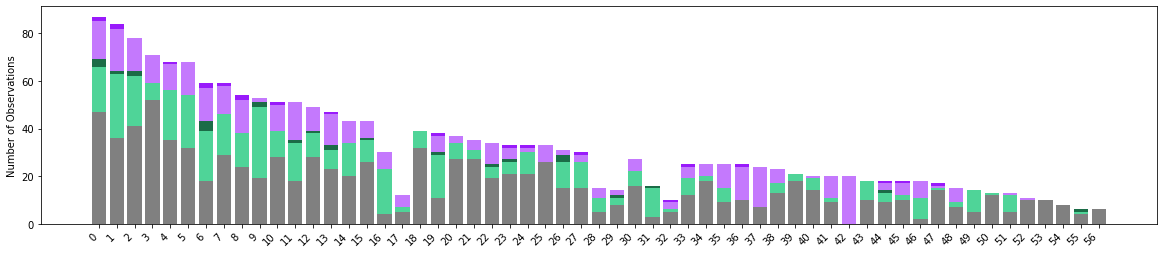

In [176]:
df_gb_abs, ax = prop_col_chart(adata, group='dx', x='leiden_R', prop=False, norm=False, order=['0u1u', '0u1n', '0u1d', '0n1u', '0d1u'], figsize=(20,4));

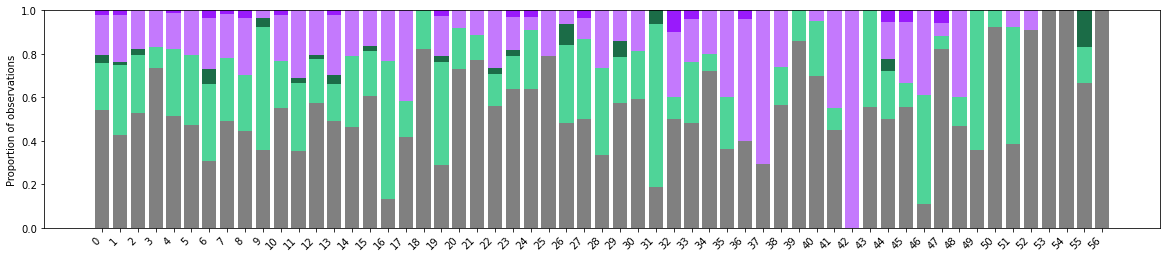

In [177]:
df_gb_rel, ax = prop_col_chart(adata, group='dx', x='leiden_R', prop=True, norm=False, order=['0u1u', '0u1n', '0u1d', '0n1u', '0d1u'], figsize=(20,4));

In [178]:
(df_gb_rel[['0u1n', '0u1d']].sum(1)/df_gb_rel[['0n1u', '0d1u']].sum(1)).sort_values(ascending=False).head(10)

leiden_R
55     inf
43     inf
50     inf
49     inf
18     inf
31     inf
39     inf
9     16.0
26     7.0
51     7.0
dtype: float64

In [179]:
(df_gb_rel[['0n1u', '0d1u']].sum(1)/df_gb_rel[['0u1n', '0u1d']].sum(1)).sort_values(ascending=False).head(10)

leiden_R
52    inf
42    inf
36    inf
37    inf
25    inf
41    4.5
32    4.0
45    3.0
48    3.0
17    2.5
dtype: float64

### Define the Focus Cluster

In [728]:
leiden_R_clust = '41'
sub_obs = adata.obs[adata.obs['leiden_R'] == leiden_R_clust]
leiden_R_clust_genes = sub_obs.index

In [729]:
leiden_R_clust_genes

Index(['AP1S3-0', 'DNAJB4-0', 'HLA-DOB-0', 'KIF23-0', 'OSBPL1A-0', 'AP1S3-1',
       'HELB-1', 'HLA-DMA-1', 'HLA-DOB-1', 'KIF2A-1', 'METTL1-1', 'METTL8-1',
       'MRPL44-1', 'MTO1-1', 'NCF4-1', 'NSUN6-1', 'OSBPL1A-1', 'PUS3-1',
       'TAPBPL-1', 'WDR4-1'],
      dtype='object', name='gene')

In [730]:
# # # for figuring out where things are in UMAP space
# arr = np.concatenate([np.expand_dims(leiden_R_clust_genes, axis=1), adata.obsm['X_umap'][adata.obs['leiden_R'] == leiden_R_clust]], axis=1)
# arr[:, 0][arr[:,1] > 15]

In [731]:
print(leiden_R_clust)
num_keep = 30

enrich_terms = [i for i in adata.uns['rank_genes_groups']['names'][leiden_R_clust][:num_keep][adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep] > 0]]
# enrich_terms = list(adata.uns['rank_genes_groups']['names'][leiden_R_clust])[20:40]

print('\n'.join([adata.var.loc[i, 'Name'] for i in enrich_terms]))
adata.var.loc[enrich_terms].head()

41
antigen processing and presentation of peptide antigen
antigen processing and presentation
antigen processing and presentation of exogenous peptide antigen
antigen processing and presentation of exogenous antigen
ncRNA processing
ncRNA metabolic process
antigen processing and presentation of peptide antigen via MHC class II
antigen processing and presentation of peptide or polysaccharide antigen via MHC class II
antigen processing and presentation of exogenous peptide antigen via MHC class II
negative regulation of antigen processing and presentation
regulation of antigen processing and presentation
tRNA (guanine-N7)-methylation
negative regulation of antigen processing and presentation of peptide antigen
regulation of antigen processing and presentation of peptide antigen
peptide antigen assembly with MHC protein complex
MHC protein complex assembly
negative regulation of immune system process
antigen processing and presentation of peptide antigen via MHC class I
adaptive immune re

Name Category  \
258   antigen processing and presentation of peptide...       BP   
161                 antigen processing and presentation       BP   
303   antigen processing and presentation of exogeno...       BP   
300   antigen processing and presentation of exogeno...       BP   
1178                                   ncRNA processing       BP   

      QValueFDRBH-0                                            Genes-0  \
258    9.001330e-07  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
161    4.564922e-09  LILRB2,NCF1,EXT1,NOD1,OSBPL1A,RAB8B,FGL2,NOD2,...   
303    3.143919e-06  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
300    2.692785e-06  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
1178   1.000000e+00                                                      

      GenesInTermInQuery-0  -log10FDR-0  QValueFDRBH-1  \
258                     34     6.045693   1.293869e-19   
161                     43     8.340567   7.736371e-21   
303                     31     5.502529   2.343381e-18   
300                     32     5.569798   2.709891e-18   
1178                     0     0.000000   9.901955e-03   

                                                Genes-1  GenesInTermInQuery-1  \
258   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,ERAP1,B2M,NC...                    52   
161   NCF1,NOD1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,ERAP1,B...                    59   
303   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,B2M,NCF4,TAP...                    48   
300   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,B2M,NCF4,TAP...                    49   
1178  ADAR,METTL1,EMG1,USP36,ESF1,RRP1,NIFK,NOP14,WD...                    38   

      -log10FDR-1      mean       std  
258     18.888110  0.303672  2.396696  
161     20.111463  0.361135  2.865542  
303     17.630157  0.280954  2.336728  
300     17.567048  0.284949  2.339407  
1178     2.004279  0.793584  6.703963

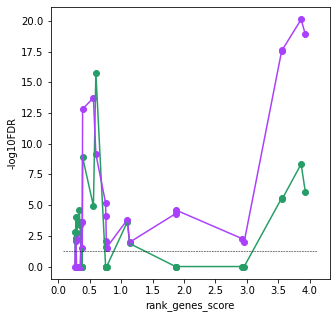

In [732]:
plt.figure(figsize=(5,5))
plt.scatter(adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep], adata.var.loc[enrich_terms, '-log10FDR-0'].values, c=cond_colors['B'])
plt.plot(adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep], adata.var.loc[enrich_terms, '-log10FDR-0'].values, c=cond_colors['B'])
plt.scatter(adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep], adata.var.loc[enrich_terms, '-log10FDR-1'].values, c=cond_colors['G'])
plt.plot(adata.uns['rank_genes_groups']['scores'][leiden_R_clust][:num_keep], adata.var.loc[enrich_terms, '-log10FDR-1'].values, c=cond_colors['G'])
xlim = plt.xlim()
plt.plot(xlim, [-np.log10(0.05)]*2, c='k', linewidth=0.5, linestyle='--')
plt.xlabel('rank_genes_score')
plt.ylabel('-log10FDR');

In [733]:
# term = 'chaperone-mediated protein folding'
# adata.var[adata.var['Name'] == term]

Shared up:

In [734]:
shared_sub_obs = sub_obs[sub_obs['dx'] == '0u1u'].copy()
shared_sub_obs['mean_l'] = shared_sub_obs[['l0', 'l1']].mean(1)
shared_sub_obs.sort_values(by='mean_l', ascending=False).head(10)

dx        l0            p0        l1            p1   mean_sig  \
gene                                                                         
OSBPL1A-0  0u1u  2.935879  3.249022e-48  1.352649  3.263180e-15   6.364647   
OSBPL1A-1  0u1u  2.935879  3.249022e-48  1.352649  3.263180e-15  11.129907   
HELB-1     0u1u  1.485008  3.609093e-13  0.884366  7.372345e-07   4.436668   
HLA-DOB-0  0u1u  0.635381  1.158538e-02  0.953913  3.635152e-05   6.959247   
HLA-DOB-1  0u1u  0.635381  1.158538e-02  0.953913  3.635152e-05   8.616671   
AP1S3-0    0u1u  0.702898  1.993481e-04  0.725358  2.105905e-04  12.685781   
AP1S3-1    0u1u  0.702898  1.993481e-04  0.725358  2.105905e-04  14.188215   
NSUN6-1    0u1u  0.594420  8.496778e-04  0.554196  1.764673e-03   2.133817   
MRPL44-1   0u1u  0.582135  3.018399e-03  0.530213  3.992576e-03   1.994537   

             max_sig batch leiden leiden_lowres leiden_R    mean_l  
gene                                                                
OSBPL1A-0   8.340567     0     38             4       41  2.144264  
OSBPL1A-1  20.111463     1     38             4       41  2.144264  
HELB-1     18.183476     1     38             4       41  1.184687  
HLA-DOB-0  15.783381     0     38             4       41  0.794647  
HLA-DOB-1  20.111463     1     38             4       41  0.794647  
AP1S3-0    25.988259     0     38             4       41  0.714128  
AP1S3-1    20.726756     1     38             4       41  0.714128  
NSUN6-1     2.263355     1     38             4       41  0.574308  
MRPL44-1    2.263355     1     38             4       41  0.556174

Shared and found in different modules:

In [735]:
deduped_counts = shared_sub_obs.index.str.replace('-[0-1]', '').value_counts()
shared_sub_obs[shared_sub_obs.index.str.startswith('|'.join(deduped_counts.index[deduped_counts == 1].tolist()))]

Empty DataFrame
Columns: [dx, l0, p0, l1, p1, mean_sig, max_sig, batch, leiden, leiden_lowres, leiden_R, mean_l]
Index: []

0 up:

In [736]:
sub_obs[sub_obs['dx'] == '0u1n'].sort_values(by='l0', ascending=False).head(10)

dx        l0            p0        l1        p1  mean_sig  \
gene                                                                   
DNAJB4-0  0u1n  1.434845  4.303752e-13 -0.167842  0.567119  4.436188   
KIF23-0   0u1n  0.564519  8.957330e-03  0.153772  0.652256  5.376399   

           max_sig batch leiden leiden_lowres leiden_R  
gene                                                    
DNAJB4-0  9.862398     0     38             4       41  
KIF23-0   8.340567     0     38             4       41

In [737]:
sub_obs[sub_obs['dx'] == '0u1d'].sort_values(by='l0', ascending=False).head(10)

Empty DataFrame
Columns: [dx, l0, p0, l1, p1, mean_sig, max_sig, batch, leiden, leiden_lowres, leiden_R]
Index: []

1 up:

In [738]:
sub_obs[sub_obs['dx'] == '0n1u'].sort_values(by='l1', ascending=False)#.head(10)

dx        l0        p0        l1            p1   mean_sig  \
gene                                                                     
HLA-DMA-1  0n1u -0.010312  0.980043  3.055568  5.792074e-36   9.749739   
NCF4-1     0n1u  0.367144  0.215957  0.968738  1.485247e-04  10.720612   
PUS3-1     0n1u  0.211944  0.263548  0.967582  4.519666e-11   2.133817   
MTO1-1     0n1u  0.003277  0.991040  0.811389  8.327014e-07   2.133817   
KIF2A-1    0n1u -0.152078  0.494929  0.749441  3.071221e-05  12.521859   
METTL1-1   0n1u -0.150855  0.558512  0.709986  1.238447e-03   1.938201   
TAPBPL-1   0n1u  0.145547  0.514078  0.701466  9.671874e-05   8.059702   
METTL8-1   0n1u  0.177712  0.401471  0.656161  1.424801e-04   2.133817   
WDR4-1     0n1u -0.032421  0.923275  0.560388  8.248908e-03   1.938201   

             max_sig batch leiden leiden_lowres leiden_R  
gene                                                      
HLA-DMA-1  20.111463     1     38             4       41  
NCF4-1     20.111463     1     38             4       41  
PUS3-1      2.263355     1     38             4       41  
MTO1-1      2.263355     1     38             4       41  
KIF2A-1    20.111463     1     38             4       41  
METTL1-1    2.263355     1     38             4       41  
TAPBPL-1   20.111463     1     38             4       41  
METTL8-1    2.263355     1     38             4       41  
WDR4-1      2.263355     1     38             4       41

In [739]:
sub_obs[sub_obs['dx'] == '0d1u'].sort_values(by='l1', ascending=False).head(10)

Empty DataFrame
Columns: [dx, l0, p0, l1, p1, mean_sig, max_sig, batch, leiden, leiden_lowres, leiden_R]
Index: []

In [764]:
[print(i) for i in adata.var.loc['161']['Genes-0'].split(',')];

LILRB2
NCF1
EXT1
NOD1
OSBPL1A
RAB8B
FGL2
NOD2
TAP1
TAP2
TAPBP
RAB35
CD36
CD68
CD74
HLA-A
HLA-B
HLA-C
HLA-DOB
HLA-DPA1
HLA-DPB1
HLA-E
HLA-F
MR1
CCR7
PSMF1
KIF23
AP1S3
CTSD
CTSL
LGMN
PSMA2
PSMA4
PSMA5
PSMB8
PSMB9
PSMB10
PSME1
PSME2
RILP
ACE
MARCHF1
LAG3


In [762]:
adata.var[adata.var['Genes-0'].str.contains('KIF23')]

Name Category  \
161                 antigen processing and presentation       BP   
258   antigen processing and presentation of peptide...       BP   
300   antigen processing and presentation of exogeno...       BP   
303   antigen processing and presentation of exogeno...       BP   
1030                           regulation of cell cycle       BP   

      QValueFDRBH-0                                            Genes-0  \
161    4.564922e-09  LILRB2,NCF1,EXT1,NOD1,OSBPL1A,RAB8B,FGL2,NOD2,...   
258    9.001330e-07  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
300    2.692785e-06  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
303    3.143919e-06  NCF1,OSBPL1A,TAP1,TAP2,TAPBP,CD36,CD74,HLA-A,H...   
1030   3.772182e-02  BRIP1,FBXL8,MAX,NDC80,CCL2,SMPD3,FOXC1,CUL1,AT...   

      GenesInTermInQuery-0  -log10FDR-0  QValueFDRBH-1  \
161                     43     8.340567   7.736371e-21   
258                     34     6.045693   1.293869e-19   
300                     32     5.569798   2.709891e-18   
303                     31     5.502529   2.343381e-18   
1030                    97     1.423407   1.000000e+00   

                                                Genes-1  GenesInTermInQuery-1  \
161   NCF1,NOD1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,ERAP1,B...                    59   
258   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,ERAP1,B2M,NC...                    52   
300   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,B2M,NCF4,TAP...                    49   
303   NCF1,FCGR1A,FCGR1BP,OSBPL1A,VAMP8,B2M,NCF4,TAP...                    48   
1030                                                                        0   

      -log10FDR-1      mean        std  
161     20.111463  0.361135   2.865542  
258     18.888110  0.303672   2.396696  
300     17.567048  0.284949   2.339407  
303     17.630157  0.280954   2.336728  
1030     0.000000  1.242086  11.830096

In [651]:
dem['compare'].loc['UTP18']

l0   -0.275283
p0    0.167162
l1    0.700687
p1    0.000203
Name: UTP18, dtype: float64

In [739]:
heat_df_plot = df_plot_ordered.T.loc[['l0', 'l1']].astype(np.float)

In [740]:
yticks = True
xticks = False
show_heat = True

cg = sns.clustermap(heat_df_plot.T, figsize=(2,8),
                    cmap='bwr', vmin=-vlim, vmax=vlim, 
                    col_cluster=False, row_cluster=False, 
                    row_colors=[i for j in dx_colors for i in j],
                    colors_ratio=0.2, 
#                     linewidth=0.5, linecolor='lightgray', 
                    cbar_pos=None)

if not xticks:
    cg.ax_heatmap.set_xticks([])

if yticks:
    cg.ax_heatmap.set_yticks(np.arange(heat_df_plot.shape[1]) + 0.5)
    cg.ax_heatmap.set_yticklabels(heat_df_plot.columns.values)
else:
    cg.ax_heatmap.set_yticks([])

cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.set_ylabel('')
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
if not show_heat:
    cg.ax_heatmap.set_visible(False)
for ax in fig.get_axes():
    if ax.get_label() == '<colorbar>':
        ax.set_visible(False)

TypeError: bad operand type for unary -: 'tuple'

In [103]:
adata[1].X.sum(1).shape

(908,)

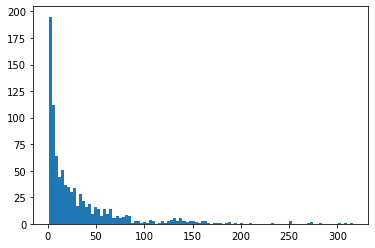

In [104]:
plt.hist(adata[1].X.sum(1), bins=100);

In [105]:
sc.pp.normalize_total(adata[1], target_sum=1e2)

In [106]:
sc.pp.scale(adata[1], max_value=10)

In [107]:
sc.tl.pca(adata[1], n_comps=100, svd_solver='arpack')

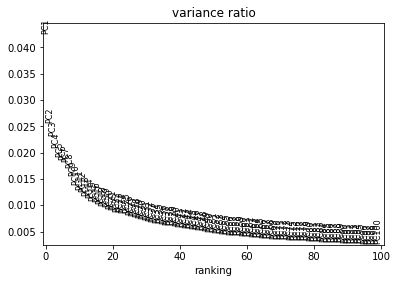

In [108]:
sc.pl.pca_variance_ratio(adata[1], n_pcs=100, log=False)

In [109]:
sc.pp.neighbors(adata[1], n_neighbors=15, metric='minkowski', n_pcs=20)

In [110]:
sc.tl.umap(adata[1], random_state=0)#, spread=3, min_dist=0.5, random_state=10)

In [111]:
adata[1].uns['dx_colors'] = [mpl.colors.rgb2hex(adjust_lightness(cond_colors['G'], 1.1)), cond_colors['G'], 'k']

... storing 'dx' as categorical
... storing 'Category' as categorical
... storing 'Genes' as categorical


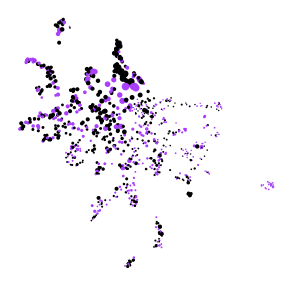

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(adata[1], color='dx', ax=ax, size=adata[1].obs['mean_sig']*5, frameon=False, title='', legend_loc=None)

In [113]:
sc.tl.leiden(adata[1], resolution=1, random_state=0)
# sc.tl.leiden(gene_adata, restrict_to=('leiden', ['13']), resolution=0.5)
# sc.tl.leiden(gene_adata, restrict_to=('leiden_R', ['6']), resolution=0.5)
# sc.tl.leiden(gene_adata, restrict_to=('leiden_R', ['14']), resolution=0.5)
# sc.tl.leiden(gene_adata, restrict_to=('leiden_R', ['10']), resolution=0.5)
# sc.tl.leiden(gene_adata, restrict_to=('leiden_R', ['9']), resolution=0.2)

# try:
#     del(gene_adata.uns['leiden_colors'])
# except:
#     pass
# try:
#     del(gene_adata.uns['leiden_R_colors'])
# except:
#     pass

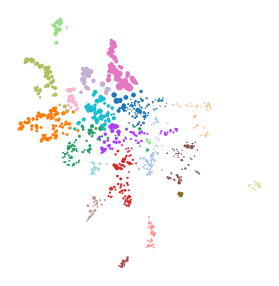

In [114]:
fig, ax = plt.subplots(figsize=(4.75, 5))
ax.set_facecolor('gray')
sc.pl.umap(adata[1], color=['leiden'], ax=ax, size=adata[1].obs['mean_sig']*5, frameon=False, title='', legend_loc=None)

In [115]:
get_id_1 = lambda x: adata[1].var['Name'][adata[1].var['Name'] == x].index[0]

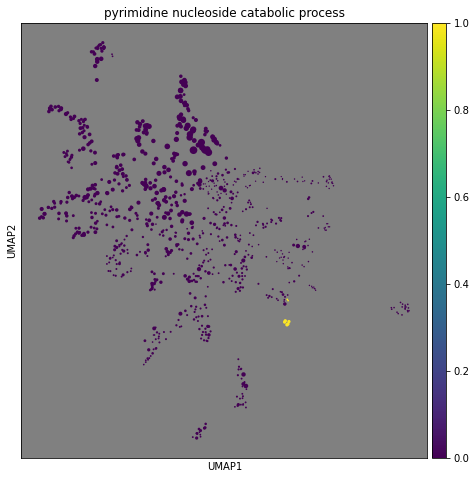

In [116]:
pathway = 'pyrimidine nucleoside catabolic process'
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('gray')
sc.pl.umap(adata[1], color=[get_id_1(pathway)], 
           use_raw=True, 
           ax=ax, size=adata[1].obs['mean_sig']*5, title=pathway, legend_loc=None)

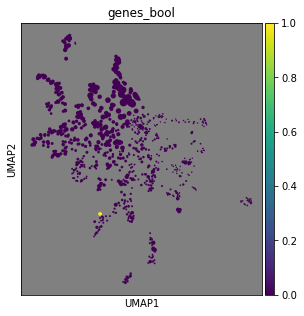

In [117]:
genes = ['SP100']
fig, ax = plt.subplots(figsize=(4.75, 5))
ax.set_facecolor('gray')
col_name = 'genes_bool'
adata[1].obs[col_name] = adata[1].obs_names.isin(genes)
sc.pl.umap(adata[1], color=[col_name], 
           use_raw=True, 
           ax=ax, size=adata[1].obs['mean_sig']*5, title=col_name, legend_loc=None)
adata[1].obs.drop(col_name, axis=1, inplace=True)

In [118]:
sc.tl.rank_genes_groups(adata[1], groupby='leiden', method='wilcoxon', n_genes=100)

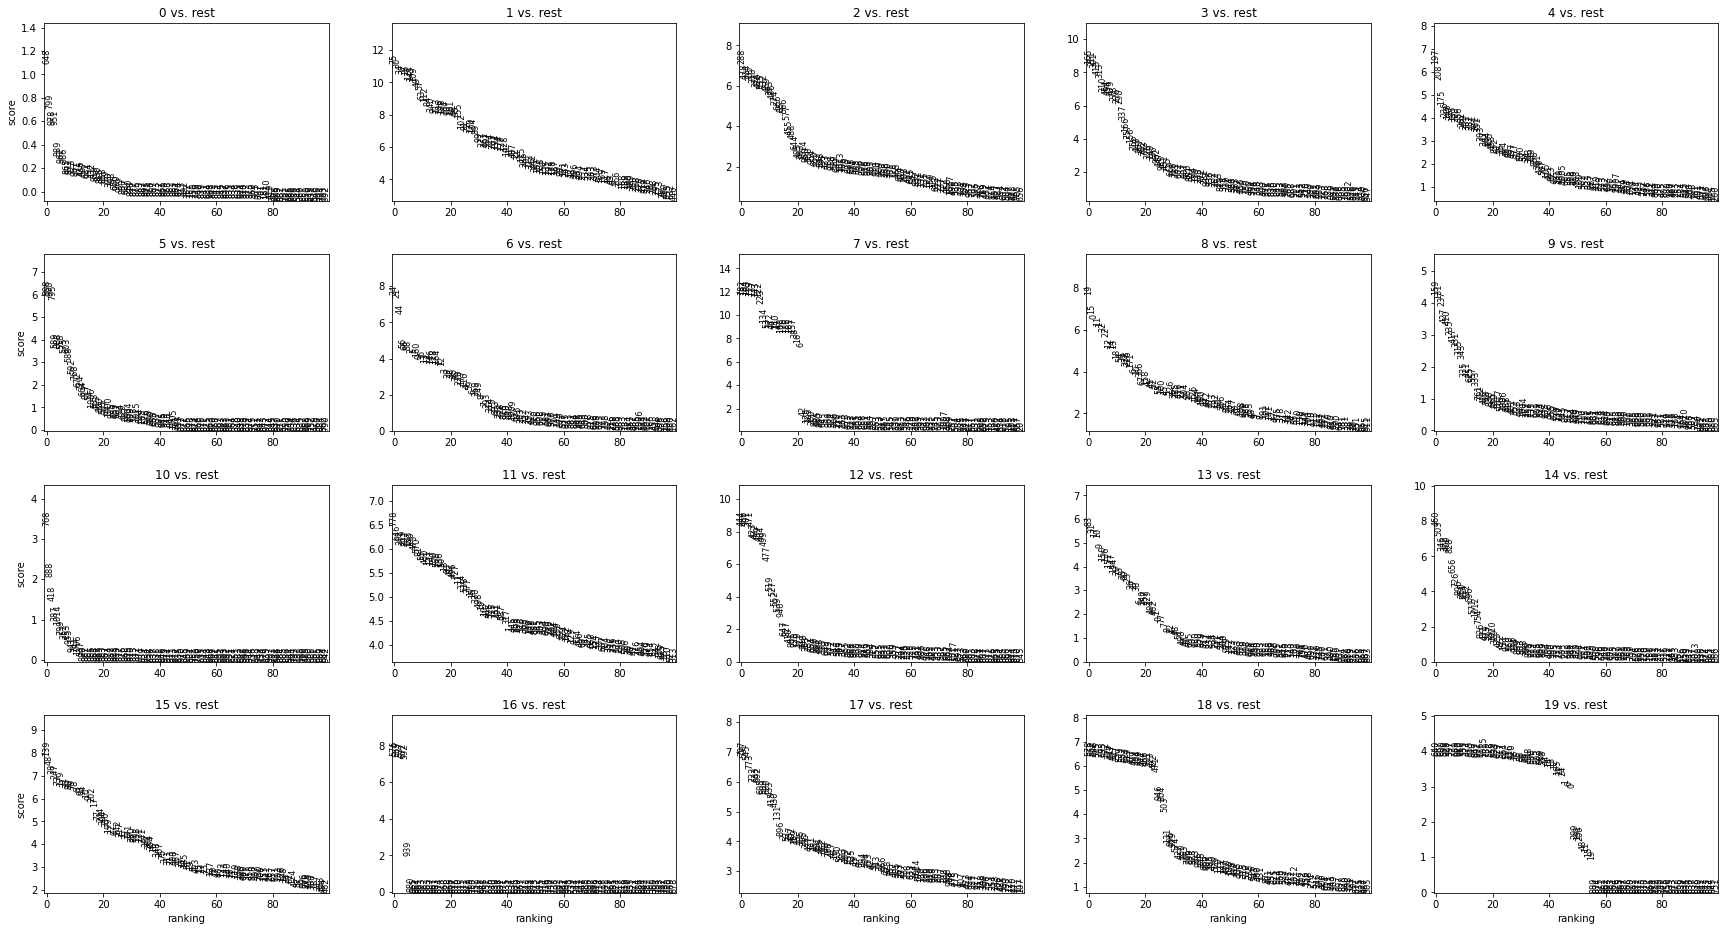

In [119]:
sc.pl.rank_genes_groups(adata[1], n_genes=100, ncols=5, sharey=False)

In [120]:
num_features = [
    5, 40, 20, 25, 40, 
    20, 40, 20, 20, 15,
    10, 40, 15, 30, 15,
    60, 5, 10, 30, 50
]

In [144]:
for clust, num in zip(adata[1].obs['leiden'].cat.categories, num_features):
    print(clust)
    print('\n'.join([adata[1].var.loc[i, 'Name'] for i in adata[1].uns['rank_genes_groups']['names'][clust][:num]]))
    print('')

0
DNA biosynthetic process
protein phosphopantetheinylation
ceramide biosynthetic process
glycosphingolipid metabolic process
protein folding

1
lymphocyte activation
immune system development
hemopoiesis
hematopoietic or lymphoid organ development
leukocyte activation
regulation of leukocyte activation
regulation of lymphocyte activation
regulation of cell activation
leukocyte differentiation
T cell activation
mononuclear cell differentiation
regulation of T cell activation
regulation of hemopoiesis
regulation of cell adhesion
positive regulation of immune system process
lymphocyte differentiation
positive regulation of leukocyte activation
regulation of cell-cell adhesion
cell-cell adhesion
positive regulation of cell activation
regulation of leukocyte cell-cell adhesion
regulation of leukocyte differentiation
leukocyte cell-cell adhesion
positive regulation of lymphocyte activation
T cell differentiation
regulation of lymphocyte differentiation
positive regulation of leukocyte cell-

### Compare

#### Multiple

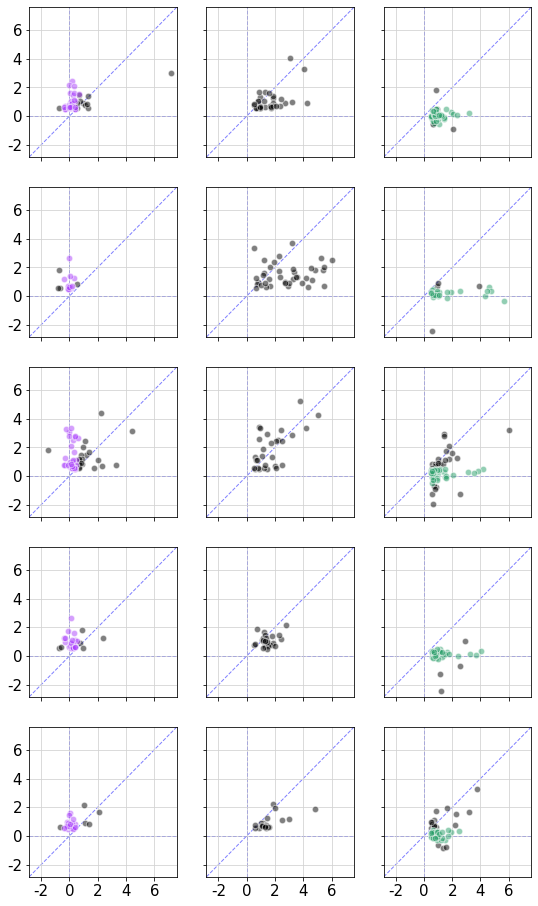

In [121]:
fig, ax_arr = plt.subplots(5, 3, figsize=(9, 16), sharex=True, sharey=True)
labels = [
    'kinase/transferase activity', 
    'viral response', 
    'lymphocyte activ./prolif./diff.',
    'exocytosis and neutrophil degranulation',
    'response to compounds, lipids, peptides'
]

comparisons = [
    (2, 2), 
    (5, 6),
    (0, 1),
    (6, 7),
    (3, 9)
]

tick_freq = 2
lims = list()

for row_ax, label, (clust0, clust1) in tqdm(zip(ax_arr, labels, comparisons)):
    nx_group0 = adata[0].obs_names[adata[0].obs['leiden'] == str(clust0)]
    nx_group1 = adata[1].obs_names[adata[1].obs['leiden'] == str(clust1)]
    
    nx0_specific = np.setdiff1d(nx_group0, nx_group1)
    shared = np.intersect1d(nx_group0, nx_group1)
    nx1_specific = np.setdiff1d(nx_group1, nx_group0)
    
    for ax, gene_group in zip(row_ax, [nx1_specific, shared, nx0_specific]): # put condition 1 (G) on the left because it's on the y axis in the earlier plots
        for dx, c in zip(['0u1u', '0u1d', '0d1u', '0u1n', '0n1u'], ['k', 'k', 'k', cond_colors['B'], cond_colors['G']]):
            plot_genes = np.intersect1d(de['mrna']['compare'].index[de['mrna']['bool_dict'][dx]], gene_group)
            if len(plot_genes) > 0:
                plot_df = de['mrna']['compare'].loc[plot_genes]
                ax.scatter(plot_df['l0'].values, plot_df['l1'].values, color=c, s=40, edgecolor=(1, 1, 1, 1), alpha=0.5)
                lims.append(ax.get_xlim())
                lims.append(ax.get_ylim())
lim = (min(np.array(lims).min(0)), max(np.array(lims).max(0)))

ticks = np.arange(np.floor(lim[0]), np.ceil(lim[1]), tick_freq).astype(int)
if 0 not in ticks:
    ticks = np.arange(np.floor(lim[0] + 1), np.ceil(lim[1]), tick_freq).astype(int)

for ax in np.ravel(ax_arr):
    ax.set_xlim(lim)
    ax.set_ylim(lim)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks.astype(str), fontsize=15)
    ax.set_yticklabels(ticks.astype(str), fontsize=15)

    ax.plot(lim, lim, linewidth=1, linestyle='--', color='blue', alpha=0.5, zorder=-1)
    ax.plot(lim, [0, 0], linewidth=1, linestyle='--', color='blue', zorder=-1)
    ax.plot([0, 0], lim,  linewidth=1, linestyle='--', color='blue', zorder=-1)

    ax.grid(color='lightgray')
    ax.set_axisbelow(True)

#### Single

In [205]:
comparison = (0, 14)

In [206]:
group0 = adata[0].obs_names[adata[0].obs['leiden'] == str(comparison[0])]
group1 = adata[1].obs_names[adata[1].obs['leiden'] == str(comparison[1])]

In [ ]:
gene_sets = dict()
unique_gene_set_id = it.count()
print('B-specific')
for dx in ['0u1u', '0u1n', '0u1d']:
    print(dx)
    uniq_id = next(unique_gene_set_id)
    gene_sets[uniq_id] = np.intersect1d(de['mrna']['compare'].index[de['mrna']['bool_dict'][dx]], np.setdiff1d(group0, group1))
    print(str(uniq_id) + ': ' + str(list(gene_sets[uniq_id])))
print()
print('shared')
uniq_id = next(unique_gene_set_id)
gene_sets[uniq_id] = np.intersect1d(group0, group1)
print(str(uniq_id) + ': ' + str(list(gene_sets[uniq_id])))
print()
print('G-specific')
for dx in ['0u1u', '0n1u', '0d1u']:
    print(dx)
    uniq_id = next(unique_gene_set_id)
    gene_sets[uniq_id] = np.intersect1d(de['mrna']['compare'].index[de['mrna']['bool_dict'][dx]], np.setdiff1d(group1, group0))
    print(str(uniq_id) + ': ' + str(list(gene_sets[uniq_id])))

In [ ]:
print("############## IFNG ##############")
de['mrna']['compare'].loc[np.concatenate([gene_sets[5], gene_sets[6]])].sort_values(by='l1', ascending=False).head(10)

In [ ]:
print("############## SHARED ##############")
sub_de_compare = de['mrna']['compare'].loc[gene_sets[3]].copy()
sub_de_compare['l0l1_mean'] = sub_de_compare[['l0', 'l1']].mean(1)
sub_de_compare.sort_values(by='l0l1_mean', ascending=False).head(20)

In [ ]:
print("############## IFNB ##############")
de['mrna']['compare'].loc[np.concatenate([gene_sets[1], gene_sets[2]])].sort_values(by='l0', ascending=False).head(10)

Three functions for grabbing genes from the enrich results, plotting, and adding labels with gene names that "repel" each other.

## Plot Specific Genes

In [178]:
def repel_labels(ax, x, y, labels, k=0.01, scale=10):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)
#     pos = nx.spiral_layout(G, scale=scale)

    # undo spring_layout's rescaling
#     pos_after = np.vstack([pos[d] for d in data_nodes])
#     pos_before = np.vstack([init_pos[d] for d in data_nodes])
#     scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
#     scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
#     shift = np.array([shift_x, shift_y])
#     for key, val in pos.items():
#         pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="-",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='lightgray'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])
    return ax

In [189]:
def plot_with_genes(check_genes_bool):
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    sp0 = de['mrna']['compare'][(de['mrna']['bool_dict']['0u1n'] | de['mrna']['bool_dict']['0d1n']) & check_genes_bool]
    sp1 = de['mrna']['compare'][(de['mrna']['bool_dict']['0n1u'] | de['mrna']['bool_dict']['0n1d']) & check_genes_bool]
    shared = de['mrna']['compare'][(de['mrna']['bool_dict']['0u1u'] | de['mrna']['bool_dict']['0d1d'] | de['mrna']['bool_dict']['0u1d'] | de['mrna']['bool_dict']['0d1u']) & check_genes_bool]
    labels = sp0.index.tolist() + sp1.index.tolist() + shared.index.tolist()

    x1, x2, x3 = (sp0['l0'].values, sp1['l0'].values, shared['l0'].values)
    y1, y2, y3 = (sp0['l1'].values, sp1['l1'].values, shared['l1'].values)
    x = np.concatenate([x1, x2, x3])
    y = np.concatenate([y1, y2, y3])
    c = [cond_colors['B']]*len(x1) + [cond_colors['G']]*len(x2) + ['k']*len(x3)
    ax[0].scatter(x, y, s=10, alpha=0.5, color=c)
    ax[0].set_ylim(lim)
    ax[0].set_xlim(lim)
    ax[0].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
    ax[0].plot(lim, [0, 0], color='gray', linewidth=0.5, linestyle='--')
    ax[0].plot([0, 0], lim, color='gray', linewidth=0.5, linestyle='--')
    ax[0].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
    ax[0].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks


    ax[1].scatter(x, y, s=20, alpha=0.5, color=c)
    ax[1].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
    ax[1].plot(lim, [0, 0], color='gray', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 0], lim, color='gray', linewidth=0.5, linestyle='--')
    ax[1] = repel_labels(ax[1], x, y, labels, k=1)
    ax[1].set_ylim(lim)
    ax[1].set_xlim(lim)
    ax[1].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
    ax[1].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks
    
    plt.show()

In [182]:
def get_genes_from_enrich(genes_col, unique=True):
    split = [k.split(',') for k in genes_col]
    if not unique:
        return split
    else:
        genes = [i for j in split for i in j]
        return np.unique(genes)

In [227]:
# df = adata[1].var[adata[1].var['Name'].str.contains('MHC class II')]
df = adata[0].var[adata[0].var['Genes'].str.contains(',JUP,')]

In [228]:
display(df.head())
display(df[df['Name'].str.contains('localization|transport')])

Name Category   QValueFDRBH  \
2                             immune effector process       BP  3.999505e-49   
15                               leukocyte activation       BP  1.695667e-28   
30  positive regulation of DNA-binding transcripti...       BP  1.229233e-21   
32                                    membrane fusion       BP  2.117111e-21   
39  regulation of DNA-binding transcription factor...       BP  7.966201e-20   

                                                Genes  GenesInTermInQuery  \
2   SHFL,LILRB2,NT5C3A,NCF1,TLR7,DTX3L,MDK,DYSF,AD...                 239   
15  ABL2,LILRB2,TLR7,MDK,DYSF,ADA,TLR8,PLAC8,FABP5...                 203   
30  PIK3AP1,ABL2,SHISA5,TLR7,TFG,TRIM22,TLR8,NOD1,...                 108   
32  LILRB2,KIAA0319L,CD109,DYSF,PLAC8,RAB8A,FABP5,...                 158   
39  PIK3AP1,ABL2,SHISA5,TLR7,TFG,TRIM22,TLR8,FANCA...                 121   

    -log10FDR      mean       std  
2   48.397994  0.510984  1.442382  
15  27.770660  0.373699  1.093807  
30  20.910366  0.261521  1.415983  
32  20.674256  0.527713  2.026796  
39  19.098749  0.290614  1.446078

Name Category  QValueFDRBH  \
599                    positive regulation of transport       BP     0.000723   
653                  regulation of protein localization       BP     0.001722   
728                       regulation of anion transport       BP     0.003942   
789                positive regulation of ion transport       BP     0.006357   
817                     regulation of peptide transport       BP     0.007617   
848                 regulation of cellular localization       BP     0.008549   
942   regulation of establishment of protein localiz...       BP     0.016408   
1007                    regulation of protein transport       BP     0.023183   
1130      regulation of intracellular protein transport       BP     0.032601   

                                                  Genes  GenesInTermInQuery  \
599   EPHB2,MEF2A,ACSL1,ADRB2,ATP8A1,PGAP1,CXCL9,TRP...                  97   
653   EPHB2,EPS15,DTX3L,TRIM22,RAB8A,NDC80,SLC9B2,CC...                  92   
728   ADA,MEF2A,RAB8A,FABP5,ACSL1,ATP8A1,SLC9B2,CCL2...                  90   
789   EPHB2,MEF2A,ACSL1,ADRB2,ATP8A1,CXCL9,TRPV2,CCL...                  72   
817   RAB8A,SLC9B2,CCL2,CCL5,FKBP1B,ANG,ITSN1,PIWIL4...                  64   
848   EPHB2,DTX3L,PTK2B,ADRB2,NDC80,PGAP1,CXCL9,SLC9...                  82   
942   RAB8A,SLC9B2,CCL2,CCL5,FKBP1B,ANG,PIWIL4,RUFY3...                  61   
1007  RAB8A,SLC9B2,CCL2,CCL5,FKBP1B,ANG,PIWIL4,RUFY3...                  58   
1130  CCL2,RUFY3,SP100,GAS6,BARD1,BCL2,BNIP3L,NUCB1,...                  29   

      -log10FDR      mean       std  
599    3.140674  0.230406  1.344948  
653    2.763879  0.357599  2.196528  
728    2.404306  0.259385  1.382902  
789    2.196759  0.142328  0.673996  
817    2.118193  0.164698  0.880753  
848    2.068100  0.307199  2.274726  
942    1.784942  0.170386  0.962881  
1007   1.634837  0.149458  0.854753  
1130   1.486765  0.068489  0.567633

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempting to set identical left == right == 2.57565885809529 results in singular transformations; automatically expanding.
/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Attempting to set identical bottom == top == -0.669074967007157 results in singular transformations; automatically expanding.


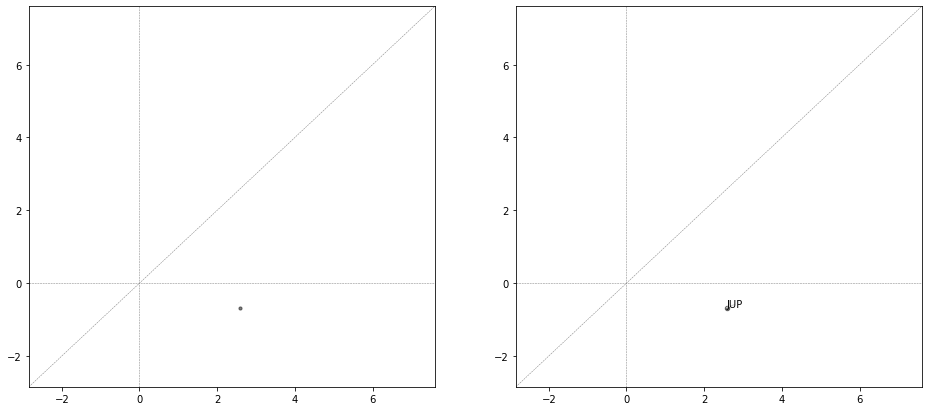

In [226]:
# plot_with_genes(de['mrna']['compare'].index.isin(get_genes_from_enrich(df[df['Name'].str.contains('localization|transport')]['Genes'])))
plot_with_genes(de['mrna']['compare'].index.isin(['JUP']))

## Find Unannotated Genes

In [123]:
dem['enrich'] = dict()
enrich = dem['enrich']
for i in [0, 1]:
    enrich[i] = dict()
    for j in ['+', '-']:
        enrich[i][j] = dict()

### Run Using Lax Thresholds

In [132]:
pthresh_keep = 0.2
pthresh_ns = 0.2
lthresh = 0
dem['bool_dict'] = create_bool_dict(dem['compare'], combos=combos, pthresh_keep=pthresh_keep, pthresh_ns=pthresh_ns, lthresh=lthresh)

enrich[0]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0u1n'] | dem['bool_dict']['0u1d']].values
enrich[1]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0n1u'] | dem['bool_dict']['0d1u']].values
enrich[0]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0d1n'] | dem['bool_dict']['0d1u']].values
enrich[1]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0n1d'] | dem['bool_dict']['0u1d']].values

In [133]:
for i in [0, 1]:
    for j in ['+', '-']:
        print((str(i) + j, enrich[i][j]['genes'].shape))

('0+', (2306,))
('0-', (3889,))
('1+', (2415,))
('1-', (1966,))


In [134]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['%annot'], enrich[i][j]['results'] = get_enrichment(enrich[i][j]['genes'])
        enrich[i][j]['results']['Category'] = enrich[i][j]['results'].replace({
            'GeneOntologyBiologicalProcess': 'BP',
            'GeneOntologyMolecularFunction': 'MF',
            'GeneOntologyCellularComponent': 'CC'
        })
        enrich[i][j]['results'] = enrich[i][j]['results'][['Category', 'Name', 'QValueFDRBH', 'Genes', 'GenesInTermInQuery', '-log10FDR']].copy()

In [135]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['results_sig'] = enrich[i][j]['results'][enrich[i][j]['results']['QValueFDRBH'] < 0.2].sort_values(by='-log10FDR', ascending=False).set_index('Name').copy()

In [136]:
gene_split_lax = [i.split(',') for i in enrich[0]['+']['results_sig']['Genes']]
gene_split_flat_lax = [i for j in gene_split_lax for i in j]
gene_unique_lax = np.unique(gene_split_flat_lax)

In [137]:
unannotated = de['mrna']['compare'].loc[np.setdiff1d(de['mrna']['compare'].index.values, gene_unique_lax)].sort_values(by='l0', ascending=False)

In [138]:
unannotated[((unannotated['l0'] > 1.5) & (unannotated['p0'] < 1e-10))].index

Index(['ACOD1', 'CALHM6', 'SPATS2L', 'TTC9', 'EPSTI1', 'KIAA0040', 'TMEM140',
       'TRANK1', 'TENT5A', 'ANKRD22', 'LGALS2', 'AC004988.1', 'KCTD14', 'ADA2',
       'TMEM268', 'KLHDC7B', 'C19orf66', 'GPR141', 'TMEM62', 'RBM43',
       'GUCY1A1', 'AC083862.2', 'BISPR', 'AC116407.2', 'CGAS', 'AL591468.1',
       'TENT4A', 'CMTR1', 'SLFN12', 'HAPLN3', 'ADPRHL2', 'AC009948.1', 'NRIR',
       'LINC02574', 'LYSMD2', 'WARS', 'USP30-AS1', 'IGHEP2', 'APOBEC3B-AS1',
       'AC124319.2', 'HRASLS2', 'PTPA', 'CAVIN3', 'AC009133.1', 'LINC01410',
       'KIAA1522', 'RARRES3', 'FAM122C', 'LINC00996', 'HDX', 'SELENOO',
       'CCDC194', 'TTC7B', 'FAM71A', 'GPR180', 'AL021707.6', 'SLC18B1'],
      dtype='object')

In [142]:
# unannotated.to_pickle(prefix + 'mrna/pkls/unannotated.pkl')

'/data/codec/production.run/'

## Extra

### Make Bar Plots

In [35]:
enrich[0]['+']['top_terms'] = joined_up.sort_values(by=('B', '-log10FDR'), ascending=False).index[:150]
enrich[1]['+']['top_terms'] = joined_up.sort_values(by=('G', '-log10FDR'), ascending=False).index[:150]

In [36]:
df = joined_up.loc[np.intersect1d(enrich[0]['+']['top_terms'], enrich[1]['+']['top_terms'])].xs('-log10FDR', level=1, axis=1)
print(df.shape)
df.sort_values(by='B', ascending=False).head(80).tail(10)

(82, 2)


B         G
interferon-alpha production                         5.095491  4.896555
regulation of interferon-alpha production           5.095491  4.896555
positive regulation of innate immune response       4.908426  5.004360
interferon-gamma production                         4.838730  4.823647
regulation of defense response to virus by host     4.828707  4.867577
positive regulation of defense response to viru...  4.756494  4.618887
regulation of inflammatory response                 4.634880  5.971944
positive regulation of interferon-beta production   4.539635  4.441899
regulation of leukocyte proliferation               4.418274  5.796127
endosome                                            4.237534  7.628097

In [37]:
highlight_terms = \
[
    'cellular response to cytokine stimulus',
    'cellular response to interferon-gamma',
    'cellular response to type I interferon',
    'cytokine production',
    'defense response to virus',
    'immune effector process',
    'inflammatory response',
    'innate immune response',
    'leukocyte activation',
    'regulation of viral process',
    'response to bacterium',
    'immune system development',
    'hematopoietic or lymphoid organ development',
    'leukocyte mediated immunity',
    'hemopoiesis',
    'myeloid leukocyte activation',
    'regulation of DNA-binding transcription factor activity',
    'positive regulation of programmed cell death',
    'positive regulation of interleukin-1 beta production',
    'response to tumor necrosis factor',
    'negative regulation of multicellular organismal process',
    'positive regulation of NF-kappaB transcription factor activity',
    'adaptive immune response'
]

# restrict to 10
highlight_terms = highlight_terms[:10]

In [38]:
df_plot = joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].rename_axis('term', axis=0).reset_index().melt(id_vars='term', var_name='cond', value_name='-log10FDR')
df_plot['term'] = df_plot['term'].apply(lambda x: '\n'.join(wrap(x, max_lines=2)))

In [39]:
order = ['\n'.join(wrap(i, max_lines=2)) for i in joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].sort_values(by='B', ascending=False).index]

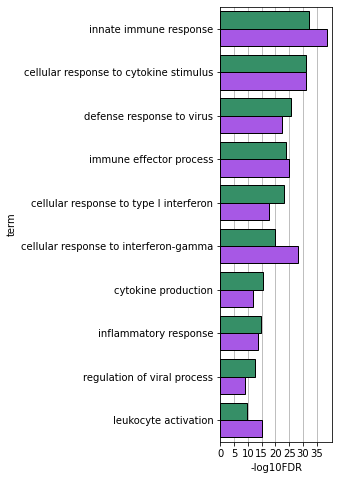

In [40]:
fig, ax = plt.subplots(figsize=(2,8))
ax = sns.barplot(data=df_plot, y='term', x='-log10FDR', hue='cond', order=order, orient="h", palette=[cond_colors['B'], cond_colors['G']], edgecolor='k', ax=ax)
ax.set_xticks(range(0, 40, 5))
ax.grid(axis='x')
ax.set_axisbelow(True)
ax.get_legend().remove()

In [41]:
enrich[0]['-']['top_terms'] = joined_down.sort_values(by=('B', '-log10FDR'), ascending=False).index[:100]
enrich[1]['-']['top_terms'] = joined_down.sort_values(by=('G', '-log10FDR'), ascending=False).index[:100]

In [42]:
df = joined_down.loc[np.intersect1d(enrich[0]['-']['top_terms'], enrich[1]['-']['top_terms'])].xs('-log10FDR', level=1, axis=1)
print(df.shape)
df.sort_values(by='B', ascending=False).head(60).tail(10)

(86, 2)


B         G
cellular response to biotic stimulus              5.300648  5.686584
focal adhesion                                    5.279241  6.322010
cell-substrate junction                           5.162864  6.196997
regulation of locomotion                          5.121516  7.148656
cell surface                                      5.058402  5.471422
regulation of cell migration                      4.995501  7.058305
regulation of anatomical structure morphogenesis  4.995501  5.465874
regulation of cell motility                       4.995501  7.034237
response to bacterium                             4.973796  4.874346
positive regulation of angiogenesis               4.944155  5.274065

In [43]:
highlight_terms = \
[
    'myeloid leukocyte activation',
    'leukocyte migration',
    'secretory granule',
    'cell chemotaxis',
    'inflammatory response',
    'chemokine activity',
    'cellular response to lipopolysaccharide',
    'regulation of cell adhesion',
    'CXCR chemokine receptor binding',
    'positive regulation of angiogenesis'
]

# restrict to 10
highlight_terms = highlight_terms[:10]

In [44]:
df_plot = joined_down.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].rename_axis('term', axis=0).reset_index().melt(id_vars='term', var_name='cond', value_name='-log10FDR')
df_plot['term'] = df_plot['term'].apply(lambda x: '\n'.join(wrap(x, max_lines=2)))

In [45]:
order = ['\n'.join(wrap(i, max_lines=2)) for i in joined_down.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].sort_values(by='B', ascending=False).index]

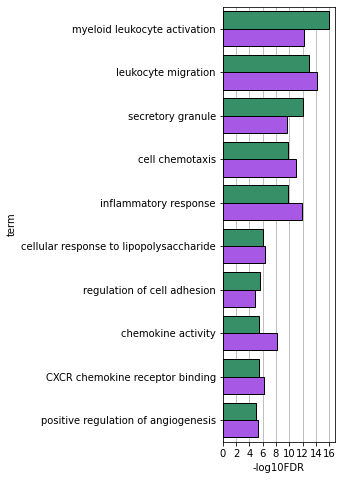

In [46]:
fig, ax = plt.subplots(figsize=(2,8))
ax = sns.barplot(data=df_plot, y='term', x='-log10FDR', hue='cond', order=order, orient="h", palette=[cond_colors['B'], cond_colors['G']], edgecolor='k', ax=ax)
ax.set_xticks(range(0, 18, 2))
ax.grid(axis='x')
ax.set_axisbelow(True)
ax.get_legend().remove()

In [47]:
df_show = joined_up[joined_up[('G', '-log10FDR')] == 0].sort_values(by=('B', '-log10FDR'), ascending=False)
print(df_show.shape)
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', 70):
    display(df_show.head(70).tail(10))

(307, 12)


B  \
                                                                    Category   
extrinsic apoptotic signaling pathway in absence of ligand                BP   
animal organ regeneration                                                 BP   
positive regulation of catabolic process                                  BP   
G protein-coupled receptor binding                                        MF   
ficolin-1-rich granule                                                    CC   
eosinophil migration                                                      BP   
regulation of neuron death                                                BP   
protein catabolic process                                                 BP   
positive regulation of locomotion                                         BP   
regulation of tumor necrosis factor superfamily cytokine production       BP   

                                                                                 \
                                                                    QValueFDRBH   
extrinsic apoptotic signaling pathway in absence of ligand             0.002236   
animal organ regeneration                                              0.002236   
positive regulation of catabolic process                               0.002290   
G protein-coupled receptor binding                                     0.002501   
ficolin-1-rich granule                                                 0.002531   
eosinophil migration                                                   0.002648   
regulation of neuron death                                             0.002660   
protein catabolic process                                              0.002780   
positive regulation of locomotion                                      0.002901   
regulation of tumor necrosis factor superfamily cytokine production    0.002914   

                                                                                                                                            \
                                                                                                                                     Genes   
extrinsic apoptotic signaling pathway in absence of ligand                                 MCL1,KITLG,HSPA1A,HSPA1B,FAS,IFI6,IL7,CASP3,RET   
animal organ regeneration                                                                   HMOX1,ADM,PNPT1,CXCL12,AXL,GAS6,ACE,NR4A3,LIFR   
positive regulation of catabolic process                             CTSC,DTX3L,HMOX1,PLEKHN1,TRIM22,MEFV,PNPT1,ZC3H12D,ABCD1,HSPA1A,HS...   
G protein-coupled receptor binding                                   ADM,CXCL9,CCL2,CCL3,CCL4,CCL7,CCL8,CXCL11,HSPA1A,HSPA1B,CXCL12,CXC...   
ficolin-1-rich granule                                               HSPA1A,HSPA1B,MNDA,HSP90AA1,PRDX4,CST3,CTSB,CTSZ,FGL2,DSP,SIGLEC14...   
eosinophil migration                                                                                              CCL2,CCL3,CCL4,CCL7,CCL8   
regulation of neuron death                                           HLA-F,MCL1,HMOX1,CCL2,CCL3,FMR1,FAS,CTSZ,LGMN,AXL,BAG1,JAK2,KCNMA1...   
protein catabolic process                                            USP18,UBE2L6,CTSC,USP25,DTX3L,UBA7,SAMD9L,HSPA1A,HSPA1B,TRIM38,HSP...   
positive regulation of locomotion                                    ENPP2,HMOX1,KITLG,RIN2,CCL2,CCL3,CCR1,CCL4,CCL7,CCL8,CMKLR1,CXCL12...   
regulation of tumor necrosis factor superfamily cytokine production  CCL2,CCL3,LILRA5,CD274,MYD88,AXL,GAS6,RIPK2,JAK2,IFIH1,TNFSF18,TLR...   

                                                                                        \
                                                                    GenesInTermInQuery   
extrinsic apoptotic signaling pathway in absence of ligand                         9.0   
animal organ regeneration                                                          9.0   
positive regulation of catabolic process            

In [48]:
highlight_terms = \
[
    'positive regulation of leukocyte migration',
    'double-stranded RNA binding',
    'organic cyclic compound catabolic process',
    'regulation of natural killer cell chemotaxis',
    'positive regulation of calcium ion transport',
    'regulation of myeloid cell differentiation',
    'negative regulation of apoptotic process',
    'lipopolysaccharide-mediated signaling pathway',
    'toll-like receptor 7 signaling pathway',
    'G protein-coupled receptor binding'
]

# restrict to 10
highlight_terms = highlight_terms[:10]

In [49]:
df_plot = joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].rename_axis('term', axis=0).reset_index().melt(id_vars='term', var_name='cond', value_name='-log10FDR')
df_plot['term'] = df_plot['term'].apply(lambda x: '\n'.join(wrap(x, max_lines=2)))
df_plot = df_plot[df_plot['cond'] == 'B'].copy()

In [50]:
order = ['\n'.join(wrap(i, max_lines=2)) for i in joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].sort_values(by='B', ascending=False).index]

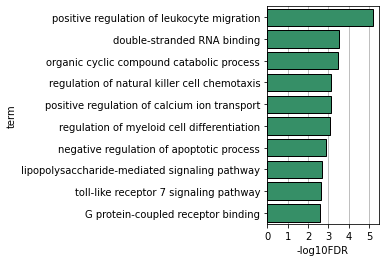

In [51]:
fig, ax = plt.subplots(figsize=(2,4))
ax = sns.barplot(data=df_plot, y='term', x='-log10FDR', hue='cond', order=order, orient="h", palette=[cond_colors['B']], edgecolor='k', ax=ax)
ax.set_xticks(range(0, 6, 1))
ax.grid(axis='x')
ax.set_axisbelow(True)
ax.get_legend().remove()

In [52]:
df_show = joined_up[joined_up[('B', '-log10FDR')] == 0].sort_values(by=('G', '-log10FDR'), ascending=False)
print(df_show.shape)
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', 70):
    display(df_show.head(90).tail(10))

(198, 12)


B  \
                                                                       Category   
positive regulation of fatty acid transport                                   0   
regulation of interleukin-4-mediated signaling pathway                        0   
cellular response to cycloheximide                                            0   
myeloid dendritic cell antigen processing and presentation                    0   
regulation of macrophage activation                                           0   
regulation of memory T cell differentiation                                   0   
early endosome                                                                0   
immunoglobulin production involved in immunoglobulin-mediated immun...        0   
interleukin-27 receptor binding                                               0   
cytokine receptor activity                                                    0   

                                                                                    \
                                                                       QValueFDRBH   
positive regulation of fatty acid transport                                    0.0   
regulation of interleukin-4-mediated signaling pathway                         0.0   
cellular response to cycloheximide                                             0.0   
myeloid dendritic cell antigen processing and presentation                     0.0   
regulation of macrophage activation                                            0.0   
regulation of memory T cell differentiation                                    0.0   
early endosome                                                                 0.0   
immunoglobulin production involved in immunoglobulin-mediated immun...         0.0   
interleukin-27 receptor binding                                                0.0   
cytokine receptor activity                                                     0.0   

                                                                              \
                                                                       Genes   
positive regulation of fatty acid transport                                0   
regulation of interleukin-4-mediated signaling pathway                     0   
cellular response to cycloheximide                                         0   
myeloid dendritic cell antigen processing and presentation                 0   
regulation of macrophage activation                                        0   
regulation of memory T cell differentiation                                0   
early endosome                                                             0   
immunoglobulin production involved in immunoglobulin-mediated immun...     0   
interleukin-27 receptor binding                                            0   
cytokine receptor activity                                                 0   

                                                                                           \
                                                                       GenesInTermInQuery   
positive regulation of fatty acid transport                                           0.0   
regulation of interleukin-4-mediated signaling pathway                                0.0   
cellular response to cycloheximide                                                    0.0   
myeloid dendritic cell antigen processing and presentation                            0.0   
regulation of macrophage activation                                                   0.0   
regulation of memory T cell differentiation                                           0.0   
early endosome                                                                        0.0   
immunoglobulin production involved in immunoglobulin-mediated immun...                0.0   
interleukin-27 receptor binding                                                       0.0   
cytokine receptor activity                                      

In [53]:
highlight_terms = \
[
    'MHC class II protein complex',
    'endocytic vesicle membrane',
    'MHC class II receptor activity',
    'T-helper 1 type immune response',
    'T cell receptor signaling pathway',
    'B cell mediated immunity',
    'macrophage differentiation',
    'cellular response to interleukin-6',
    'cellular response to interleukin-3',
    'tyrosine phosphorylation of STAT protein', 
]


# restrict to 10
highlight_terms = highlight_terms[:10]

In [54]:
df_plot = joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].rename_axis('term', axis=0).reset_index().melt(id_vars='term', var_name='cond', value_name='-log10FDR')
df_plot['term'] = df_plot['term'].apply(lambda x: '\n'.join(wrap(x, max_lines=2)))
df_plot = df_plot[df_plot['cond'] == 'G'].copy()

In [55]:
order = ['\n'.join(wrap(i, max_lines=2)) for i in joined_up.xs('-log10FDR', level=1, axis=1).loc[highlight_terms].sort_values(by='B', ascending=False).index]

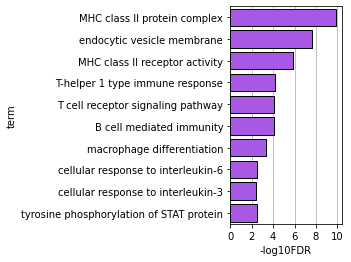

In [56]:
fig, ax = plt.subplots(figsize=(2,4))
ax = sns.barplot(data=df_plot, y='term', x='-log10FDR', hue='cond', order=order, orient="h", palette=[cond_colors['G']], edgecolor='k', ax=ax)
ax.set_xticks(range(0, 12, 2))
ax.grid(axis='x')
ax.set_axisbelow(True)
ax.get_legend().remove()

### Other

In [145]:
pthresh_keep = 0.05
pthresh_ns = 0.05
lthresh = 1
dem['bool_dict'] = create_bool_dict(dem['compare'], combos=combos, pthresh_keep=pthresh_keep, pthresh_ns=pthresh_ns, lthresh=lthresh)

enrich[0]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0u1n'] | dem['bool_dict']['0u1d']].values
enrich[1]['+']['genes'] = dem['compare'].index[dem['bool_dict']['0u1u'] | dem['bool_dict']['0n1u'] | dem['bool_dict']['0d1u']].values
enrich[0]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0d1n'] | dem['bool_dict']['0d1u']].values
enrich[1]['-']['genes'] = dem['compare'].index[dem['bool_dict']['0d1d'] | dem['bool_dict']['0n1d'] | dem['bool_dict']['0u1d']].values

In [146]:
for i in [0, 1]:
    for j in ['+', '-']:
        print((str(i) + j, enrich[i][j]['genes'].shape))

('0+', (510,))
('0-', (184,))
('1+', (369,))
('1-', (172,))


In [147]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['%annot'], enrich[i][j]['results'] = get_enrichment(enrich[i][j]['genes'])
        enrich[i][j]['results']['Category'] = enrich[i][j]['results'].replace({
            'GeneOntologyBiologicalProcess': 'BP',
            'GeneOntologyMolecularFunction': 'MF',
            'GeneOntologyCellularComponent': 'CC'
        })
        enrich[i][j]['results'] = enrich[i][j]['results'][['Category', 'Name', 'QValueFDRBH', 'Genes', 'GenesInTermInQuery', '-log10FDR']].copy()

In [148]:
for i in tqdm([0, 1]):
    for j in ['+', '-']:
        enrich[i][j]['results_sig'] = enrich[i][j]['results'][enrich[i][j]['results']['QValueFDRBH'] < 0.05].sort_values(by='-log10FDR', ascending=False).set_index('Name').copy()

In [179]:
gene_split_str = [i.split(',') for i in enrich[0]['+']['results_sig']['Genes']]
gene_split_flat_str = [i for j in gene_split_str for i in j]
gene_unique_str = np.unique(gene_split_flat_str)

In [340]:
gene_number_filter = 5
df_bool = pd.DataFrame(np.stack([[g in gl for g in gene_unique_str] for gl in gene_split_str]).T, index=gene_unique_str, columns=enrich[0]['+']['results_sig'].index).T
df_bool = df_bool[enrich[0]['+']['results_sig']['GenesInTermInQuery'] >= gene_number_filter].copy()

In [749]:
enrich[i][j]['results_sig'][enrich[i][j]['results_sig']['GenesInTermInQuery'] >= 5]

Category   QValueFDRBH  \
Name                                                                        
leukocyte migration                                      BP  6.605037e-15   
myeloid leukocyte activation                             BP  5.046730e-13   
neutrophil activation                                    BP  1.386881e-12   
granulocyte activation                                   BP  1.386881e-12   
inflammatory response                                    BP  1.386881e-12   
...                                                     ...           ...   
receptor metabolic process                               BP  4.826661e-02   
interferon-gamma production                              BP  4.853451e-02   
regulation of actin polymerization or depolymer...       BP  4.866503e-02   
positive regulation of hydrolase activity                BP  4.948418e-02   
actin filament polymerization                            BP  4.952655e-02   

                                                                                                Genes  \
Name                                                                                                    
leukocyte migration                                 NLRP12,C5AR2,GPR183,CAV1,ITGA5,ADGRE2,PPBP,ITG...   
myeloid leukocyte activation                        GLIPR1,MGAM,ATP8B4,SIGLEC9,CLEC5A,DOK3,VSIG4,L...   
neutrophil activation                               GLIPR1,MGAM,ATP8B4,SIGLEC9,CLEC5A,DOK3,LAIR1,R...   
granulocyte activation                              GLIPR1,MGAM,ATP8B4,SIGLEC9,CLEC5A,DOK3,LAIR1,R...   
inflammatory response                               TPST1,ANKRD42,NLRP12,PNMA1,FOS,C5AR2,PLD3,ADGR...   
...                                                                                               ...   
receptor metabolic process                                              DAB2,CAV1,CD9,LRP1,NUMB,CXCL8   
interferon-gamma production                                             SLC11A1,CD14,SASH3,IL1B,IL1R1   
regulation of actin polymerization or depolymer...                 CAPG,FMN1,TLR2,ARHGAP18,CCL24,VASP   
positive regulation of hydrolase activity           IL24,NLRP12,HIP1,ARHGAP26,C5AR2,CAV1,NLRC4,NRP...   
actin filament polymerization                                      CAPG,FMN1,TLR2,ARHGAP18,CCL24,VASP   

                                                    GenesInTermInQuery  \
Name                                                                     
leukocyte migration                                                 32   
myeloid leukocyte activation                                        33   
neutrophil activation                                               28   
granulocyte activation                                              28   
inflammatory response                                               35   
...                                                                ...   
receptor metabolic process                                           6   
interferon-gamma production                                          5   
regulation of actin polymerization or depolymer...                   6   
positive regulation of hydrolase activity                           15   
actin filament polymerization                                        6   

                                                    -log10FDR  
Name                                                           
leukocyte migration                                 14.180125  
myeloid leukocyte activation                        12.296990  
neutrophil activation                               11.857961  
granulocyte activation                              11.857961  
inflammatory response                               11.857961  
...                                                       ...  
receptor metabolic process                           1.316353  
interferon-gamma production                          1.313949  
regulation of actin polymerization or depolymer...   1.312783  
positive regulat

In [341]:
cM_B_results = pd.read_pickle(sc_prefix + 'combined/pkls/cM_B_memento2D.pkl')

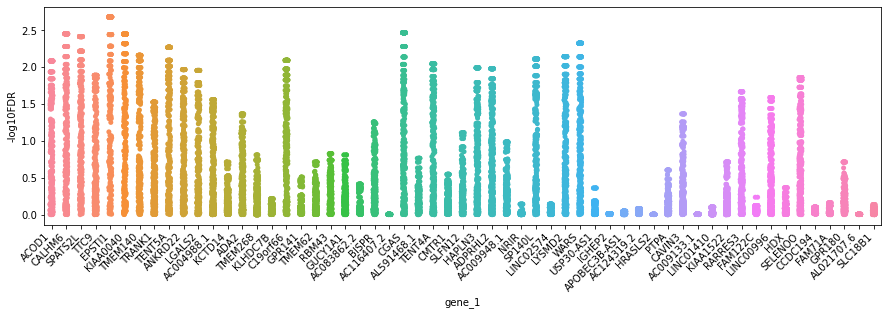

In [342]:
plt.figure(figsize=(15, 4))
ax = sns.stripplot(data=cM_B_results, x='gene_1', y='-log10FDR')
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45);

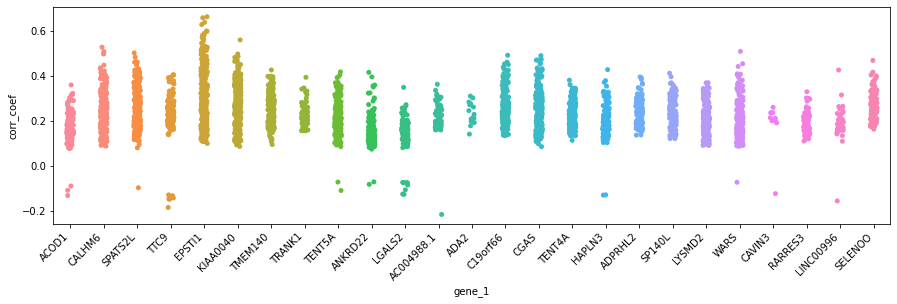

In [730]:
plt.figure(figsize=(15, 4))
ax = sns.stripplot(data=cM_B_results[cM_B_results['corr_fdr'] < 0.05], x='gene_1', y='corr_coef')
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45);

In [739]:
gene_1 = 'WARS'
# coef_thresh = 0.45
keep_top = 40
sub_results = cM_B_results[((cM_B_results['gene_1'] == gene_1) & 
#                             (cM_B_results['corr_coef'] > coef_thresh) &
                            (cM_B_results['corr_fdr'] < 0.05))].sort_values(by='corr_coef', ascending=False).iloc[:keep_top]
high_corr_genes = sub_results['gene_2'].values

In [740]:
high_corr_count_df = df_bool[high_corr_genes].copy()
num_paths, num_genes = high_corr_count_df.shape
print(high_corr_count_df.shape)

(623, 40)


In [741]:
cumsum_df = high_corr_count_df.cumsum(axis=1).divide(df_bool.sum(1), axis=0).sort_values(by=high_corr_count_df.columns[-1], ascending=False)

In [742]:
x_vals = np.stack([np.arange(num_genes) for _ in range(num_paths)])

In [743]:
# any for "at any time" were in the top 2
top_names_any = np.unique(cumsum_df.apply(lambda x: x.sort_values(ascending=False).index[:2]).values.flatten())
top_names_final = cumsum_df.iloc[:10].index # sorted by last column above, so this is the final top ten

In [744]:
highlight_names = np.union1d(top_names_any, top_names_final)
highlight_names_idx = np.argwhere(cumsum_df.index.isin(highlight_names)).flatten()

In [745]:
plot_mean = cumsum_df[~cumsum_df.index.isin(highlight_names)].T.reset_index(drop=True).T.reset_index(drop=True)
plot_mean = plot_mean.rename_axis(mapper='pathway', axis=0).rename_axis(mapper='gene_rank', axis=1).reset_index(drop=False).melt(id_vars='pathway', value_name='cumsum')

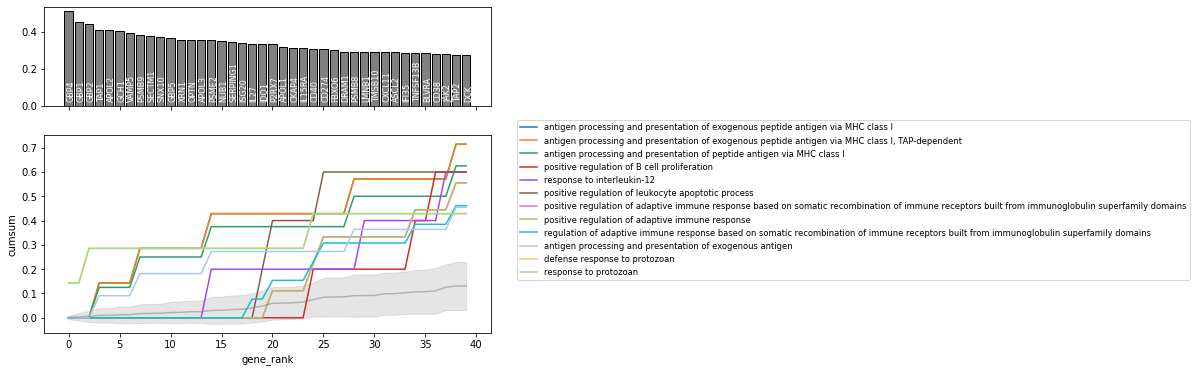

In [746]:
highlight_color = it.cycle(sc.pl.palettes.default_20)
fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios':[1, 2]}, sharex=True)

ax[0].bar(x=range(num_genes), height=sub_results['corr_coef'].values, facecolor='gray', edgecolor='k')
for idx, gene in enumerate(high_corr_genes):
    ax[0].text(idx+0.2, 0.02, gene, rotation=90, size=8, color='white', ha='center', va='bottom')

for idx, (x, y) in enumerate(zip(x_vals, cumsum_df.values)):
    if idx in highlight_names_idx:
        ax[1].plot(x, y, c=next(highlight_color), label=cumsum_df.index[idx])
ax[1] = sns.lineplot(data = plot_mean, x='gene_rank', y='cumsum', ci='sd', color='gray', alpha=0.5, ax=ax[1])
ax[1].legend(fontsize='small', bbox_to_anchor=(1.05, 0.6, 1, 0.5))

In [721]:
enrich[0]['+']['results_sig'][enrich[0]['+']['results_sig'].index.str.contains(top_names_final[4])]

Category  QValueFDRBH  \
Name                                                           
tumor necrosis factor receptor binding       MF     0.028348   

                                                                       Genes  \
Name                                                                           
tumor necrosis factor receptor binding  TNFSF13B,TNFSF10,STAT1,TNFSF18,CASP8   

                                        GenesInTermInQuery  -log10FDR  
Name                                                                   
tumor necrosis factor receptor binding                   5   1.547484

TypeError: __init__() got an unexpected keyword argument 'font_dict'

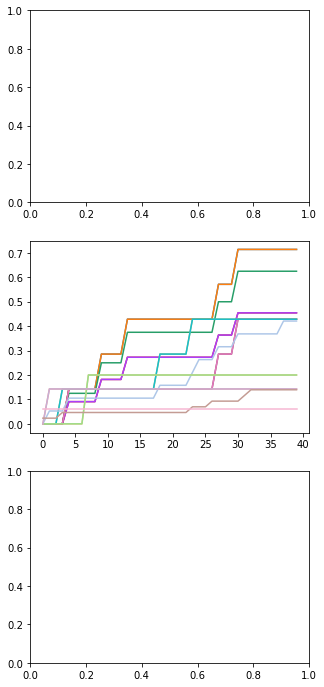

In [539]:
plt.legend()

In [486]:
colors = sc.pl.palettes.default_20[:10] + ['lightgray']*(high_corr_count_df.shape[0]-10)
for idx, (x, y) in enumerate(zip(x_vals, cumsum_df.values)):
    if idx in argmax_unique:
        plt.plot(x, y, c=next(highlight_color)
plt.show()
top_10 = cumsum_df.index[:10]
display(top_10)

SyntaxError: invalid syntax (<ipython-input-486-fa77680c205e>, line 5)

In [437]:
de['mrna']['enrich'][0]['+']['results_sig'].loc[top_10]

Category  QValueFDRBH  \
Name                                                                       
antigen processing and presentation of exogenou...       BP     0.023124   
antigen processing and presentation of exogenou...       BP     0.017693   
antigen processing and presentation of peptide ...       BP     0.020813   
antigen processing and presentation of exogenou...       BP     0.031996   
antigen processing and presentation of exogenou...       BP     0.024858   
regulation of hematopoietic progenitor cell dif...       BP     0.048252   
hematopoietic stem cell differentiation                  BP     0.040058   
defense response to protozoan                            BP     0.000148   
response to protozoan                                    BP     0.000259   
response to interleukin-1                                BP     0.000016   

                                                                                                Genes  \
Name                                                                                                    
antigen processing and presentation of exogenou...            HLA-C,HLA-F,PSMB8,PSMB9,PSME2,TAP1,TAP2   
antigen processing and presentation of exogenou...            HLA-C,HLA-F,PSMB8,PSMB9,PSME2,TAP1,TAP2   
antigen processing and presentation of peptide ...        HLA-C,HLA-F,PSMB8,PSMB9,PSME2,ACE,TAP1,TAP2   
antigen processing and presentation of exogenou...  HLA-C,HLA-F,OSBPL1A,CTSL,LGMN,PSMB8,PSMB9,PSME...   
antigen processing and presentation of exogenou...  HLA-C,HLA-F,OSBPL1A,CTSL,LGMN,PSMB8,PSMB9,PSME...   
regulation of hematopoietic progenitor cell dif...         KITLG,FOXC1,EIF2AK2,PSMB8,PSMB9,PSME2,LMO2   
hematopoietic stem cell differentiation                      FOXC1,EIF2AK2,PSMB8,PSMB9,PSME2,ACE,LMO2   
defense response to protozoan                                    IRF8,BATF2,MYD88,GBP7,GBP2,GBP4,CD40   
response to protozoan                                            IRF8,BATF2,MYD88,GBP7,GBP2,GBP4,CD40   
response to interleukin-1                           ZBP1,CCL2,CCL3,CCL4,CCL7,CCL8,ANKRD1,MYD88,RIP...   

                                                    GenesInTermInQuery  \
Name                                                                     
antigen processing and presentation of exogenou...                   7   
antigen processing and presentation of exogenou...                   7   
antigen processing and presentation of peptide ...                   8   
antigen processing and presentation of exogenou...                  11   
antigen processing and presentation of exogenou...                  11   
regulation of hematopoietic progenitor cell dif...                   7   
hematopoietic stem cell differentiation                              7   
defense response to protozoan                                        7   
response to protozoan                                                7   
response to interleukin-1                                           19   

                                                    -log10FDR  
Name                                                           
antigen processing and presentation of exogenou...   1.635944  
antigen processing and presentation of exogenou...   1.752207  
antigen processing and presentation of peptide ...   1.681661  
antigen processing and presentation of exogenou...   1.494901  
antigen processing and presentation of exogenou...   1.604533  
regulation of hematopoietic progenitor cell dif...   1.316488  
hematopoietic stem cell differentiation              1.397306  
defense response to protozoan                        3.830542  
response to protozoan                                3.587367  
response to interleukin-1                            4.791005

In [90]:
focus = ['SPATS2L', 'TTC9', 'KIAA0040', 'CBR1', 'SLC38A5']

In [91]:
focus

['SPATS2L', 'TTC9', 'KIAA0040', 'CBR1', 'SLC38A5']

In [102]:
enrich[0]['+']['results_sig']

Category   QValueFDRBH  \
Name                                                                        
defense response to other organism                       BP  7.457383e-48   
innate immune response                                   BP  3.344429e-46   
immune effector process                                  BP  1.508847e-45   
cytokine-mediated signaling pathway                      BP  2.082694e-43   
response to cytokine                                     BP  2.458919e-41   
...                                                     ...           ...   
nucleobase-containing compound transport                 BP  1.989515e-01   
defense response to Gram-negative bacterium              BP  1.989515e-01   
negative regulation of calcium ion transport             BP  1.990075e-01   
positive regulation of calcium ion transmembran...       BP  1.996599e-01   
regulation of cellular amine metabolic process           BP  1.996599e-01   

                                                                                                Genes  \
Name                                                                                                    
defense response to other organism                  DTX3L,ADAM8,ADAR,ADARB1,MEFV,ADM,H2BC4,H2BC21,...   
innate immune response                              DTX3L,ADAM8,ADAR,ADARB1,MEFV,H2BC4,H2BC21,MNDA...   
immune effector process                             DTX3L,MDK,DYSF,ADA,ADAM8,ADAR,ADARB1,MICB,CXCL...   
cytokine-mediated signaling pathway                 MCL1,ADAR,H2BC21,CXCL9,CUL1,IFITM1,BIRC2,BIRC3...   
response to cytokine                                MCL1,ADAR,MEFV,H2BC21,TLE5,CXCL9,MNDA,CUL1,IFI...   
...                                                                                               ...   
nucleobase-containing compound transport            ABCD1,MRPL18,MX2,RIPK1,P2RX7,CD47,PNPT1,QKI,SL...   
defense response to Gram-negative bacterium         ADM,H2BC21,DROSHA,TNFRSF14,H2BC11,DEFB1,RNASE2...   
negative regulation of calcium ion transport        DYSF,BCL2,CALM1,CLIC2,PRKCE,ACE,LILRB2,FKBP1B,...   
positive regulation of calcium ion transmembran...  ADRB2,CXCL9,ATP1B1,STAC3,CALM1,CAPN3,P2RY6,CXC...   
regulation of cellular amine metabolic process      NR4A2,SLC7A7,PSMF1,PSMA2,PSMA4,PSMA5,PSMB8,PSM...   

                                                    GenesInTermInQuery  \
Name                                                                     
defense response to other organism                                 260   
innate immune response                                             226   
immune effector process                                            268   
cytokine-mediated signaling pathway                                191   
response to cytokine                                               247   
...                                                                ...   
nucleobase-containing compound transport                            28   
defense response to Gram-negative bacterium                         13   
negative regulation of calcium ion transport                        11   
positive regulation of calcium ion transmembran...                  12   
regulation of cellular amine metabolic process                      12   

                                                    -log10FDR  
Name                                                           
defense response to other organism                  47.127414  
innate immune response                              45.475678  
immune effector process                             44.821355  
cytokine-mediated signaling pathway                 42.681375  
response to cytokine                                40.609256  
...                                                       ...  
nucleobase-containing compound transport             0.701253  
defense response to Gram-negative bacterium          0.701253  
negative regulation of calcium ion transport         0.701131  
positive regulat

In [130]:
df_bool

AAMDC  ABCD1  ABHD12  \
Name                                                                       
defense response to other organism                  False  False   False   
innate immune response                              False  False   False   
immune effector process                             False  False   False   
cytokine-mediated signaling pathway                 False  False   False   
response to cytokine                                False  False   False   
...                                                   ...    ...     ...   
nucleobase-containing compound transport            False   True   False   
defense response to Gram-negative bacterium         False  False   False   
negative regulation of calcium ion transport        False  False   False   
positive regulation of calcium ion transmembran...  False  False   False   
regulation of cellular amine metabolic process      False  False   False   

                                                    ABHD17C  ABHD3   ABI1  \
Name                                                                        
defense response to other organism                    False  False  False   
innate immune response                                False  False  False   
immune effector process                               False  False   True   
cytokine-mediated signaling pathway                   False  False  False   
response to cytokine                                  False  False  False   
...                                                     ...    ...    ...   
nucleobase-containing compound transport              False  False  False   
defense response to Gram-negative bacterium           False  False  False   
negative regulation of calcium ion transport          False  False  False   
positive regulation of calcium ion transmembran...    False  False  False   
regulation of cellular amine metabolic process        False  False  False   

                                                     ABL2  ABLIM1  ABTB1  \
Name                                                                       
defense response to other organism                  False   False  False   
innate immune response                              False   False  False   
immune effector process                             False   False  False   
cytokine-mediated signaling pathway                 False   False  False   
response to cytokine                                False   False  False   
...                                                   ...     ...    ...   
nucleobase-containing compound transport            False   False  False   
defense response to Gram-negative bacterium         False   False  False   
negative regulation of calcium ion transport        False   False  False   
positive regulation of calcium ion transmembran...  False   False  False   
regulation of cellular amine metabolic process      False   False  False   

                                                    ABTB2  ...  ZNF366  \
Name                                                       ...           
defense response to other organism                  False  ...   False   
innate immune response                              False  ...   False   
immune effector process                             False  ...   False   
cytokine-mediated signaling pathway                 False  ...   False   
response to cytokine                                False  ...   False   
...                                                   ...  ...     ...   
nucleobase-containing compound transport            False  ...   False   
defense response to Gram-negative bacterium         False  ...   False   
negative regulation of calcium ion transport        False  ...   False   
positive regulation of calcium ion transmembran...  False  ...   False   
regulation of cellular amine metabolic process      False  ...   False   

                                                    ZNF385A  ZNF438  ZNF496  \
Name                          

In [107]:
max_bp_sig = dict()

In [108]:
for bp_idx, gene_idx in tqdm(np.argwhere(df_bool.values)[::-1]):
    max_bp_sig[df_bool.columns[gene_idx]] = enrich[0]['+']['results_sig'].iloc[bp_idx].loc['-log10FDR']

In [122]:
max_bp_sig_l2fc = pd.DataFrame.from_dict(max_bp_sig, orient='index', columns=['max_bp_sig']).join(de['mrna']['compare'][['l0']])

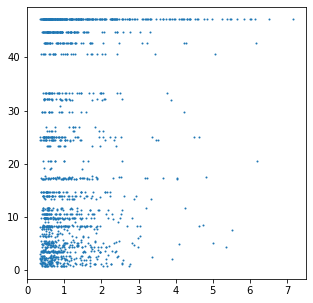

In [129]:
plt.figure(figsize=(5, 5))
plt.scatter(max_bp_sig_l2fc['l0'].values, max_bp_sig_l2fc['max_bp_sig'].values, s=1);

In [126]:
max_bp_sig_l2fc[((max_bp_sig_l2fc['max_bp_sig'] > 2) & (max_bp_sig_l2fc['l0'] > 1))]

max_bp_sig        l0
PSME2      47.127414  1.004364
PSMB9      47.127414  1.874273
PSMB8      47.127414  1.209553
PSMA4      47.127414  1.158738
STAC3       7.010134  1.121547
...              ...       ...
LILRA6     13.574183  1.537002
TMEM255A   17.559076  1.129825
TMEM229B   17.559076  1.845706
IFI44      31.936930  3.869172
SP110      25.100529  3.371242

[570 rows x 2 columns]

In [127]:
unannotated = ['SPATS2L', 'AC004988.1', 'L2HGDH', 'TMEM62', 'AC116407.2', 'AL591468.1',
              'SLFN12', 'AC009948.1', 'NRIR', 'ZCCHC2', 'LINC02574', 'APOBEC3B-AS1',
              'HRASLS2', 'CAVIN3', 'LINC01410', 'KIAA1522', 'SELENOO', 'CCDC194',
              'TTC7B', 'FAM71A', 'GPR180', 'AL021707.6', 'SLC18B1', 'FXYD6',
              'SCAMP1-AS1', 'LINC01504', 'STIMATE', 'LRRC3', 'AC093827.4',
              'AC008079.2', 'PRR34-AS1', 'LINC01358', 'TMEM219', 'TTC38', 'LINC02068',
              'AC016745.2', 'PLA2G16', 'PPDPF', 'TMEM159', 'LINC01506']
CC_annot = ['ABCD1', 'ADAM8', 'ADRB2', 'AGRN', 'AMBRA1', 'ANKFY1', 'ANKRD1',
       'AP5Z1', 'ARHGAP21', 'ARL8A', 'ARSA', 'ATF7', 'ATP13A2',
       'ATP6V0D2', 'ATP6V1H', 'ATP8A1', 'ATP8B1', 'ATXN7', 'AXL',
       'B3GALT4', 'B3GNT2', 'BAALC', 'BAG1', 'BARD1', 'BASP1', 'BBS7',
       'BCL11A', 'BCL2', 'BET1L', 'BIN2', 'BIRC2', 'BLZF1', 'BMPR2',
       'BNIP3L', 'BRSK1', 'BTK', 'C1GALT1', 'CALD1', 'CALM1', 'CAPN2',
       'CARD11', 'CASP3', 'CBLB', 'CCDC85B', 'CCL2', 'CCNJ', 'CCP110',
       'CD109', 'CD163', 'CD164', 'CD59', 'CD68', 'CD99', 'CDC42EP1',
       'CDKL5', 'CEP164', 'CEP68', 'CFLAR', 'CHMP1A', 'CKAP4', 'CLEC12A',
       'CLIC1', 'CLIC4', 'CNP', 'CNTRL', 'CRACR2A', 'CREBRF', 'CREG1',
       'CRHBP', 'CRTAM', 'CSRP2', 'CST3', 'CSTB', 'CTSB', 'CTSD', 'CTSL',
       'CYB561', 'CYSTM1', 'CYTH1', 'DCDC1', 'DCP1A', 'DCTN4', 'DDIT3',
       'DISC1', 'DLL1', 'DNAAF1', 'DNAJB6', 'DRAP1', 'DSP', 'EHD4',
       'EIF2AK2', 'ELF4', 'ENPP4', 'EPAS1', 'EPB41L2', 'EPHB1', 'ERBIN',
       'ERP44', 'ETS1', 'EXOC3L1', 'EXOC6', 'EXT1', 'EXT2', 'EZR',
       'FAM76B', 'FMR1', 'FNIP2', 'FPR2', 'FUT4', 'FYTTD1', 'GABBR1',
       'GALNT6', 'GCA', 'GCNT4', 'GLMP', 'GNA13', 'GNAI1', 'GNAI3',
       'GNG5', 'GNLY', 'GOLGA8B', 'GORASP1', 'GPM6B', 'GPR161', 'GRN',
       'GTF2E2', 'GTPBP2', 'HAVCR2', 'HBP1', 'HEBP2', 'HIRA', 'HK2',
       'HLA-G', 'HMGB2', 'HMOX1', 'HPS6', 'HPSE', 'HSP90AA1', 'HSPA1A',
       'HSPA1B', 'HSPD1', 'IDUA', 'IFIT1', 'IFT74', 'IGF1', 'IKBKE',
       'INPP5D', 'IRF2', 'IRF4', 'ITGA2', 'ITM2B', 'ITSN1', 'JAZF1',
       'JUP', 'KAT2B', 'KCNA3', 'KIAA0319L', 'KIF23', 'KLF11', 'KPNB1',
       'KPTN', 'LAMP2', 'LGMN', 'LHFPL2', 'LILRB2', 'LILRB4', 'LMO2',
       'LPAR2', 'MAFB', 'MAGED2', 'MAK', 'MALT1', 'MARCKS', 'MASTL',
       'MED10', 'MED25', 'MED6', 'MEF2A', 'MIA3', 'MIER1', 'MNDA',
       'MORC3', 'MPP1', 'MS4A7', 'MVB12B', 'MX1', 'MYD88', 'N4BP1',
       'NCOA2', 'NCOR2', 'NDC80', 'NECTIN2', 'NEDD1', 'NEXN', 'NFYA',
       'NR4A2', 'NR4A3', 'NRAS', 'NTNG2', 'NUP160', 'NUP205', 'NUP210',
       'NUPR1', 'ODF2L', 'OLIG2', 'OSBPL9', 'OTOF', 'PAM', 'PAX5', 'PAX8',
       'PCNA', 'PEAK1', 'PHACTR2', 'PI4K2B', 'PKN2', 'PLAGL1', 'PLBD2',
       'PLEKHF2', 'POLDIP3', 'PRKCB', 'PRKCE', 'PSD4', 'PTK2B', 'PTP4A1',
       'PTPRA', 'PTX3', 'PYHIN1', 'RAB31', 'RAB35', 'RAB8B', 'RAB9A',
       'RAP2C', 'RASGRP3', 'RBBP6', 'RBBP8', 'RCBTB2', 'RET', 'RETN',
       'RHOB', 'RHOC', 'RIC1', 'RILP', 'RNASEL', 'RND3', 'RP2', 'RUNX2',
       'SAP130', 'SAP18', 'SBF2', 'SCAMP1', 'SCARB2', 'SCLT1', 'SERPINA1',
       'SERPINH1', 'SETX', 'SFI1', 'SH3GLB1', 'SHC1', 'SIGLEC14',
       'SLAMF1', 'SLC17A5', 'SLC1A4', 'SLC2A12', 'SLC35C1', 'SLC35D2',
       'SLC39A13', 'SLC44A2', 'SLC9B2', 'SMAD1', 'SMAD3', 'SMU1', 'SNX2',
       'SPN', 'SPP1', 'SRD5A1', 'ST6GAL1', 'ST8SIA4', 'STBD1', 'SUPT3H',
       'TAF1B', 'TBC1D10C', 'TCF4', 'TESK1', 'TFG', 'TICAM1', 'TIMP1',
       'TINF2', 'TIPIN', 'TLK2', 'TLR3', 'TMBIM1', 'TMEM150B', 'TMEM63A',
       'TNFRSF10A', 'TOP3A', 'TOR1A', 'TPD52L2', 'TPM1', 'TPM3', 'TPM4',
       'TRAF1', 'TRAF6', 'TRIM25', 'TRIM36', 'TRIP4', 'TRIP6', 'TUBA1A',
       'TYROBP', 'UBC', 'UNC13B', 'USP28', 'USP33', 'VAV3', 'WASL',
       'WBP4', 'WHAMM', 'XIAP', 'XPO1', 'ZAP70', 'ZDHHC13', 'ZDHHC2',
       'ZFYVE26', 'ZMIZ2', 'ZNF350']

In [128]:
len(CC_annot)

324

In [104]:
df_bool.columns[df_bool.iloc[0] == True]

Index(['ADAM8', 'ADAR', 'ADARB1', 'ADM', 'AIM2', 'ALPK1', 'ANG', 'APOBEC3A',
       'APOBEC3B', 'APOBEC3C',
       ...
       'UNC93B1', 'USP15', 'USP18', 'XAF1', 'XCL1', 'XCL2', 'XIAP', 'ZAP70',
       'ZBP1', 'ZC3HAV1'],
      dtype='object', length=260)

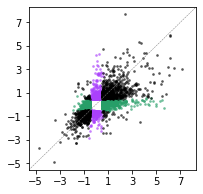

In [214]:
plt.figure(figsize=(3,3))
shared = de_compare[bool_dict['0u1u'] | bool_dict['0d1d'] | bool_dict['0u1d'] | bool_dict['0d1u']]
sp0 = de_compare[bool_dict['0u1n'] | bool_dict['0d1n']]
sp1 = de_compare[bool_dict['0n1u'] | bool_dict['0n1d']]
plt.scatter(sp0['l0'].values, sp0['l1'].values, s=3, alpha=0.5, color=cond_colors['B'])
plt.scatter(sp1['l0'].values, sp1['l1'].values, s=3, alpha=0.5, color=cond_colors['G'])
plt.scatter(shared['l0'].values, shared['l1'].values, s=3, alpha=0.5, color='k')
lim = min(min(plt.xlim()), min(plt.ylim())), max(max(plt.xlim()), max(plt.ylim()))
plt.plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
plt.ylim(lim)
plt.xlim(lim)
plt.xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
plt.yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

In [215]:
def repel_labels(ax, x, y, labels, k=0.01, scale=10):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)
#     pos = nx.spiral_layout(G, scale=scale)

    # undo spring_layout's rescaling
#     pos_after = np.vstack([pos[d] for d in data_nodes])
#     pos_before = np.vstack([init_pos[d] for d in data_nodes])
#     scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
#     scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
#     shift = np.array([shift_x, shift_y])
#     for key, val in pos.items():
#         pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="-",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='lightgray'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])
    return ax

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


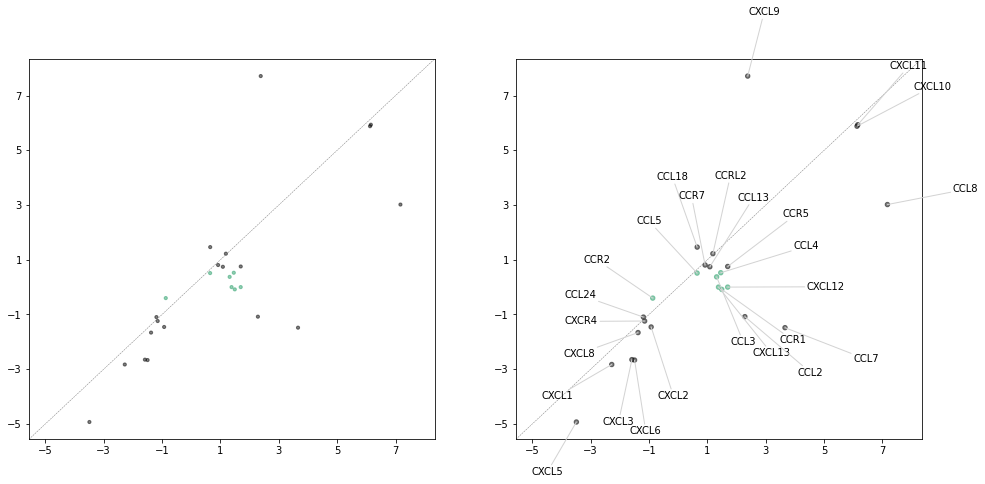

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sp0 = de_compare[(bool_dict['0u1n'] | bool_dict['0d1n']) & check_genes_bool]
sp1 = de_compare[(bool_dict['0n1u'] | bool_dict['0n1d']) & check_genes_bool]
shared = de_compare[(bool_dict['0u1u'] | bool_dict['0d1d'] | bool_dict['0u1d'] | bool_dict['0d1u']) & check_genes_bool]
labels = sp0.index.tolist() + sp1.index.tolist() + shared.index.tolist()

x1, x2, x3 = (sp0['l0'].values, sp1['l0'].values, shared['l0'].values)
y1, y2, y3 = (sp0['l1'].values, sp1['l1'].values, shared['l1'].values)
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])
c = [cond_colors['B']]*len(x1) + [cond_colors['G']]*len(x2) + ['k']*len(x3)
ax[0].scatter(x, y, s=10, alpha=0.5, color=c)
ax[0].set_ylim(lim)
ax[0].set_xlim(lim)
ax[0].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[0].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[0].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks


ax[1].scatter(x, y, s=20, alpha=0.5, color=c)
ax[1].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[1] = repel_labels(ax[1], x, y, labels, k=1)
ax[1].set_ylim(lim)
ax[1].set_xlim(lim)
ax[1].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[1].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

In [217]:
check_genes_bool = de_compare.index.str.contains('TRIM')
# de_compare[check_genes_bool]

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


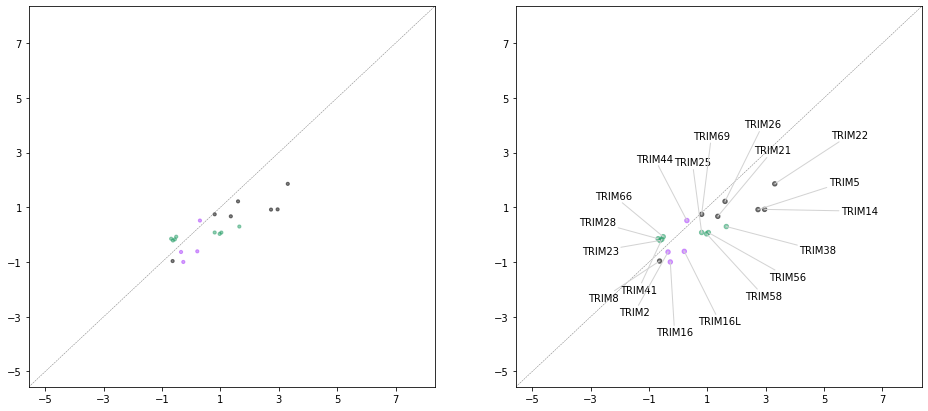

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sp0 = de_compare[(bool_dict['0u1n'] | bool_dict['0d1n']) & check_genes_bool]
sp1 = de_compare[(bool_dict['0n1u'] | bool_dict['0n1d']) & check_genes_bool]
shared = de_compare[(bool_dict['0u1u'] | bool_dict['0d1d'] | bool_dict['0u1d'] | bool_dict['0d1u']) & check_genes_bool]
labels = sp0.index.tolist() + sp1.index.tolist() + shared.index.tolist()

x1, x2, x3 = (sp0['l0'].values, sp1['l0'].values, shared['l0'].values)
y1, y2, y3 = (sp0['l1'].values, sp1['l1'].values, shared['l1'].values)
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])
c = [cond_colors['B']]*len(x1) + [cond_colors['G']]*len(x2) + ['k']*len(x3)
ax[0].scatter(x, y, s=10, alpha=0.5, color=c)
ax[0].set_ylim(lim)
ax[0].set_xlim(lim)
ax[0].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[0].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[0].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks


ax[1].scatter(x, y, s=20, alpha=0.5, color=c)
ax[1].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[1] = repel_labels(ax[1], x, y, labels, k=1)
ax[1].set_ylim(lim)
ax[1].set_xlim(lim)
ax[1].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[1].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

In [219]:
check_genes_bool = de_compare.index.str.contains('HLA')
# de_compare[check_genes_bool]

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


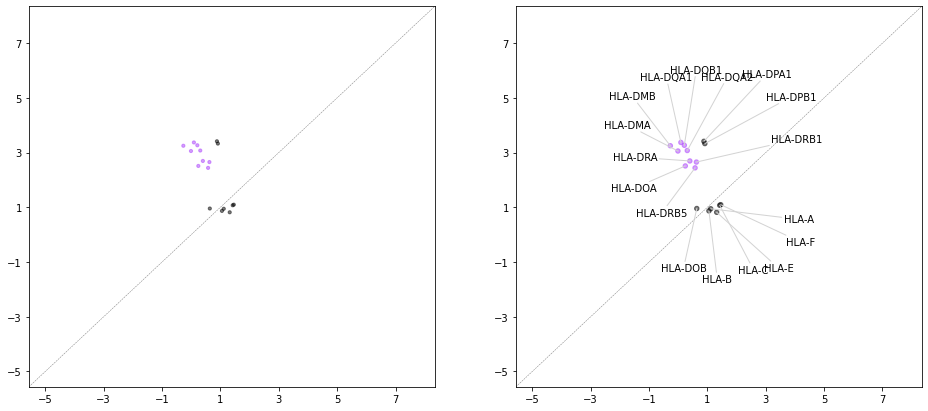

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sp0 = de_compare[(bool_dict['0u1n'] | bool_dict['0d1n']) & check_genes_bool]
sp1 = de_compare[(bool_dict['0n1u'] | bool_dict['0n1d']) & check_genes_bool]
shared = de_compare[(bool_dict['0u1u'] | bool_dict['0d1d'] | bool_dict['0u1d'] | bool_dict['0d1u']) & check_genes_bool]
labels = sp0.index.tolist() + sp1.index.tolist() + shared.index.tolist()

x1, x2, x3 = (sp0['l0'].values, sp1['l0'].values, shared['l0'].values)
y1, y2, y3 = (sp0['l1'].values, sp1['l1'].values, shared['l1'].values)
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])
c = [cond_colors['B']]*len(x1) + [cond_colors['G']]*len(x2) + ['k']*len(x3)
ax[0].scatter(x, y, s=10, alpha=0.5, color=c)
ax[0].set_ylim(lim)
ax[0].set_xlim(lim)
ax[0].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[0].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[0].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks


ax[1].scatter(x, y, s=20, alpha=0.5, color=c)
ax[1].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[1] = repel_labels(ax[1], x, y, labels, k=1)
ax[1].set_ylim(lim)
ax[1].set_xlim(lim)
ax[1].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[1].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

In [223]:
check_genes_bool = de_compare.index.str.startswith('IL')
# de_compare[check_genes_bool]

/home/ssm-user/miniconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


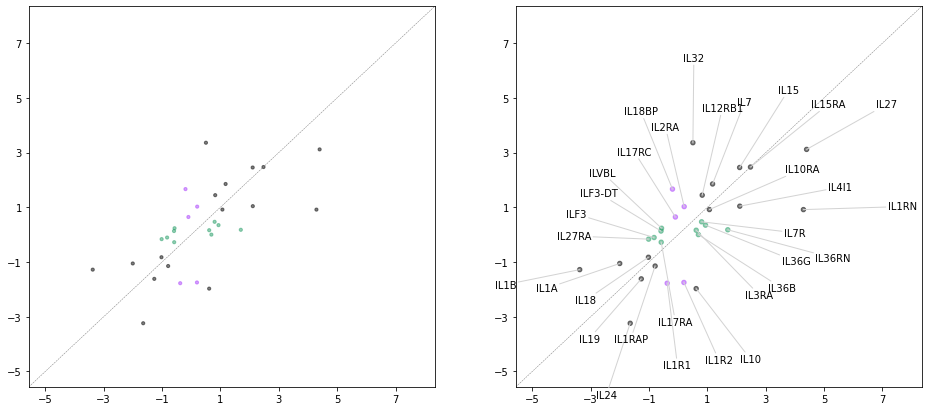

In [224]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sp0 = de_compare[(bool_dict['0u1n'] | bool_dict['0d1n']) & check_genes_bool]
sp1 = de_compare[(bool_dict['0n1u'] | bool_dict['0n1d']) & check_genes_bool]
shared = de_compare[(bool_dict['0u1u'] | bool_dict['0d1d'] | bool_dict['0u1d'] | bool_dict['0d1u']) & check_genes_bool]
labels = sp0.index.tolist() + sp1.index.tolist() + shared.index.tolist()

x1, x2, x3 = (sp0['l0'].values, sp1['l0'].values, shared['l0'].values)
y1, y2, y3 = (sp0['l1'].values, sp1['l1'].values, shared['l1'].values)
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])
c = [cond_colors['B']]*len(x1) + [cond_colors['G']]*len(x2) + ['k']*len(x3)
ax[0].scatter(x, y, s=10, alpha=0.5, color=c)
ax[0].set_ylim(lim)
ax[0].set_xlim(lim)
ax[0].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[0].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[0].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks


ax[1].scatter(x, y, s=20, alpha=0.5, color=c)
ax[1].plot(lim, lim, color='gray', linewidth=0.5, linestyle='--')
ax[1] = repel_labels(ax[1], x, y, labels, k=1)
ax[1].set_ylim(lim)
ax[1].set_xlim(lim)
ax[1].set_xticks(ticks=range(*np.ceil(lim).astype(int), 2)) # change 1 or 2 depending on how it looks
ax[1].set_yticks(ticks=range(*np.ceil(lim).astype(int), 2)); # change 1 or 2 depending on how it looks

In [226]:
l2fc_diff = de_compare[check_genes_bool]['l0'] - de_compare[check_genes_bool]['l1']
(l2fc_diff).join()

In [230]:
l2fc_diff

NameError: name 'l2fc_diff' is not defined